# Задача 4. Нейронные сети

* **Дедлайн**: 31.05.2024, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные в виде изображений для задачи классификации. Dataset: https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification.
- [x] Реализовать классы, необходимые для построения сети со следующими слоями
    - FullyConnectedLayer
    - ReluLayer
    - FullyConnectedLayer
- [x] Использовать CrossEntropyLoss и L2-регуляризацию.
- [x] Обучить модель на тренировочных данных, подбирать параметры (особенно learning rate) на валидационной и оценить качество на тестовой. Анализировать графики train/val loss, проверять на каждом шаге корректность вычисления градиентов с помощью разностной оценки.
- [x] * (**+2 балла**) Добавить Batch normalization.
- [x] * (**+2 балла**) В качестве оптимизатор использовать один из: Momentum, RMSprop.
- [ ] * (**+1 балл**) Также реализовать оптимизатор Adam.

In [5]:
import numpy as np
import random
import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import torch

import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
def set_seeds():
    # fix random seeds
    SEED_VALUE = 42

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True


set_seeds()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [8]:
df = pd.read_csv('../../data/butterfly/train.csv')
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [9]:
df['label'].value_counts()

label
MOURNING CLOAK    131
SLEEPY ORANGE     107
ATALA             100
BROWN SIPROETA     99
CRECENT            97
                 ... 
AMERICAN SNOOT     74
GOLD BANDED        73
MALACHITE          73
CRIMSON PATCH      72
WOOD SATYR         71
Name: count, Length: 75, dtype: int64

In [10]:
most_20 = df['label'].value_counts()[:20].index

In [11]:
df = df[df['label'].isin(most_20)]

In [12]:
df['label'].value_counts()

label
MOURNING CLOAK              131
SLEEPY ORANGE               107
ATALA                       100
BROWN SIPROETA               99
SCARCE SWALLOW               97
CRECENT                      97
BANDED ORANGE HELICONIAN     97
RED CRACKER                  96
ORANGE TIP                   96
MILBERTS TORTOISESHELL       96
CHECQUERED SKIPPER           95
IPHICLUS SISTER              95
EASTERN PINE ELFIN           95
DANAID EGGFLY                94
COPPER TAIL                  94
GREAT JAY                    94
EASTERN COMA                 93
CLEOPATRA                    93
PURPLISH COPPER              92
CLOUDED SULPHUR              92
Name: count, dtype: int64

In [14]:
label_encoder = LabelEncoder().fit(df['label'])
df['label'] = label_encoder.transform(df['label'])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(list(df['filename']), list(df['label']), test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3)

In [16]:
from hw.task4.dataset import ButterflyDataset
from torch.utils.data import DataLoader


def get_single_loader(img_dir,
                      images,
                      classes,
                      transform,
                      batch_size,
                      num_workers=8,
                      pin_memory=True,):
    ds = ButterflyDataset(
        img_dir=img_dir,
        images=images,
        classes=classes,
        transform=transform,
    )

    loader = DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    return loader

In [17]:
IMAGE_HEIGHT = 144
IMAGE_WIDTH = 144

transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

In [18]:
img_dir = "/home/alex/Projects/Python/ml-course-spbu/data/butterfly/train"
batch_size = 8

train_data_loader = get_single_loader(img_dir=img_dir,
                                      images=X_train,
                                      classes=y_train,
                                      transform=transform,
                                      batch_size=batch_size)
val_data_loader = get_single_loader(img_dir=img_dir,
                                      images=X_val,
                                      classes=y_val,
                                      transform=transform,
                                      batch_size=batch_size)
test_data_loader = get_single_loader(img_dir=img_dir,
                                    images=X_test,
                                    classes=y_test,
                                    transform=transform,
                                    batch_size=batch_size)


# Custom Layers

In [19]:
import math


class Linear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.bias = bias
        self.weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        x, y = input.shape
        if y != self.in_features:
            print(f'Wrong Input Features. Please use tensor with {self.in_features} Input Features')
            return 0
        output = input.matmul(self.weight.t())
        if self.bias is not None:
            output += self.bias
        ret = output
        return ret

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [20]:
class ReLU(nn.Module):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, input):
        return torch.max(torch.zeros_like(input), input)

In [21]:
class MyClassificationNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyClassificationNet, self).__init__()
        self.fc1 = Linear(input_size, hidden_size)
        self.relu = ReLU() 
        self.fc2 = Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        return x

# Train

In [30]:
def train(model, optimizer, train_loader, val_loader, num_epochs, learning_rate, weight_decay, res):
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optimizer(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    train_losses = []
    val_losses = []

    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            # print(labels)
            images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
            labels = labels.to(device)
            # images = images.swapaxes(0,1)
            outputs = model(images)
            # outputs = torch.from_numpy(model(images))
            # outputs = outputs.swapaxes(0,1)
            # print(outputs.shape)
            # print(labels.shape)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(tqdm(val_loader)):
                images = images.view(-1, IMAGE_HEIGHT * IMAGE_WIDTH * 3).to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = correct_val / total_val

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {100 * val_accuracy:.2f}%')
        if val_accuracy > best_acc:
            # state = {
            #     'epoch': epoch + 1,
            #     'state_dict': model.state_dict(),
            #     'optimizer': optimizer.state_dict(),
            # }
            # torch.save(state,
            #            f"butterfly_model_with_norm_{lr}_wd_{weight_decay}_optim_{str(optimizer).split('(')[0].replace(' ', '')}.state")
            best_acc = val_accuracy
        # Проверка корректности вычисления градиентов с помощью разностной оценки
        check_gradients(model, *next(iter(train_data_loader)), loss_fn=criterion)

    tmp = {"optimizer": [str(optimizer).split('(')[0].replace(' ', '')],
         "learning_rate": [lr],
         "weight_decay": [weight_decay],
         "val_accuracy": [best_acc],
           }
    res = pd.concat([res, pd.DataFrame(tmp)])
    
    return train_losses, val_losses, res


In [31]:
import torch

def check_gradients(model, input_data, target_data, loss_fn, epsilon=1e-5, num_params_to_check=10):
    input_data = input_data.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
    target_data = target_data.to(device)
    model.zero_grad()
    loss = loss_fn(model(input_data), target_data)
    loss.backward()

    params_to_check = list(model.named_parameters())
    num_params = sum(p[1].numel() for p in params_to_check if p[1].requires_grad)
    if num_params_to_check > num_params:
        num_params_to_check = num_params

    indices = torch.randperm(num_params)[:num_params_to_check]

    for param_name, param in params_to_check: 
        if param.requires_grad:
            print(f"Checking gradient for parameter: {param_name}")
            
            grad = param.grad
            param_flat = param.data.view(-1)
            grad_flat = grad.view(-1)

            for idx in indices:
                if idx >= param_flat.size(0):
                    break

                param_flat[idx] += epsilon
                loss_plus = loss_fn(model(input_data), target_data)
                param_flat[idx] -= 2 * epsilon
                loss_minus = loss_fn(model(input_data), target_data)
                param_flat[idx] += epsilon

                numerical_grad = (loss_plus - loss_minus) / (2 * epsilon)
                diff = torch.abs(numerical_grad - grad_flat[idx]).item()

                # if diff > epsilon:
                #     print(f'Gradient check failed for parameter {param_name}')
                #     return False

    print('Gradients check passed!')
    return True

In [32]:
res = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])

Training lr=0.001, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 91.39it/s]

Epoch [1/10], Train Loss: 2.8464, Train Accuracy: 12.51%, Val Loss: 2.6545, Val Accuracy: 21.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.63it/s]

Epoch [2/10], Train Loss: 2.5510, Train Accuracy: 23.85%, Val Loss: 2.4155, Val Accuracy: 28.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.51it/s]

Epoch [3/10], Train Loss: 2.3375, Train Accuracy: 32.55%, Val Loss: 2.3027, Val Accuracy: 32.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.06it/s]

Epoch [4/10], Train Loss: 2.1605, Train Accuracy: 37.45%, Val Loss: 2.2617, Val Accuracy: 27.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.29it/s]

Epoch [5/10], Train Loss: 2.0205, Train Accuracy: 44.33%, Val Loss: 2.1434, Val Accuracy: 36.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.70it/s]

Epoch [6/10], Train Loss: 1.8997, Train Accuracy: 46.45%, Val Loss: 2.0326, Val Accuracy: 37.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.36it/s]

Epoch [7/10], Train Loss: 1.7827, Train Accuracy: 47.70%, Val Loss: 1.9114, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.63it/s]

Epoch [8/10], Train Loss: 1.6946, Train Accuracy: 52.52%, Val Loss: 1.9201, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.60it/s]

Epoch [9/10], Train Loss: 1.6021, Train Accuracy: 55.52%, Val Loss: 1.9466, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.07it/s]

Epoch [10/10], Train Loss: 1.5241, Train Accuracy: 58.52%, Val Loss: 1.8300, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 67.08it/s]


Test Accuracy with learning rate 0.001: 36.93%


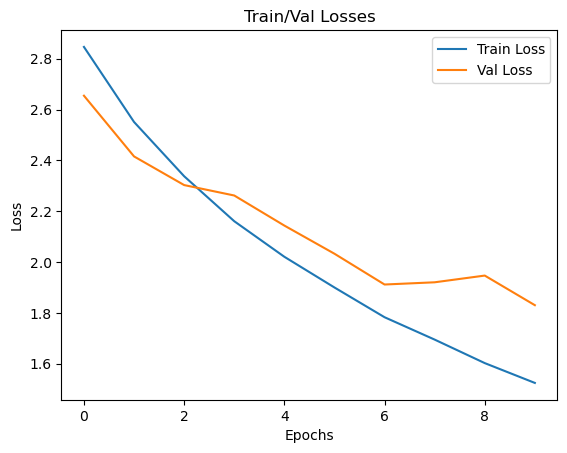

train_losses=[2.8464251944893286, 2.5510044300068193, 2.3375148926562037, 2.1604734777707106, 2.020543140277528, 1.8997290378425553, 1.7826502086126317, 1.6945757499912328, 1.6021130942461783, 1.5241083049634745]
[2.654459054653461, 2.415455391773811, 2.302730924808062, 2.261691228701518, 2.1433517909966984, 2.0325662241532254, 1.9113911791489675, 1.9201178275621855, 1.946585652919916, 1.8300402370783]
Training lr=0.001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 107.56it/s]

Epoch [1/10], Train Loss: 2.8496, Train Accuracy: 13.68%, Val Loss: 2.7623, Val Accuracy: 10.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.00it/s]

Epoch [2/10], Train Loss: 2.5558, Train Accuracy: 24.73%, Val Loss: 2.4332, Val Accuracy: 25.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.76it/s]

Epoch [3/10], Train Loss: 2.3497, Train Accuracy: 31.24%, Val Loss: 2.2862, Val Accuracy: 31.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.83it/s]

Epoch [4/10], Train Loss: 2.1675, Train Accuracy: 38.26%, Val Loss: 2.1528, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.69it/s]

Epoch [5/10], Train Loss: 2.0338, Train Accuracy: 41.62%, Val Loss: 2.1015, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.42it/s]

Epoch [6/10], Train Loss: 1.8978, Train Accuracy: 45.65%, Val Loss: 2.0393, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.06it/s]

Epoch [7/10], Train Loss: 1.7939, Train Accuracy: 48.28%, Val Loss: 2.0644, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.81it/s]

Epoch [8/10], Train Loss: 1.6944, Train Accuracy: 52.82%, Val Loss: 1.9181, Val Accuracy: 41.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.45it/s]

Epoch [9/10], Train Loss: 1.6097, Train Accuracy: 55.01%, Val Loss: 1.8991, Val Accuracy: 47.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.24it/s]

Epoch [10/10], Train Loss: 1.5406, Train Accuracy: 56.77%, Val Loss: 1.8178, Val Accuracy: 48.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 67.49it/s]


Test Accuracy with learning rate 0.001: 42.61%


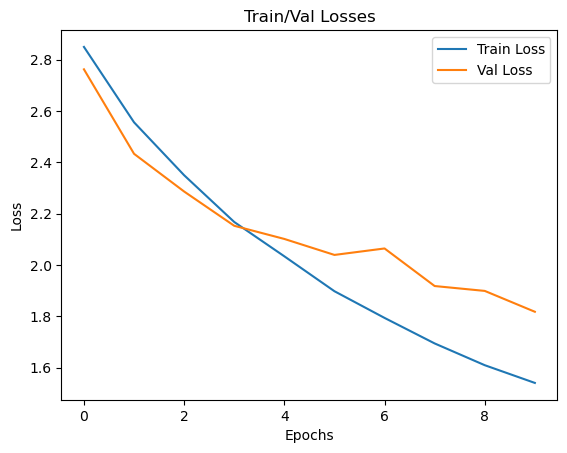

train_losses=[2.8496029460639285, 2.5558190199366786, 2.349670946249488, 2.167524443035237, 2.033814129076506, 1.8978310830411855, 1.793857811487209, 1.6944180012446397, 1.6096527203481796, 1.5406042375759772]
[2.7623432095234213, 2.433188713513888, 2.286217606984652, 2.152757468131872, 2.101497294811102, 2.0392522559716153, 2.0644192603918223, 1.918054731992575, 1.8990600922932992, 1.817826271057129]
Training lr=0.001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 108.58it/s]

Epoch [1/10], Train Loss: 2.8562, Train Accuracy: 12.44%, Val Loss: 2.6673, Val Accuracy: 17.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.85it/s]

Epoch [2/10], Train Loss: 2.5626, Train Accuracy: 23.99%, Val Loss: 2.4652, Val Accuracy: 20.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.05it/s]

Epoch [3/10], Train Loss: 2.3487, Train Accuracy: 30.29%, Val Loss: 2.2974, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.37it/s]

Epoch [4/10], Train Loss: 2.1794, Train Accuracy: 37.75%, Val Loss: 2.1689, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.99it/s]

Epoch [5/10], Train Loss: 2.0404, Train Accuracy: 41.99%, Val Loss: 2.0819, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.66it/s]

Epoch [6/10], Train Loss: 1.9070, Train Accuracy: 45.43%, Val Loss: 2.0390, Val Accuracy: 40.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.57it/s]

Epoch [7/10], Train Loss: 1.7997, Train Accuracy: 50.62%, Val Loss: 1.9573, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.57it/s]

Epoch [8/10], Train Loss: 1.7168, Train Accuracy: 52.96%, Val Loss: 1.8943, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.38it/s]

Epoch [9/10], Train Loss: 1.6217, Train Accuracy: 54.86%, Val Loss: 1.9157, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.90it/s]

Epoch [10/10], Train Loss: 1.5421, Train Accuracy: 57.50%, Val Loss: 1.8462, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.32it/s]


Test Accuracy with learning rate 0.001: 38.64%


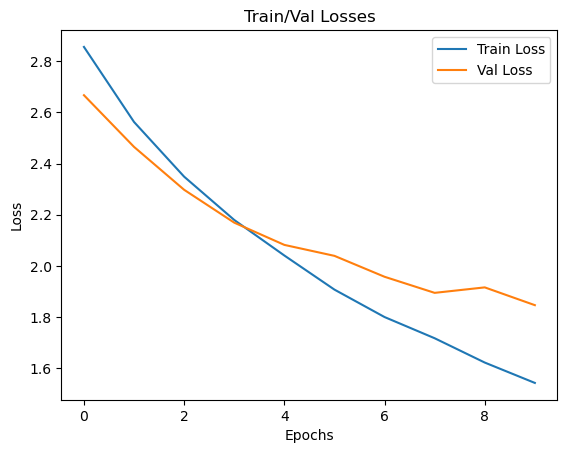

train_losses=[2.8562144187458776, 2.562598438987955, 2.348710068485193, 2.1793755348662884, 2.0404056108485884, 1.9069944578304625, 1.7997024735512093, 1.7168059321174844, 1.621713932494671, 1.5420626774865982]
[2.6673480226443362, 2.4652068248161902, 2.297417390805024, 2.168869681083239, 2.0819056194562178, 2.0390341717463274, 1.9572506145789073, 1.8943322323835814, 1.9157101328556354, 1.8461897040788944]
Training lr=0.01, w=0.0001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 110.64it/s]

Epoch [1/10], Train Loss: 2.8328, Train Accuracy: 11.34%, Val Loss: 2.5700, Val Accuracy: 19.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.22it/s]

Epoch [2/10], Train Loss: 2.4861, Train Accuracy: 20.85%, Val Loss: 2.3079, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.93it/s]

Epoch [3/10], Train Loss: 2.2032, Train Accuracy: 29.19%, Val Loss: 2.2090, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.64it/s]

Epoch [4/10], Train Loss: 2.0451, Train Accuracy: 35.19%, Val Loss: 2.1205, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.07it/s]

Epoch [5/10], Train Loss: 1.9163, Train Accuracy: 38.33%, Val Loss: 1.9718, Val Accuracy: 37.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.05it/s]

Epoch [6/10], Train Loss: 1.8001, Train Accuracy: 42.28%, Val Loss: 1.8545, Val Accuracy: 40.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.19it/s]

Epoch [7/10], Train Loss: 1.6463, Train Accuracy: 48.21%, Val Loss: 2.0451, Val Accuracy: 34.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.25it/s]

Epoch [8/10], Train Loss: 1.5280, Train Accuracy: 51.43%, Val Loss: 2.1247, Val Accuracy: 36.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.49it/s]

Epoch [9/10], Train Loss: 1.4451, Train Accuracy: 52.60%, Val Loss: 1.9378, Val Accuracy: 41.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.47it/s]

Epoch [10/10], Train Loss: 1.3293, Train Accuracy: 56.84%, Val Loss: 1.9090, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 68.36it/s]


Test Accuracy with learning rate 0.01: 40.91%


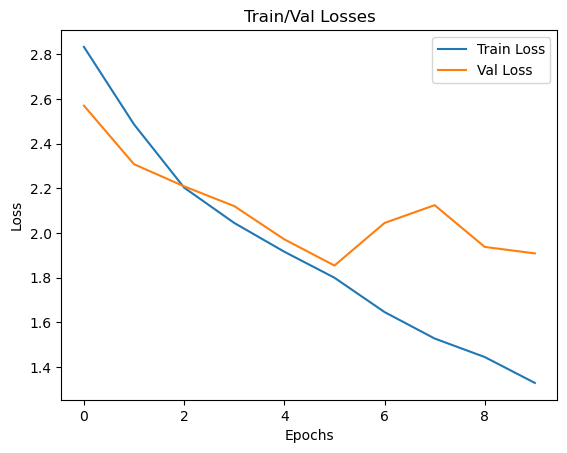

train_losses=[2.8328188859928423, 2.486054018924111, 2.2031820928841306, 2.045108896598481, 1.9162562266427872, 1.800052439260204, 1.6463209045560736, 1.52796084769288, 1.4450838016836267, 1.3293121671467496]
[2.570000336720393, 2.3078555969091563, 2.2089527249336243, 2.1205265820026398, 1.9717772603034973, 1.8545480966567993, 2.0451364540136776, 2.1247338262888102, 1.9378104886183372, 1.9089761869265482]
Training lr=0.01, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 104.64it/s]

Epoch [1/10], Train Loss: 2.8173, Train Accuracy: 11.78%, Val Loss: 2.6425, Val Accuracy: 13.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.89it/s]

Epoch [2/10], Train Loss: 2.4574, Train Accuracy: 21.65%, Val Loss: 2.6433, Val Accuracy: 18.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.17it/s]

Epoch [3/10], Train Loss: 2.2376, Train Accuracy: 28.09%, Val Loss: 2.1919, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.52it/s]

Epoch [4/10], Train Loss: 2.0028, Train Accuracy: 34.89%, Val Loss: 2.0982, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.03it/s]

Epoch [5/10], Train Loss: 1.8876, Train Accuracy: 39.36%, Val Loss: 1.8269, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.45it/s]

Epoch [6/10], Train Loss: 1.7740, Train Accuracy: 43.45%, Val Loss: 2.3000, Val Accuracy: 30.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.36it/s]

Epoch [7/10], Train Loss: 1.6129, Train Accuracy: 47.11%, Val Loss: 2.0380, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.55it/s]

Epoch [8/10], Train Loss: 1.5195, Train Accuracy: 50.18%, Val Loss: 1.9462, Val Accuracy: 43.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.46it/s]

Epoch [9/10], Train Loss: 1.3987, Train Accuracy: 53.40%, Val Loss: 1.9567, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.65it/s]

Epoch [10/10], Train Loss: 1.2990, Train Accuracy: 56.91%, Val Loss: 1.9171, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 67.18it/s]


Test Accuracy with learning rate 0.01: 38.64%


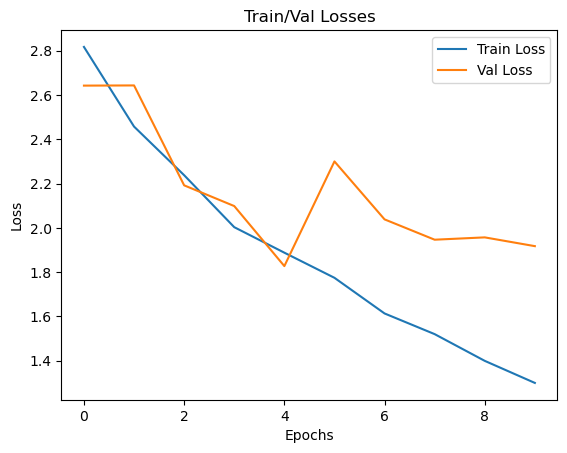

train_losses=[2.8173354104248403, 2.4574075602648553, 2.2376175428691663, 2.0027849876392656, 1.8875707963056731, 1.7740149926721005, 1.6129314948243705, 1.519488026872713, 1.398711883882333, 1.299006665484947]
[2.6424839817560635, 2.6433101090101094, 2.1918568977942834, 2.098195199783032, 1.8269075582233758, 2.2999570759443135, 2.0380387558386874, 1.9461903824256017, 1.9566866709635808, 1.9170665248082235]
Training lr=0.01, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 96.59it/s] 

Epoch [1/10], Train Loss: 2.8064, Train Accuracy: 12.44%, Val Loss: 2.5802, Val Accuracy: 17.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.16it/s]

Epoch [2/10], Train Loss: 2.4782, Train Accuracy: 21.73%, Val Loss: 2.3190, Val Accuracy: 27.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.28it/s]

Epoch [3/10], Train Loss: 2.2604, Train Accuracy: 28.97%, Val Loss: 2.2309, Val Accuracy: 22.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.17it/s]

Epoch [4/10], Train Loss: 2.0941, Train Accuracy: 34.60%, Val Loss: 2.6283, Val Accuracy: 18.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.36it/s]

Epoch [5/10], Train Loss: 1.9144, Train Accuracy: 38.92%, Val Loss: 1.9616, Val Accuracy: 37.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.04it/s]

Epoch [6/10], Train Loss: 1.7193, Train Accuracy: 44.77%, Val Loss: 1.7670, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.13it/s]

Epoch [7/10], Train Loss: 1.7799, Train Accuracy: 43.31%, Val Loss: 1.8809, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.89it/s]

Epoch [8/10], Train Loss: 1.6214, Train Accuracy: 48.72%, Val Loss: 1.8369, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.56it/s]

Epoch [9/10], Train Loss: 1.5122, Train Accuracy: 51.65%, Val Loss: 1.8394, Val Accuracy: 41.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.43it/s]

Epoch [10/10], Train Loss: 1.4384, Train Accuracy: 54.35%, Val Loss: 1.7930, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.70it/s]


Test Accuracy with learning rate 0.01: 39.77%


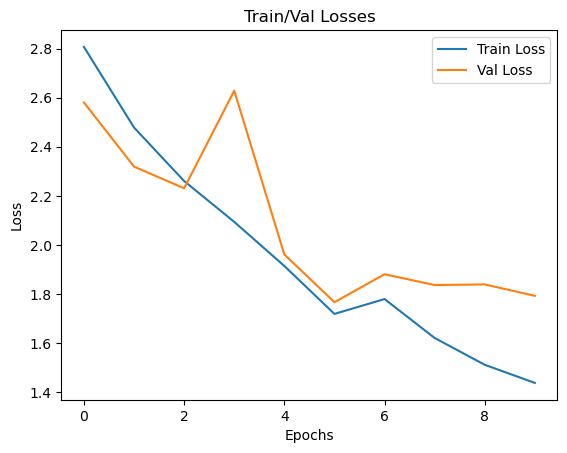

train_losses=[2.806439769198323, 2.4781539893289755, 2.2603904838450473, 2.094076777062221, 1.9144111927489789, 1.7193303177928367, 1.7798853230755232, 1.6213531996074475, 1.512205301669606, 1.438391306421213]
[2.580204202578618, 2.3190086644429426, 2.230875762609335, 2.6283173102598925, 1.9616182629878705, 1.7670090106817393, 1.8809243876200457, 1.8369319095061376, 1.8394356966018677, 1.792976778287154]
Training lr=0.001, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 109.65it/s]

Epoch [1/10], Train Loss: 29.7073, Train Accuracy: 5.34%, Val Loss: 2.9928, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.02it/s]

Epoch [2/10], Train Loss: 3.5278, Train Accuracy: 5.19%, Val Loss: 2.9607, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.04it/s]

Epoch [3/10], Train Loss: 2.9411, Train Accuracy: 8.85%, Val Loss: 4.3163, Val Accuracy: 10.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.94it/s]

Epoch [4/10], Train Loss: 2.8462, Train Accuracy: 10.75%, Val Loss: 2.6645, Val Accuracy: 15.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.73it/s]

Epoch [5/10], Train Loss: 2.7958, Train Accuracy: 15.14%, Val Loss: 2.6426, Val Accuracy: 10.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.81it/s]

Epoch [6/10], Train Loss: 2.9772, Train Accuracy: 15.36%, Val Loss: 3.9419, Val Accuracy: 9.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.86it/s]

Epoch [7/10], Train Loss: 3.3477, Train Accuracy: 16.39%, Val Loss: 2.5825, Val Accuracy: 14.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.02it/s]

Epoch [8/10], Train Loss: 2.9940, Train Accuracy: 17.04%, Val Loss: 3.0983, Val Accuracy: 13.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.89it/s]

Epoch [9/10], Train Loss: 3.1589, Train Accuracy: 18.00%, Val Loss: 2.4110, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.43it/s]

Epoch [10/10], Train Loss: 3.1491, Train Accuracy: 20.78%, Val Loss: 2.5710, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.10it/s]


Test Accuracy with learning rate 0.001: 15.91%


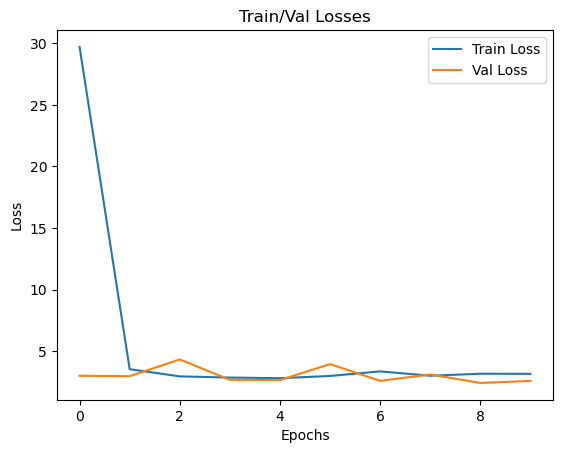

train_losses=[29.707250164266217, 3.5277953245486433, 2.9411418884121185, 2.8462015362510904, 2.7958012700778, 2.9772320727855837, 3.3477489585764926, 2.993981923276221, 3.1588529550541216, 3.1491478346941766]
[2.992759250677549, 2.9607331982025733, 4.316341899908506, 2.664537924986619, 2.6426234199450565, 3.94185425226505, 2.5824997149980984, 3.0982529933636007, 2.411017793875474, 2.570986983867792]
Training lr=0.001, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 106.97it/s]

Epoch [1/10], Train Loss: 31.3532, Train Accuracy: 7.90%, Val Loss: 2.8025, Val Accuracy: 15.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.46it/s]

Epoch [2/10], Train Loss: 3.1427, Train Accuracy: 12.95%, Val Loss: 2.6338, Val Accuracy: 12.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.90it/s]

Epoch [3/10], Train Loss: 2.9859, Train Accuracy: 13.39%, Val Loss: 2.6738, Val Accuracy: 10.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.29it/s]

Epoch [4/10], Train Loss: 3.0587, Train Accuracy: 14.34%, Val Loss: 2.5033, Val Accuracy: 21.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.84it/s]

Epoch [5/10], Train Loss: 2.9805, Train Accuracy: 17.78%, Val Loss: 2.4427, Val Accuracy: 16.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.70it/s]

Epoch [6/10], Train Loss: 3.2396, Train Accuracy: 17.92%, Val Loss: 7.3660, Val Accuracy: 13.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.45it/s]

Epoch [7/10], Train Loss: 3.1672, Train Accuracy: 17.63%, Val Loss: 5.0797, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.76it/s]

Epoch [8/10], Train Loss: 2.7759, Train Accuracy: 19.53%, Val Loss: 2.2725, Val Accuracy: 26.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.89it/s]

Epoch [9/10], Train Loss: 2.5982, Train Accuracy: 22.46%, Val Loss: 2.3801, Val Accuracy: 20.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.39it/s]

Epoch [10/10], Train Loss: 2.4253, Train Accuracy: 21.29%, Val Loss: 2.7554, Val Accuracy: 17.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.58it/s]


Test Accuracy with learning rate 0.001: 21.02%


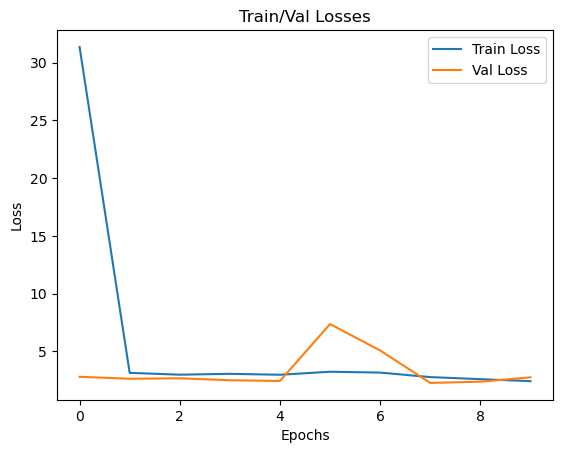

train_losses=[31.353188741973966, 3.1427319928219446, 2.985949260449549, 3.05871045519734, 2.9805445371315495, 3.239644271588465, 3.1672005583668312, 2.7759380675198737, 2.5981622481206705, 2.4253419616766143]
[2.802523842224708, 2.6338180853770328, 2.6738201563174906, 2.50332965529882, 2.442658312045611, 7.3659926286110515, 5.079662102919358, 2.272485237855178, 2.3800528920613804, 2.7554156528069425]
Training lr=0.001, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 109.83it/s]

Epoch [1/10], Train Loss: 31.7315, Train Accuracy: 7.02%, Val Loss: 5.1862, Val Accuracy: 10.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.95it/s]

Epoch [2/10], Train Loss: 4.4502, Train Accuracy: 7.02%, Val Loss: 2.8103, Val Accuracy: 6.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.38it/s]

Epoch [3/10], Train Loss: 3.6121, Train Accuracy: 6.95%, Val Loss: 2.8137, Val Accuracy: 10.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.62it/s]

Epoch [4/10], Train Loss: 3.5212, Train Accuracy: 8.49%, Val Loss: 2.7916, Val Accuracy: 10.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.52it/s]

Epoch [5/10], Train Loss: 3.0268, Train Accuracy: 7.68%, Val Loss: 3.3659, Val Accuracy: 6.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.80it/s]

Epoch [6/10], Train Loss: 3.3455, Train Accuracy: 9.80%, Val Loss: 2.8363, Val Accuracy: 13.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.71it/s]

Epoch [7/10], Train Loss: 3.0936, Train Accuracy: 9.29%, Val Loss: 2.7953, Val Accuracy: 14.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.22it/s]

Epoch [8/10], Train Loss: 2.9018, Train Accuracy: 10.39%, Val Loss: 2.7622, Val Accuracy: 13.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.44it/s]

Epoch [9/10], Train Loss: 2.7884, Train Accuracy: 10.68%, Val Loss: 2.9272, Val Accuracy: 10.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.48it/s]

Epoch [10/10], Train Loss: 2.7949, Train Accuracy: 10.68%, Val Loss: 3.2346, Val Accuracy: 10.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.40it/s]


Test Accuracy with learning rate 0.001: 5.68%


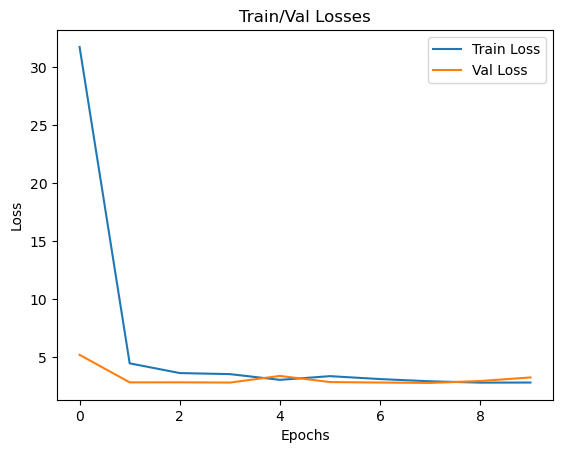

train_losses=[31.73151811939931, 4.450199318210981, 3.612136967698036, 3.5212297300149125, 3.026814976630852, 3.3454513786829008, 3.0936326088263972, 2.901769969895569, 2.788386997423674, 2.7949482697492454]
[5.186215817928314, 2.810256513265463, 2.8136891493430505, 2.791624041704031, 3.3659108510384192, 2.836277585763198, 2.7953486075768104, 2.762234119268564, 2.9272276621598463, 3.234552942789518]
Training lr=0.01, w=0.0001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 110.28it/s]

Epoch [1/10], Train Loss: 1279.5259, Train Accuracy: 5.12%, Val Loss: 3.0076, Val Accuracy: 8.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.81it/s]

Epoch [2/10], Train Loss: 21.7986, Train Accuracy: 6.51%, Val Loss: 3.0005, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.28it/s]

Epoch [3/10], Train Loss: 23.1056, Train Accuracy: 6.22%, Val Loss: 2.9972, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.39it/s]

Epoch [4/10], Train Loss: 71.2511, Train Accuracy: 6.66%, Val Loss: 2.9961, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.06it/s]

Epoch [5/10], Train Loss: 22.1744, Train Accuracy: 6.44%, Val Loss: 3.0147, Val Accuracy: 9.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.41it/s]

Epoch [6/10], Train Loss: 32.9994, Train Accuracy: 6.07%, Val Loss: 3.0090, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.13it/s]

Epoch [7/10], Train Loss: 33.9968, Train Accuracy: 6.44%, Val Loss: 3.0053, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.85it/s]

Epoch [8/10], Train Loss: 57.9133, Train Accuracy: 4.75%, Val Loss: 3.0351, Val Accuracy: 9.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.86it/s]

Epoch [9/10], Train Loss: 132.9430, Train Accuracy: 6.51%, Val Loss: 3.0374, Val Accuracy: 3.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.68it/s]

Epoch [10/10], Train Loss: 36.1817, Train Accuracy: 5.71%, Val Loss: 3.0269, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.74it/s]


Test Accuracy with learning rate 0.01: 6.25%


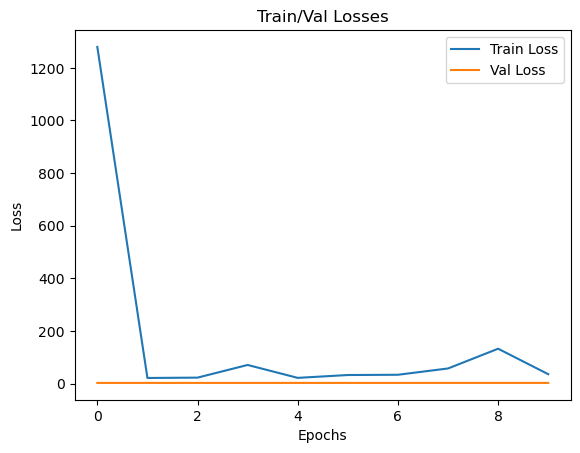

train_losses=[1279.5258565018748, 21.798566317697716, 23.105646780359816, 71.25109430642156, 22.174421115228306, 32.999400431649725, 33.99678789244758, 57.91329552695068, 132.94295108527467, 36.181682245076054]
[3.007612998668964, 3.00053831247183, 2.9972005440638614, 2.9961192791278544, 3.014715313911438, 3.0089985636564403, 3.0053043365478516, 3.0350578289765577, 3.0373722177285414, 3.026930891550504]
Training lr=0.01, w=0.001, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 109.58it/s]

Epoch [1/10], Train Loss: 1389.8628, Train Accuracy: 5.41%, Val Loss: 625.2905, Val Accuracy: 4.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.17it/s]

Epoch [2/10], Train Loss: 123.2651, Train Accuracy: 6.14%, Val Loss: 3.0248, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.93it/s]

Epoch [3/10], Train Loss: 36.0483, Train Accuracy: 5.34%, Val Loss: 3.0090, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.50it/s]

Epoch [4/10], Train Loss: 28.7366, Train Accuracy: 5.27%, Val Loss: 3.0047, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.08it/s]

Epoch [5/10], Train Loss: 28.6479, Train Accuracy: 5.27%, Val Loss: 3.0023, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.78it/s] 

Epoch [6/10], Train Loss: 83.5767, Train Accuracy: 5.49%, Val Loss: 3.0070, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 85.57it/s]

Epoch [7/10], Train Loss: 39.6057, Train Accuracy: 5.56%, Val Loss: 2.9978, Val Accuracy: 6.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.81it/s]

Epoch [8/10], Train Loss: 62.2041, Train Accuracy: 5.34%, Val Loss: 2.9997, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.80it/s]

Epoch [9/10], Train Loss: 35.4606, Train Accuracy: 5.27%, Val Loss: 2.9997, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.74it/s]

Epoch [10/10], Train Loss: 11.5082, Train Accuracy: 6.07%, Val Loss: 2.9968, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.49it/s]


Test Accuracy with learning rate 0.01: 6.25%


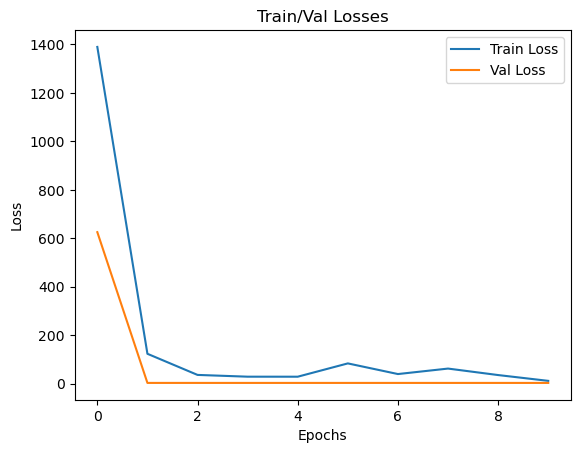

train_losses=[1389.8627622838605, 123.26513129368163, 36.04825535712884, 28.736589090168824, 28.647945945025885, 83.57668637392814, 39.605703045750225, 62.204057358858876, 35.4605520371108, 11.50816676072907]
[625.2905085637019, 3.0248129963874817, 3.009030736409701, 3.0047389635672936, 3.002311362670018, 3.0070499502695522, 2.9977716895250173, 2.9996794829001794, 2.9996724082873416, 2.996798414450425]
Training lr=0.01, w=0.01, opt=<class 'torch.optim.rmsprop.RMSprop'>


100%|██████████| 52/52 [00:00<00:00, 103.44it/s]

Epoch [1/10], Train Loss: 1775.8464, Train Accuracy: 4.39%, Val Loss: 3.0893, Val Accuracy: 3.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.01it/s]

Epoch [2/10], Train Loss: 93.6622, Train Accuracy: 5.34%, Val Loss: 3.0120, Val Accuracy: 3.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.78it/s]

Epoch [3/10], Train Loss: 39.7504, Train Accuracy: 5.19%, Val Loss: 3.0113, Val Accuracy: 4.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.70it/s] 

Epoch [4/10], Train Loss: 80.8954, Train Accuracy: 4.97%, Val Loss: 3.0159, Val Accuracy: 4.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 90.19it/s] 

Epoch [5/10], Train Loss: 64.3922, Train Accuracy: 4.17%, Val Loss: 3.0209, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.69it/s]

Epoch [6/10], Train Loss: 83.6324, Train Accuracy: 4.75%, Val Loss: 3.0384, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.46it/s]

Epoch [7/10], Train Loss: 33.4199, Train Accuracy: 5.56%, Val Loss: 3.0138, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.57it/s]

Epoch [8/10], Train Loss: 7.5517, Train Accuracy: 5.41%, Val Loss: 3.0026, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.79it/s]

Epoch [9/10], Train Loss: 9.7265, Train Accuracy: 6.00%, Val Loss: 2.9978, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.69it/s]

Epoch [10/10], Train Loss: 20.5233, Train Accuracy: 5.41%, Val Loss: 2.9964, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.18it/s]


Test Accuracy with learning rate 0.01: 6.25%


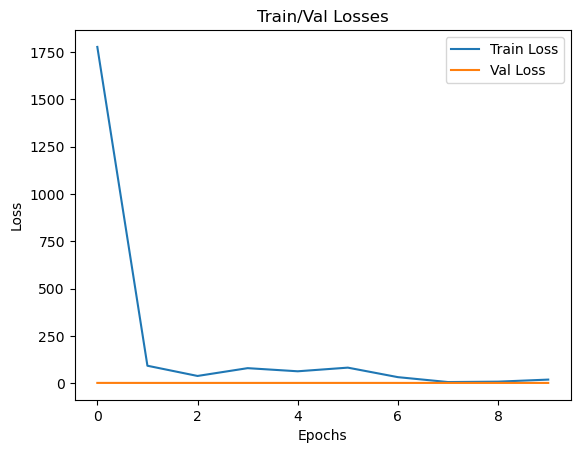

train_losses=[1775.8464156967855, 93.66222781186913, 39.75035807403208, 80.89535980475576, 64.39222853504427, 83.63239660458258, 33.4198992670628, 7.551705202861139, 9.72649405992519, 20.523252965414034]
[3.0893026086000295, 3.0119754259402933, 3.0113123059272766, 3.0158745554777293, 3.0208630836926975, 3.0383892884621253, 3.01375399186061, 3.002649953732124, 2.997760933179122, 2.9963611777012167]
Training lr=0.001, w=0.0001, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 109.29it/s]

Epoch [1/10], Train Loss: 8.3556, Train Accuracy: 11.92%, Val Loss: 2.5808, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.90it/s]

Epoch [2/10], Train Loss: 2.4592, Train Accuracy: 22.97%, Val Loss: 2.3814, Val Accuracy: 26.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.68it/s]

Epoch [3/10], Train Loss: 2.1452, Train Accuracy: 31.09%, Val Loss: 2.2556, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.32it/s]

Epoch [4/10], Train Loss: 2.0752, Train Accuracy: 31.60%, Val Loss: 2.2124, Val Accuracy: 26.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.36it/s]

Epoch [5/10], Train Loss: 1.9372, Train Accuracy: 36.65%, Val Loss: 2.1932, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.28it/s]

Epoch [6/10], Train Loss: 1.8036, Train Accuracy: 39.36%, Val Loss: 2.1321, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.46it/s]

Epoch [7/10], Train Loss: 1.7249, Train Accuracy: 41.99%, Val Loss: 2.0384, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.45it/s]

Epoch [8/10], Train Loss: 1.6407, Train Accuracy: 45.06%, Val Loss: 1.9453, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.31it/s]

Epoch [9/10], Train Loss: 1.5486, Train Accuracy: 48.65%, Val Loss: 1.9786, Val Accuracy: 40.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.28it/s]

Epoch [10/10], Train Loss: 1.5139, Train Accuracy: 48.57%, Val Loss: 2.3284, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.42it/s]


Test Accuracy with learning rate 0.001: 36.36%


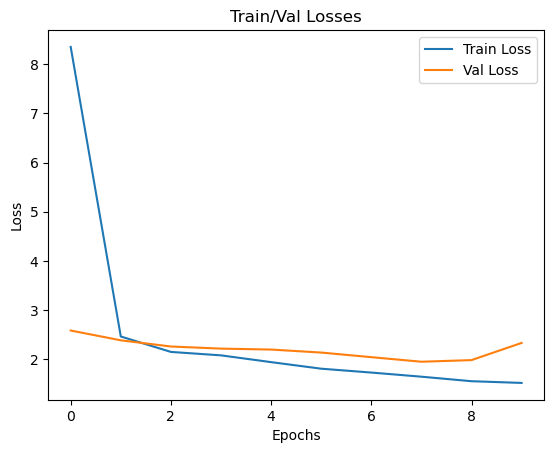

train_losses=[8.3555936618158, 2.4591896715219956, 2.1452489937955175, 2.0751505671885977, 1.9371840563433909, 1.803642241229788, 1.7248790260643987, 1.6407348422976265, 1.5486206727766851, 1.5138968752141584]
[2.580796468716401, 2.3814276433908024, 2.255574242426799, 2.212369742301794, 2.193156822369649, 2.1320605965761037, 2.0383948408640347, 1.9453132530817618, 1.9785991975894341, 2.3284227068607626]
Training lr=0.001, w=0.001, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 106.21it/s]

Epoch [1/10], Train Loss: 7.7436, Train Accuracy: 11.19%, Val Loss: 2.7394, Val Accuracy: 11.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.93it/s]

Epoch [2/10], Train Loss: 2.6829, Train Accuracy: 15.07%, Val Loss: 2.6428, Val Accuracy: 17.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.59it/s]

Epoch [3/10], Train Loss: 2.5018, Train Accuracy: 19.17%, Val Loss: 2.5345, Val Accuracy: 20.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.26it/s]

Epoch [4/10], Train Loss: 2.3136, Train Accuracy: 24.65%, Val Loss: 2.3585, Val Accuracy: 25.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.84it/s]

Epoch [5/10], Train Loss: 2.1868, Train Accuracy: 28.09%, Val Loss: 2.2010, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 85.74it/s]

Epoch [6/10], Train Loss: 2.0513, Train Accuracy: 30.94%, Val Loss: 2.2508, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.43it/s]

Epoch [7/10], Train Loss: 1.9968, Train Accuracy: 32.85%, Val Loss: 2.1851, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.06it/s]

Epoch [8/10], Train Loss: 1.9681, Train Accuracy: 34.24%, Val Loss: 2.2426, Val Accuracy: 26.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.81it/s]

Epoch [9/10], Train Loss: 1.8148, Train Accuracy: 40.82%, Val Loss: 2.1712, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.11it/s]

Epoch [10/10], Train Loss: 1.7372, Train Accuracy: 41.26%, Val Loss: 2.1965, Val Accuracy: 29.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.33it/s]


Test Accuracy with learning rate 0.001: 33.52%


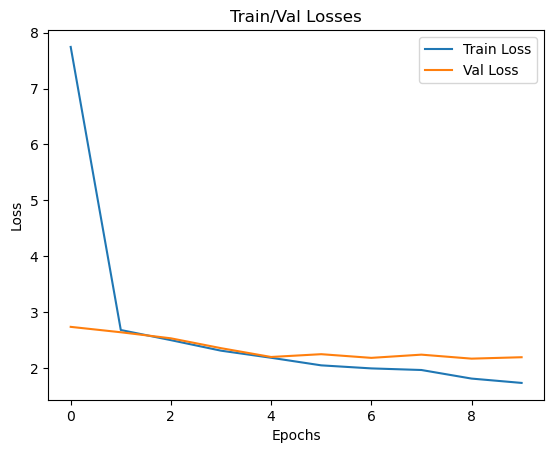

train_losses=[7.743645428216945, 2.682896851796156, 2.501770621851871, 2.3135985624023347, 2.1868150004169395, 2.0512665691431504, 1.9967572218493412, 1.9681400255850183, 1.8148227693044652, 1.7371700085394564]
[2.7393730649581323, 2.6428331778599667, 2.5345401901465197, 2.3585242743675527, 2.200961117561047, 2.2508131563663483, 2.185080505334414, 2.242573034304839, 2.1712160477271447, 2.19647000844662]
Training lr=0.001, w=0.01, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 104.06it/s]

Epoch [1/10], Train Loss: 7.1532, Train Accuracy: 12.58%, Val Loss: 3.0724, Val Accuracy: 14.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.62it/s]

Epoch [2/10], Train Loss: 2.8730, Train Accuracy: 17.56%, Val Loss: 3.2134, Val Accuracy: 16.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.11it/s]

Epoch [3/10], Train Loss: 2.6978, Train Accuracy: 21.58%, Val Loss: 2.7816, Val Accuracy: 25.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.23it/s]

Epoch [4/10], Train Loss: 2.5076, Train Accuracy: 25.53%, Val Loss: 2.3836, Val Accuracy: 26.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.26it/s]

Epoch [5/10], Train Loss: 2.4011, Train Accuracy: 25.16%, Val Loss: 2.1754, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.59it/s]

Epoch [6/10], Train Loss: 2.2739, Train Accuracy: 29.99%, Val Loss: 2.5748, Val Accuracy: 20.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.94it/s]

Epoch [7/10], Train Loss: 2.2333, Train Accuracy: 31.24%, Val Loss: 2.7985, Val Accuracy: 25.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.82it/s]

Epoch [8/10], Train Loss: 2.2672, Train Accuracy: 31.89%, Val Loss: 2.8475, Val Accuracy: 28.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.07it/s]

Epoch [9/10], Train Loss: 2.2093, Train Accuracy: 32.70%, Val Loss: 2.9252, Val Accuracy: 27.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.98it/s]

Epoch [10/10], Train Loss: 2.3374, Train Accuracy: 31.60%, Val Loss: 2.0586, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.18it/s]


Test Accuracy with learning rate 0.001: 28.41%


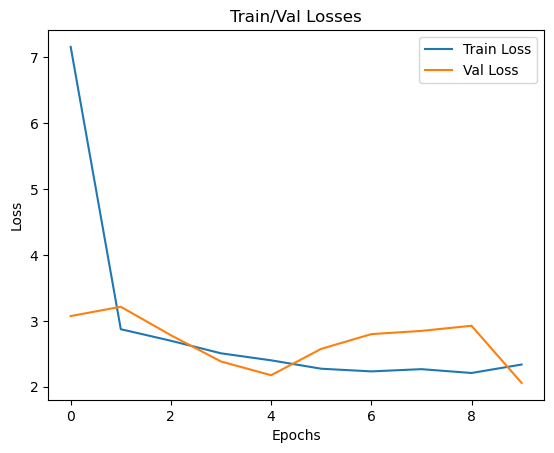

train_losses=[7.153234265701116, 2.872964209980435, 2.6978226851301583, 2.5076120903617456, 2.4011051459619175, 2.2739369464896577, 2.2333474591461537, 2.267195261012741, 2.209250973679169, 2.337406111390967]
[3.0723677369264455, 3.2133814073525944, 2.781596202116746, 2.3835563361644745, 2.1754033863544464, 2.5747896432876587, 2.7984600388086758, 2.8475029399761786, 2.9251899925562053, 2.058550626039505]
Training lr=0.01, w=0.0001, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 105.94it/s]

Epoch [1/10], Train Loss: 38.9978, Train Accuracy: 5.34%, Val Loss: 2.9950, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.23it/s] 

Epoch [2/10], Train Loss: 3.1652, Train Accuracy: 4.75%, Val Loss: 3.0009, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.07it/s]

Epoch [3/10], Train Loss: 3.0048, Train Accuracy: 5.41%, Val Loss: 2.9996, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.01it/s]

Epoch [4/10], Train Loss: 3.2986, Train Accuracy: 6.07%, Val Loss: 3.0035, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.71it/s]

Epoch [5/10], Train Loss: 3.3689, Train Accuracy: 5.56%, Val Loss: 3.0029, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.61it/s]

Epoch [6/10], Train Loss: 3.3386, Train Accuracy: 5.63%, Val Loss: 3.0007, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.13it/s]

Epoch [7/10], Train Loss: 3.2613, Train Accuracy: 6.14%, Val Loss: 3.0010, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.98it/s]

Epoch [8/10], Train Loss: 5.3598, Train Accuracy: 6.29%, Val Loss: 2.9997, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.10it/s]

Epoch [9/10], Train Loss: 7.1399, Train Accuracy: 5.56%, Val Loss: 3.4332, Val Accuracy: 4.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.10it/s]

Epoch [10/10], Train Loss: 5.8414, Train Accuracy: 5.12%, Val Loss: 3.0249, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 67.73it/s]


Test Accuracy with learning rate 0.01: 3.98%


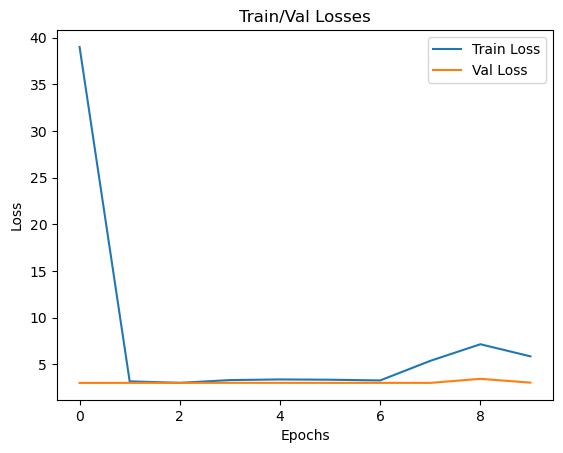

train_losses=[38.997788568686325, 3.165163903208504, 3.0048202952446297, 3.2986290385151467, 3.3688504918974047, 3.3386318139862596, 3.2612944932011834, 5.359779272860254, 7.1398859386555635, 5.84141761378238]
[2.9949600879962626, 3.000912982683915, 2.9996240735054016, 3.0035348397034864, 3.0029415167295017, 3.000717594073369, 3.000971014683063, 2.999697107535142, 3.4332124957671533, 3.0249374508857727]
Training lr=0.01, w=0.001, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 104.93it/s]

Epoch [1/10], Train Loss: 57.1778, Train Accuracy: 5.27%, Val Loss: 3.0009, Val Accuracy: 5.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.07it/s]

Epoch [2/10], Train Loss: 12.9625, Train Accuracy: 5.34%, Val Loss: 4.7165, Val Accuracy: 4.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.98it/s]

Epoch [3/10], Train Loss: 17.2008, Train Accuracy: 5.93%, Val Loss: 34.9824, Val Accuracy: 4.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.94it/s]

Epoch [4/10], Train Loss: 15.0864, Train Accuracy: 5.12%, Val Loss: 32.3438, Val Accuracy: 5.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.50it/s]

Epoch [5/10], Train Loss: 9.7534, Train Accuracy: 4.83%, Val Loss: 3.0377, Val Accuracy: 4.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.97it/s]

Epoch [6/10], Train Loss: 6.9271, Train Accuracy: 5.56%, Val Loss: 2.9993, Val Accuracy: 9.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.72it/s]

Epoch [7/10], Train Loss: 8.5043, Train Accuracy: 4.75%, Val Loss: 3.0153, Val Accuracy: 2.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.72it/s]

Epoch [8/10], Train Loss: 6.7267, Train Accuracy: 5.27%, Val Loss: 3.0072, Val Accuracy: 3.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.79it/s]

Epoch [9/10], Train Loss: 12.1551, Train Accuracy: 5.56%, Val Loss: 3.0059, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.71it/s]

Epoch [10/10], Train Loss: 10.1396, Train Accuracy: 5.63%, Val Loss: 3.0017, Val Accuracy: 5.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.84it/s]


Test Accuracy with learning rate 0.01: 2.84%


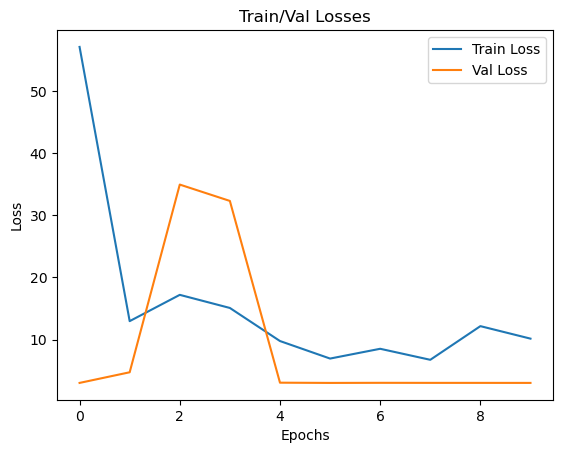

train_losses=[57.177825802250915, 12.962537814302054, 17.200817103971517, 15.086385432739704, 9.753406845338164, 6.92709751993592, 8.504285537708572, 6.726738234012448, 12.15508212541279, 10.139576497830843]
[3.0009324046281667, 4.716486137646895, 34.98237448472243, 32.34378546934862, 3.037715705541464, 2.9992883342963, 3.015277234407572, 3.007174184689155, 3.0058608100964475, 3.0017050229586086]
Training lr=0.01, w=0.01, opt=<class 'torch.optim.adam.Adam'>


100%|██████████| 52/52 [00:00<00:00, 103.56it/s]

Epoch [1/10], Train Loss: 163.4371, Train Accuracy: 5.71%, Val Loss: 274.3176, Val Accuracy: 5.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.12it/s]

Epoch [2/10], Train Loss: 176.8091, Train Accuracy: 4.61%, Val Loss: 278.1218, Val Accuracy: 3.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.52it/s]

Epoch [3/10], Train Loss: 151.0536, Train Accuracy: 5.41%, Val Loss: 227.1397, Val Accuracy: 5.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.00it/s]

Epoch [4/10], Train Loss: 64.6785, Train Accuracy: 4.46%, Val Loss: 3.9242, Val Accuracy: 6.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.61it/s]

Epoch [5/10], Train Loss: 17.5334, Train Accuracy: 4.61%, Val Loss: 3.0428, Val Accuracy: 3.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.93it/s]

Epoch [6/10], Train Loss: 16.9844, Train Accuracy: 4.97%, Val Loss: 57.3646, Val Accuracy: 3.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.75it/s]

Epoch [7/10], Train Loss: 32.6367, Train Accuracy: 4.97%, Val Loss: 3.0443, Val Accuracy: 3.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.64it/s]

Epoch [8/10], Train Loss: 70.5171, Train Accuracy: 5.12%, Val Loss: 3.0550, Val Accuracy: 3.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.65it/s]

Epoch [9/10], Train Loss: 83.2716, Train Accuracy: 4.90%, Val Loss: 214.8854, Val Accuracy: 3.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 81.85it/s] 

Epoch [10/10], Train Loss: 66.9585, Train Accuracy: 6.07%, Val Loss: 83.7066, Val Accuracy: 5.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.03it/s]


Test Accuracy with learning rate 0.01: 8.52%


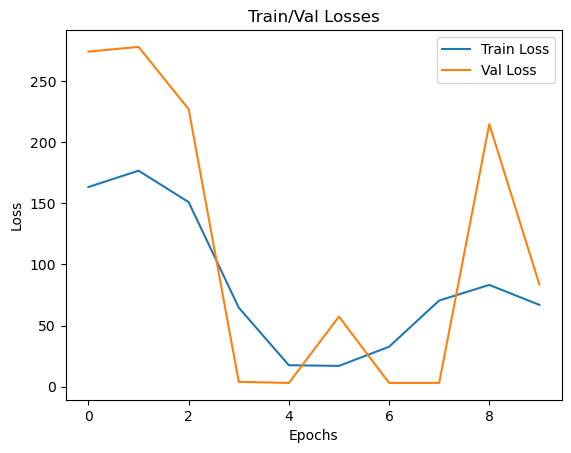

train_losses=[163.4370798116539, 176.8091276793452, 151.05357028726945, 64.67851381971126, 17.53340801439787, 16.984418609686067, 32.63666552130939, 70.51712947282178, 83.27156619718897, 66.95849038146393]
[274.3175582885742, 278.12179653461163, 227.13969069260818, 3.9242064448503347, 3.0427612295517554, 57.36460520670964, 3.044268410939437, 3.0549541253309984, 214.88535220806415, 83.70658757136418]


In [33]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Обучение модели
num_epochs = 10
weight_decay_list = [0.0001, 0.001, 0.01]
learning_rates = [0.001, 0.01] 
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]

for opt in optimizers:
    for lr in learning_rates:
        for w in weight_decay_list:
            # Определение модели
            model = MyClassificationNet(input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3, hidden_size=1024, output_size=20).to(device)
        
            print(f"Training {lr=}, {w=}, {opt=}")
            train_losses, val_losses, res = train(model, opt, train_data_loader, val_data_loader, num_epochs, lr, weight_decay=w, res=res)
        
            # Оценка качества модели на тестовой выборке
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
                    images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            print(f"Test Accuracy with learning rate {lr}: {100 * accuracy:.2f}%")
        
            # 6. Анализ графиков train/val loss
            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses')
            plt.legend()
            plt.show()
            
            print(f"{train_losses=}\n{val_losses}")

In [34]:
res

,optimizer,learning_rate,weight_decay,val_accuracy
0,SGD,0.001,0.0001,0.446341
0,SGD,0.001,0.0010,0.485366
0,SGD,0.001,0.0100,0.448780
0,SGD,0.010,0.0001,0.456098
0,SGD,0.010,0.0010,0.434146
0,SGD,0.010,0.0100,0.456098
0,RMSprop,0.001,0.0001,0.204878
0,RMSprop,0.001,0.0010,0.263415
0,RMSprop,0.001,0.0100,0.148780
0,RMSprop,0.010,0.0001,0.090244


## Retraining best on 50 epoch

If we analyze train/val loss graphics, we can see that Butterfly Classification Net can achieve bigger results.

Params lr=0.001, w=0.001, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 101.36it/s]

Epoch [1/50], Train Loss: 2.8634, Train Accuracy: 12.87%, Val Loss: 2.6708, Val Accuracy: 15.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.56it/s]

Epoch [2/50], Train Loss: 2.5711, Train Accuracy: 23.77%, Val Loss: 2.4801, Val Accuracy: 29.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.13it/s]

Epoch [3/50], Train Loss: 2.3585, Train Accuracy: 30.80%, Val Loss: 2.3329, Val Accuracy: 30.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.48it/s]

Epoch [4/50], Train Loss: 2.1850, Train Accuracy: 37.97%, Val Loss: 2.1525, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.41it/s]

Epoch [5/50], Train Loss: 2.0355, Train Accuracy: 40.75%, Val Loss: 2.1281, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.46it/s]

Epoch [6/50], Train Loss: 1.9190, Train Accuracy: 44.77%, Val Loss: 1.9985, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.91it/s]

Epoch [7/50], Train Loss: 1.7981, Train Accuracy: 50.48%, Val Loss: 2.0588, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.28it/s]

Epoch [8/50], Train Loss: 1.7079, Train Accuracy: 51.06%, Val Loss: 1.8616, Val Accuracy: 49.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.45it/s]

Epoch [9/50], Train Loss: 1.6197, Train Accuracy: 54.65%, Val Loss: 1.8686, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.82it/s]

Epoch [10/50], Train Loss: 1.5631, Train Accuracy: 56.47%, Val Loss: 1.8399, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.73it/s] 

Epoch [11/50], Train Loss: 1.4680, Train Accuracy: 61.67%, Val Loss: 1.8006, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.93it/s]

Epoch [12/50], Train Loss: 1.4044, Train Accuracy: 60.72%, Val Loss: 1.7995, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.74it/s]

Epoch [13/50], Train Loss: 1.3373, Train Accuracy: 63.57%, Val Loss: 1.7525, Val Accuracy: 47.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.13it/s]

Epoch [14/50], Train Loss: 1.2826, Train Accuracy: 64.16%, Val Loss: 1.7035, Val Accuracy: 47.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.72it/s]

Epoch [15/50], Train Loss: 1.2233, Train Accuracy: 66.72%, Val Loss: 1.7947, Val Accuracy: 46.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.84it/s]

Epoch [16/50], Train Loss: 1.1701, Train Accuracy: 69.79%, Val Loss: 1.7755, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.42it/s]

Epoch [17/50], Train Loss: 1.1236, Train Accuracy: 70.96%, Val Loss: 1.7881, Val Accuracy: 47.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.95it/s]

Epoch [18/50], Train Loss: 1.0787, Train Accuracy: 72.93%, Val Loss: 1.6644, Val Accuracy: 48.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.66it/s]

Epoch [19/50], Train Loss: 1.0290, Train Accuracy: 74.03%, Val Loss: 1.6338, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.34it/s]

Epoch [20/50], Train Loss: 0.9785, Train Accuracy: 75.27%, Val Loss: 1.6320, Val Accuracy: 48.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.90it/s]

Epoch [21/50], Train Loss: 0.9327, Train Accuracy: 77.25%, Val Loss: 1.6615, Val Accuracy: 51.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.03it/s]

Epoch [22/50], Train Loss: 0.9033, Train Accuracy: 77.98%, Val Loss: 1.6202, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.17it/s]

Epoch [23/50], Train Loss: 0.8559, Train Accuracy: 80.40%, Val Loss: 1.6832, Val Accuracy: 50.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.80it/s]

Epoch [24/50], Train Loss: 0.8208, Train Accuracy: 81.71%, Val Loss: 1.6607, Val Accuracy: 50.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.90it/s]

Epoch [25/50], Train Loss: 0.7816, Train Accuracy: 82.74%, Val Loss: 1.5852, Val Accuracy: 51.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.89it/s] 

Epoch [26/50], Train Loss: 0.7474, Train Accuracy: 83.17%, Val Loss: 1.5280, Val Accuracy: 53.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 88.12it/s] 

Epoch [27/50], Train Loss: 0.7114, Train Accuracy: 84.05%, Val Loss: 1.6096, Val Accuracy: 49.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.41it/s]

Epoch [28/50], Train Loss: 0.6836, Train Accuracy: 86.98%, Val Loss: 1.5955, Val Accuracy: 51.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.22it/s]

Epoch [29/50], Train Loss: 0.6617, Train Accuracy: 85.95%, Val Loss: 1.6130, Val Accuracy: 51.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.89it/s]

Epoch [30/50], Train Loss: 0.6211, Train Accuracy: 87.93%, Val Loss: 1.6512, Val Accuracy: 49.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.32it/s]

Epoch [31/50], Train Loss: 0.5924, Train Accuracy: 88.81%, Val Loss: 1.5619, Val Accuracy: 50.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.82it/s]

Epoch [32/50], Train Loss: 0.5725, Train Accuracy: 89.83%, Val Loss: 1.6159, Val Accuracy: 50.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.20it/s]

Epoch [33/50], Train Loss: 0.5453, Train Accuracy: 89.98%, Val Loss: 1.6141, Val Accuracy: 49.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.39it/s]

Epoch [34/50], Train Loss: 0.5239, Train Accuracy: 91.00%, Val Loss: 1.5831, Val Accuracy: 53.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.04it/s]

Epoch [35/50], Train Loss: 0.4915, Train Accuracy: 92.25%, Val Loss: 1.6737, Val Accuracy: 48.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.02it/s]

Epoch [36/50], Train Loss: 0.4756, Train Accuracy: 92.25%, Val Loss: 1.5660, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.87it/s] 

Epoch [37/50], Train Loss: 0.4517, Train Accuracy: 94.29%, Val Loss: 1.6173, Val Accuracy: 50.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.68it/s]

Epoch [38/50], Train Loss: 0.4252, Train Accuracy: 94.15%, Val Loss: 1.5727, Val Accuracy: 52.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.93it/s] 

Epoch [39/50], Train Loss: 0.4141, Train Accuracy: 94.29%, Val Loss: 1.6123, Val Accuracy: 49.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.77it/s]

Epoch [40/50], Train Loss: 0.3947, Train Accuracy: 95.03%, Val Loss: 1.5857, Val Accuracy: 51.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.51it/s]

Epoch [41/50], Train Loss: 0.3716, Train Accuracy: 95.32%, Val Loss: 1.5837, Val Accuracy: 50.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.52it/s]

Epoch [42/50], Train Loss: 0.3585, Train Accuracy: 95.54%, Val Loss: 1.5768, Val Accuracy: 51.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.20it/s]

Epoch [43/50], Train Loss: 0.3389, Train Accuracy: 96.27%, Val Loss: 1.5806, Val Accuracy: 50.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.21it/s] 

Epoch [44/50], Train Loss: 0.3269, Train Accuracy: 96.27%, Val Loss: 1.5585, Val Accuracy: 50.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.62it/s]

Epoch [45/50], Train Loss: 0.3119, Train Accuracy: 97.07%, Val Loss: 1.6227, Val Accuracy: 51.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.85it/s]

Epoch [46/50], Train Loss: 0.2962, Train Accuracy: 97.29%, Val Loss: 1.5872, Val Accuracy: 51.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.21it/s]

Epoch [47/50], Train Loss: 0.2872, Train Accuracy: 98.02%, Val Loss: 1.5708, Val Accuracy: 51.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.11it/s]

Epoch [48/50], Train Loss: 0.2757, Train Accuracy: 97.81%, Val Loss: 1.6617, Val Accuracy: 50.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.40it/s]

Epoch [49/50], Train Loss: 0.2627, Train Accuracy: 97.81%, Val Loss: 1.5796, Val Accuracy: 50.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.13it/s]

Epoch [50/50], Train Loss: 0.2505, Train Accuracy: 98.17%, Val Loss: 1.5981, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.29it/s]


Test Accuracy: 50.00%


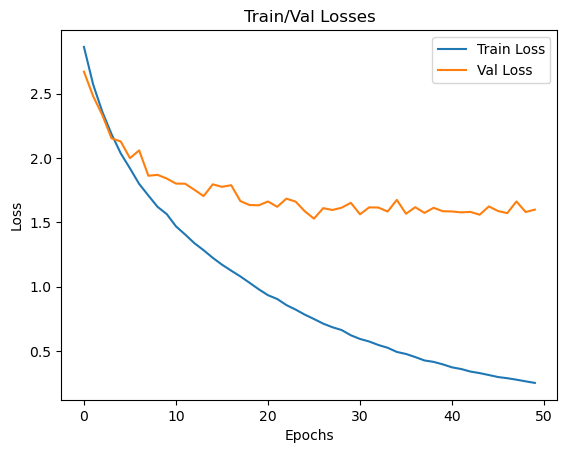

train_losses=[2.8634089419716284, 2.5711198863927383, 2.3584539228015475, 2.1850174295971967, 2.0354574256473117, 1.919039719983151, 1.798078189119261, 1.7079156588392648, 1.619724660937549, 1.563122981124454, 1.4680416043738873, 1.4044288414263586, 1.3372594452740854, 1.2826471130053203, 1.2232942753716518, 1.1701400325312252, 1.1235517256441172, 1.0786793320848231, 1.0289742788027603, 0.9785212679216039, 0.9326597607275199, 0.9033048231350748, 0.8558839918577184, 0.8208465788796632, 0.7815520197850222, 0.7473960937115184, 0.7114459785104496, 0.6835903865203523, 0.6616896470213494, 0.6210821659592857, 0.5923753948065272, 0.5724717907563984, 0.5453283318824935, 0.5239025694236421, 0.4915444364237507, 0.4756202877264971, 0.45168974237483844, 0.4251813088157024, 0.41408428506195893, 0.3946595112656989, 0.3715811576149617, 0.35846527204004647, 0.3388542973420076, 0.32686986299286114, 0.3118860719845309, 0.2962163270652643, 0.287193565602191, 0.27574989393527743, 0.2626969842185751, 0.2504

100%|██████████| 52/52 [00:00<00:00, 104.26it/s]

Epoch [1/50], Train Loss: 2.8133, Train Accuracy: 11.05%, Val Loss: 2.5320, Val Accuracy: 19.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.47it/s]

Epoch [2/50], Train Loss: 2.4393, Train Accuracy: 22.46%, Val Loss: 2.3384, Val Accuracy: 25.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.88it/s]

Epoch [3/50], Train Loss: 2.2605, Train Accuracy: 28.31%, Val Loss: 2.1441, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.67it/s]

Epoch [4/50], Train Loss: 2.0124, Train Accuracy: 35.84%, Val Loss: 2.4245, Val Accuracy: 28.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.44it/s] 

Epoch [5/50], Train Loss: 1.8972, Train Accuracy: 40.31%, Val Loss: 2.0786, Val Accuracy: 34.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.15it/s]

Epoch [6/50], Train Loss: 1.7837, Train Accuracy: 43.75%, Val Loss: 1.8537, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.22it/s] 

Epoch [7/50], Train Loss: 1.6495, Train Accuracy: 46.67%, Val Loss: 1.9445, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.13it/s]

Epoch [8/50], Train Loss: 1.5623, Train Accuracy: 48.87%, Val Loss: 2.1483, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.34it/s]

Epoch [9/50], Train Loss: 1.4503, Train Accuracy: 52.45%, Val Loss: 1.8415, Val Accuracy: 42.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.04it/s]

Epoch [10/50], Train Loss: 1.3315, Train Accuracy: 56.62%, Val Loss: 1.6025, Val Accuracy: 48.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.43it/s]

Epoch [11/50], Train Loss: 1.1857, Train Accuracy: 60.79%, Val Loss: 1.6900, Val Accuracy: 49.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.00it/s]

Epoch [12/50], Train Loss: 1.1547, Train Accuracy: 62.98%, Val Loss: 1.9039, Val Accuracy: 46.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.72it/s]

Epoch [13/50], Train Loss: 0.9808, Train Accuracy: 67.96%, Val Loss: 2.1352, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.15it/s]

Epoch [14/50], Train Loss: 0.8912, Train Accuracy: 69.93%, Val Loss: 2.6989, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.19it/s]

Epoch [15/50], Train Loss: 0.9124, Train Accuracy: 70.52%, Val Loss: 4.6925, Val Accuracy: 19.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.13it/s]

Epoch [16/50], Train Loss: 0.9475, Train Accuracy: 71.25%, Val Loss: 2.0081, Val Accuracy: 42.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.10it/s]

Epoch [17/50], Train Loss: 0.8376, Train Accuracy: 73.37%, Val Loss: 3.7176, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.41it/s]

Epoch [18/50], Train Loss: 0.8532, Train Accuracy: 74.84%, Val Loss: 3.1138, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.33it/s]


Epoch [19/50], Train Loss: 0.5856, Train Accuracy: 80.03%, Val Loss: 1.9696, Val Accuracy: 50.24%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.82it/s]

Epoch [20/50], Train Loss: 0.6171, Train Accuracy: 79.52%, Val Loss: 2.2877, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.46it/s]

Epoch [21/50], Train Loss: 0.5158, Train Accuracy: 85.37%, Val Loss: 2.1628, Val Accuracy: 46.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.60it/s]

Epoch [22/50], Train Loss: 0.3873, Train Accuracy: 87.49%, Val Loss: 2.0570, Val Accuracy: 50.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.16it/s]

Epoch [23/50], Train Loss: 0.3770, Train Accuracy: 88.51%, Val Loss: 1.8765, Val Accuracy: 49.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.31it/s]

Epoch [24/50], Train Loss: 0.2307, Train Accuracy: 93.49%, Val Loss: 2.0264, Val Accuracy: 48.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.54it/s]

Epoch [25/50], Train Loss: 0.4558, Train Accuracy: 88.30%, Val Loss: 1.9982, Val Accuracy: 49.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.89it/s]

Epoch [26/50], Train Loss: 0.2991, Train Accuracy: 89.76%, Val Loss: 2.0774, Val Accuracy: 47.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.83it/s]

Epoch [27/50], Train Loss: 0.4100, Train Accuracy: 87.86%, Val Loss: 2.3513, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.12it/s]

Epoch [28/50], Train Loss: 0.2264, Train Accuracy: 93.93%, Val Loss: 2.2349, Val Accuracy: 46.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.57it/s] 

Epoch [29/50], Train Loss: 0.0943, Train Accuracy: 97.29%, Val Loss: 5.7610, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.31it/s]

Epoch [30/50], Train Loss: 0.1688, Train Accuracy: 95.61%, Val Loss: 2.1143, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.44it/s]

Epoch [31/50], Train Loss: 0.1501, Train Accuracy: 96.12%, Val Loss: 2.1104, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.04it/s]

Epoch [32/50], Train Loss: 0.1530, Train Accuracy: 95.98%, Val Loss: 2.3263, Val Accuracy: 46.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.51it/s]

Epoch [33/50], Train Loss: 0.1590, Train Accuracy: 95.98%, Val Loss: 2.2767, Val Accuracy: 47.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.50it/s] 

Epoch [34/50], Train Loss: 0.2707, Train Accuracy: 92.83%, Val Loss: 2.3984, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.98it/s]

Epoch [35/50], Train Loss: 0.0803, Train Accuracy: 98.24%, Val Loss: 2.0905, Val Accuracy: 52.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.86it/s]

Epoch [36/50], Train Loss: 0.0506, Train Accuracy: 98.83%, Val Loss: 2.0644, Val Accuracy: 55.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.68it/s]

Epoch [37/50], Train Loss: 0.0279, Train Accuracy: 99.49%, Val Loss: 2.1327, Val Accuracy: 51.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.23it/s] 

Epoch [38/50], Train Loss: 0.0810, Train Accuracy: 98.24%, Val Loss: 2.3071, Val Accuracy: 50.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.49it/s]

Epoch [39/50], Train Loss: 0.0311, Train Accuracy: 99.12%, Val Loss: 2.1772, Val Accuracy: 54.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.37it/s] 

Epoch [40/50], Train Loss: 0.0234, Train Accuracy: 99.63%, Val Loss: 2.1275, Val Accuracy: 54.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.57it/s] 

Epoch [41/50], Train Loss: 0.0913, Train Accuracy: 97.73%, Val Loss: 2.2411, Val Accuracy: 52.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.09it/s]

Epoch [42/50], Train Loss: 0.0126, Train Accuracy: 99.93%, Val Loss: 2.2293, Val Accuracy: 54.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.93it/s]

Epoch [43/50], Train Loss: 0.0140, Train Accuracy: 99.71%, Val Loss: 2.2890, Val Accuracy: 52.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 90.35it/s]

Epoch [44/50], Train Loss: 0.0093, Train Accuracy: 100.00%, Val Loss: 2.2046, Val Accuracy: 53.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.64it/s]

Epoch [45/50], Train Loss: 0.0094, Train Accuracy: 99.85%, Val Loss: 2.3214, Val Accuracy: 51.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.34it/s]

Epoch [46/50], Train Loss: 0.0088, Train Accuracy: 99.93%, Val Loss: 2.2066, Val Accuracy: 54.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.61it/s]

Epoch [47/50], Train Loss: 0.0064, Train Accuracy: 100.00%, Val Loss: 2.2492, Val Accuracy: 53.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.28it/s]

Epoch [48/50], Train Loss: 0.0181, Train Accuracy: 99.56%, Val Loss: 2.2685, Val Accuracy: 54.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.70it/s]

Epoch [49/50], Train Loss: 0.0062, Train Accuracy: 100.00%, Val Loss: 2.2851, Val Accuracy: 54.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 90.83it/s]

Epoch [50/50], Train Loss: 0.0047, Train Accuracy: 100.00%, Val Loss: 2.2852, Val Accuracy: 54.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 62.46it/s]


Test Accuracy: 57.39%


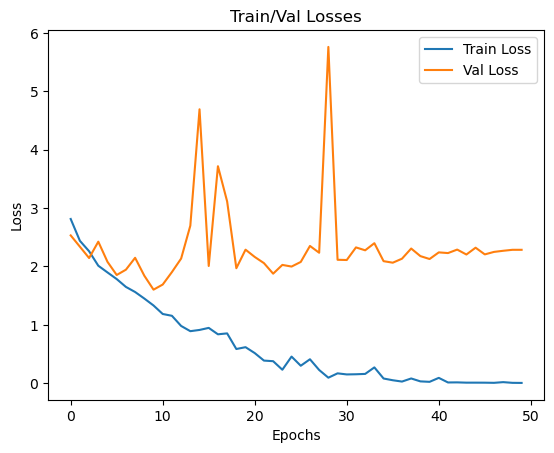

train_losses=[2.813260078430176, 2.439293632730406, 2.260509146584405, 2.0123997602546426, 1.8971963932639675, 1.783737766115289, 1.6494520362357648, 1.5622699443708385, 1.4503239110896462, 1.3314634052633543, 1.1856641384244662, 1.1547240532978236, 0.98075960288968, 0.8911878924097931, 0.9124205326824858, 0.9475314570100684, 0.8376453974180751, 0.853216974184527, 0.5856001560973843, 0.6170524546538877, 0.5158107835385535, 0.38729443760556087, 0.3770080347333038, 0.2307306992009892, 0.4558314948141226, 0.2990517898827617, 0.40998272210283326, 0.22638343747334871, 0.09431843946508148, 0.16876589984507762, 0.15014346482025254, 0.15304425582480316, 0.1590445187604545, 0.27068226048259925, 0.0803143859320805, 0.05056024478695339, 0.027910511956035503, 0.08100743980040741, 0.03114927019236326, 0.023423625497359848, 0.0913238025757849, 0.012598240892375595, 0.0139679576590935, 0.00925595375228597, 0.00938478852547324, 0.008805311865333947, 0.006364180770946384, 0.018119577459694152, 0.006198

100%|██████████| 52/52 [00:00<00:00, 103.55it/s]

Epoch [1/50], Train Loss: 7.2432, Train Accuracy: 11.27%, Val Loss: 2.7595, Val Accuracy: 14.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.77it/s] 

Epoch [2/50], Train Loss: 2.4589, Train Accuracy: 21.36%, Val Loss: 2.2294, Val Accuracy: 24.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.15it/s] 

Epoch [3/50], Train Loss: 2.3406, Train Accuracy: 22.24%, Val Loss: 2.2918, Val Accuracy: 25.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.98it/s]

Epoch [4/50], Train Loss: 2.1414, Train Accuracy: 26.55%, Val Loss: 2.2570, Val Accuracy: 25.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.35it/s]

Epoch [5/50], Train Loss: 2.0430, Train Accuracy: 29.77%, Val Loss: 2.0168, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.16it/s]

Epoch [6/50], Train Loss: 1.9107, Train Accuracy: 32.55%, Val Loss: 2.1321, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.14it/s] 

Epoch [7/50], Train Loss: 1.8622, Train Accuracy: 35.04%, Val Loss: 2.1301, Val Accuracy: 32.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.54it/s]

Epoch [8/50], Train Loss: 1.7865, Train Accuracy: 37.38%, Val Loss: 2.0718, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.49it/s] 

Epoch [9/50], Train Loss: 1.7890, Train Accuracy: 36.94%, Val Loss: 2.1249, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.17it/s]

Epoch [10/50], Train Loss: 1.6562, Train Accuracy: 41.40%, Val Loss: 2.0729, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.51it/s] 

Epoch [11/50], Train Loss: 1.7404, Train Accuracy: 39.14%, Val Loss: 2.2671, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.60it/s]

Epoch [12/50], Train Loss: 1.6061, Train Accuracy: 43.60%, Val Loss: 2.1318, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.54it/s]

Epoch [13/50], Train Loss: 1.4779, Train Accuracy: 46.82%, Val Loss: 2.0557, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.27it/s]

Epoch [14/50], Train Loss: 1.4959, Train Accuracy: 46.31%, Val Loss: 2.2115, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.72it/s]

Epoch [15/50], Train Loss: 1.5510, Train Accuracy: 47.70%, Val Loss: 2.3822, Val Accuracy: 30.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.89it/s] 

Epoch [16/50], Train Loss: 1.4838, Train Accuracy: 47.77%, Val Loss: 2.1510, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.64it/s]

Epoch [17/50], Train Loss: 1.4165, Train Accuracy: 50.40%, Val Loss: 2.5633, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.78it/s] 

Epoch [18/50], Train Loss: 1.4412, Train Accuracy: 49.38%, Val Loss: 2.1165, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.59it/s]

Epoch [19/50], Train Loss: 1.3501, Train Accuracy: 52.74%, Val Loss: 2.3209, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.83it/s]

Epoch [20/50], Train Loss: 1.2818, Train Accuracy: 51.94%, Val Loss: 2.4749, Val Accuracy: 30.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.90it/s]

Epoch [21/50], Train Loss: 1.3305, Train Accuracy: 50.91%, Val Loss: 2.1708, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.14it/s]

Epoch [22/50], Train Loss: 1.1543, Train Accuracy: 59.55%, Val Loss: 2.3866, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.32it/s]

Epoch [23/50], Train Loss: 1.2637, Train Accuracy: 54.13%, Val Loss: 2.5501, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.17it/s] 

Epoch [24/50], Train Loss: 1.0796, Train Accuracy: 61.08%, Val Loss: 2.3507, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.54it/s]

Epoch [25/50], Train Loss: 1.1156, Train Accuracy: 61.38%, Val Loss: 2.6357, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.08it/s]

Epoch [26/50], Train Loss: 1.2996, Train Accuracy: 54.13%, Val Loss: 2.6277, Val Accuracy: 28.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 93.20it/s]

Epoch [27/50], Train Loss: 1.0591, Train Accuracy: 62.03%, Val Loss: 2.5853, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.00it/s] 

Epoch [28/50], Train Loss: 1.0360, Train Accuracy: 63.57%, Val Loss: 2.5969, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.99it/s]

Epoch [29/50], Train Loss: 0.9841, Train Accuracy: 64.45%, Val Loss: 2.5978, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.25it/s]

Epoch [30/50], Train Loss: 1.0479, Train Accuracy: 62.55%, Val Loss: 2.8077, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.48it/s]

Epoch [31/50], Train Loss: 1.0123, Train Accuracy: 62.47%, Val Loss: 2.5494, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.60it/s]

Epoch [32/50], Train Loss: 0.9238, Train Accuracy: 66.20%, Val Loss: 2.7017, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.41it/s]

Epoch [33/50], Train Loss: 1.0189, Train Accuracy: 64.45%, Val Loss: 2.9469, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.85it/s]

Epoch [34/50], Train Loss: 0.8560, Train Accuracy: 70.23%, Val Loss: 2.7344, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.29it/s]

Epoch [35/50], Train Loss: 0.8012, Train Accuracy: 71.84%, Val Loss: 3.0334, Val Accuracy: 37.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.02it/s] 

Epoch [36/50], Train Loss: 0.7526, Train Accuracy: 75.49%, Val Loss: 2.8948, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.81it/s] 

Epoch [37/50], Train Loss: 0.9657, Train Accuracy: 66.13%, Val Loss: 4.0052, Val Accuracy: 25.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.40it/s]

Epoch [38/50], Train Loss: 0.7478, Train Accuracy: 73.45%, Val Loss: 3.1987, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.47it/s]

Epoch [39/50], Train Loss: 0.7479, Train Accuracy: 73.59%, Val Loss: 2.9996, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.30it/s]

Epoch [40/50], Train Loss: 0.8578, Train Accuracy: 69.42%, Val Loss: 3.8015, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.48it/s]

Epoch [41/50], Train Loss: 0.7196, Train Accuracy: 74.54%, Val Loss: 3.0685, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.32it/s]

Epoch [42/50], Train Loss: 0.7807, Train Accuracy: 72.57%, Val Loss: 3.4242, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.43it/s]

Epoch [43/50], Train Loss: 0.6703, Train Accuracy: 77.25%, Val Loss: 3.5527, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.15it/s] 

Epoch [44/50], Train Loss: 0.7286, Train Accuracy: 75.13%, Val Loss: 3.2829, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.39it/s] 

Epoch [45/50], Train Loss: 0.7910, Train Accuracy: 73.74%, Val Loss: 4.4362, Val Accuracy: 24.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.40it/s] 

Epoch [46/50], Train Loss: 0.6643, Train Accuracy: 77.03%, Val Loss: 3.2267, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.07it/s]

Epoch [47/50], Train Loss: 0.7683, Train Accuracy: 73.88%, Val Loss: 4.2325, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.47it/s]

Epoch [48/50], Train Loss: 0.8101, Train Accuracy: 71.10%, Val Loss: 3.4751, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.69it/s]

Epoch [49/50], Train Loss: 0.6334, Train Accuracy: 77.91%, Val Loss: 3.7286, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 84.13it/s] 

Epoch [50/50], Train Loss: 0.6365, Train Accuracy: 77.32%, Val Loss: 3.5629, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.88it/s]


Test Accuracy: 30.68%


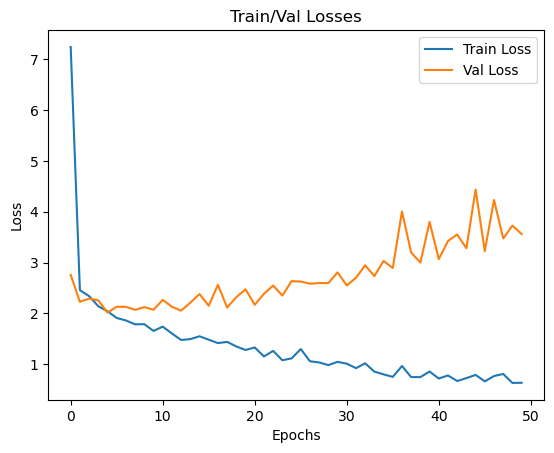

train_losses=[7.24317004666691, 2.458855374514708, 2.3406351442225497, 2.14142982722723, 2.0430074776822362, 1.9106800625895897, 1.8622178376069543, 1.7865446422532287, 1.788951375331098, 1.6561720622213263, 1.7403923970216897, 1.6060559631091111, 1.4779029188797488, 1.4959225288608617, 1.5509815003439698, 1.4838498287033617, 1.4164896454030311, 1.4412293611911304, 1.350057447862904, 1.2818400866804067, 1.3305138558672185, 1.154256077886325, 1.2637378420048988, 1.0795865705487324, 1.115580392336985, 1.2996088140889217, 1.0591322256807696, 1.035963309961453, 0.9840947658869258, 1.047948485926578, 1.012287628755235, 0.9237938227012144, 1.0188642518910749, 0.8559726501940287, 0.801243081558169, 0.7525796384839286, 0.9657392770226239, 0.7478158387698626, 0.747881972563197, 0.857781036991125, 0.7196458882232856, 0.78072945620015, 0.6703341768847572, 0.7285996507308636, 0.7910107322777921, 0.6643054328466717, 0.7682752503811965, 0.8100873331664599, 0.6333579091649306, 0.6364805263124014]
[2.

100%|██████████| 52/52 [00:00<00:00, 97.74it/s]

Epoch [1/50], Train Loss: 7.6265, Train Accuracy: 13.17%, Val Loss: 2.8037, Val Accuracy: 14.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.14it/s]

Epoch [2/50], Train Loss: 2.7830, Train Accuracy: 18.65%, Val Loss: 2.5288, Val Accuracy: 22.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.11it/s]

Epoch [3/50], Train Loss: 2.6189, Train Accuracy: 24.07%, Val Loss: 2.5810, Val Accuracy: 27.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.74it/s]

Epoch [4/50], Train Loss: 2.6342, Train Accuracy: 25.82%, Val Loss: 2.8421, Val Accuracy: 18.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.59it/s] 

Epoch [5/50], Train Loss: 2.4098, Train Accuracy: 28.09%, Val Loss: 2.3515, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.75it/s] 

Epoch [6/50], Train Loss: 2.2370, Train Accuracy: 31.89%, Val Loss: 3.1016, Val Accuracy: 19.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.39it/s]

Epoch [7/50], Train Loss: 2.4116, Train Accuracy: 26.26%, Val Loss: 2.0858, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.97it/s]

Epoch [8/50], Train Loss: 2.2388, Train Accuracy: 30.29%, Val Loss: 2.1437, Val Accuracy: 32.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.20it/s]

Epoch [9/50], Train Loss: 2.3469, Train Accuracy: 30.94%, Val Loss: 3.0068, Val Accuracy: 15.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.61it/s]

Epoch [10/50], Train Loss: 2.3548, Train Accuracy: 31.24%, Val Loss: 2.0994, Val Accuracy: 36.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.73it/s]

Epoch [11/50], Train Loss: 2.2218, Train Accuracy: 34.16%, Val Loss: 2.0024, Val Accuracy: 36.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.64it/s] 

Epoch [12/50], Train Loss: 2.4337, Train Accuracy: 30.07%, Val Loss: 2.4476, Val Accuracy: 24.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.31it/s] 

Epoch [13/50], Train Loss: 2.2636, Train Accuracy: 33.28%, Val Loss: 2.0117, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 94.36it/s]

Epoch [14/50], Train Loss: 2.2035, Train Accuracy: 33.21%, Val Loss: 2.4811, Val Accuracy: 24.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.02it/s] 

Epoch [15/50], Train Loss: 2.3640, Train Accuracy: 32.70%, Val Loss: 2.4824, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.08it/s] 

Epoch [16/50], Train Loss: 2.2316, Train Accuracy: 32.48%, Val Loss: 3.4196, Val Accuracy: 22.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.04it/s]

Epoch [17/50], Train Loss: 2.3803, Train Accuracy: 32.85%, Val Loss: 2.2099, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.29it/s]

Epoch [18/50], Train Loss: 2.3951, Train Accuracy: 31.38%, Val Loss: 3.5619, Val Accuracy: 25.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.72it/s] 


Epoch [19/50], Train Loss: 2.4454, Train Accuracy: 32.55%, Val Loss: 1.9391, Val Accuracy: 41.46%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.68it/s] 

Epoch [20/50], Train Loss: 2.0740, Train Accuracy: 39.72%, Val Loss: 2.2376, Val Accuracy: 32.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.38it/s]

Epoch [21/50], Train Loss: 2.1639, Train Accuracy: 34.97%, Val Loss: 2.4513, Val Accuracy: 28.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.89it/s] 

Epoch [22/50], Train Loss: 2.2365, Train Accuracy: 36.87%, Val Loss: 2.1471, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.22it/s] 

Epoch [23/50], Train Loss: 2.2418, Train Accuracy: 35.04%, Val Loss: 2.9875, Val Accuracy: 24.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.87it/s] 

Epoch [24/50], Train Loss: 2.1535, Train Accuracy: 36.87%, Val Loss: 2.8324, Val Accuracy: 30.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.86it/s] 

Epoch [25/50], Train Loss: 2.3853, Train Accuracy: 36.14%, Val Loss: 2.8075, Val Accuracy: 29.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.51it/s] 

Epoch [26/50], Train Loss: 2.2299, Train Accuracy: 38.92%, Val Loss: 2.5648, Val Accuracy: 29.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.73it/s] 


Epoch [27/50], Train Loss: 2.3281, Train Accuracy: 37.02%, Val Loss: 1.9741, Val Accuracy: 37.32%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.35it/s] 

Epoch [28/50], Train Loss: 2.0782, Train Accuracy: 39.72%, Val Loss: 2.1414, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.02it/s]

Epoch [29/50], Train Loss: 2.0032, Train Accuracy: 42.28%, Val Loss: 2.5183, Val Accuracy: 28.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.93it/s]

Epoch [30/50], Train Loss: 2.0706, Train Accuracy: 39.28%, Val Loss: 2.5134, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.22it/s]

Epoch [31/50], Train Loss: 2.0449, Train Accuracy: 38.84%, Val Loss: 3.6202, Val Accuracy: 20.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.20it/s]

Epoch [32/50], Train Loss: 2.3817, Train Accuracy: 38.62%, Val Loss: 3.1113, Val Accuracy: 22.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.25it/s] 

Epoch [33/50], Train Loss: 2.1525, Train Accuracy: 38.62%, Val Loss: 3.4467, Val Accuracy: 23.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.66it/s]

Epoch [34/50], Train Loss: 2.2202, Train Accuracy: 38.55%, Val Loss: 3.0168, Val Accuracy: 27.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.95it/s] 

Epoch [35/50], Train Loss: 1.9489, Train Accuracy: 43.38%, Val Loss: 1.9415, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.77it/s] 

Epoch [36/50], Train Loss: 2.0663, Train Accuracy: 42.06%, Val Loss: 3.0491, Val Accuracy: 24.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.22it/s]

Epoch [37/50], Train Loss: 2.2157, Train Accuracy: 38.70%, Val Loss: 4.1849, Val Accuracy: 18.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.62it/s]

Epoch [38/50], Train Loss: 2.2491, Train Accuracy: 38.26%, Val Loss: 2.1537, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.84it/s]

Epoch [39/50], Train Loss: 2.2659, Train Accuracy: 38.11%, Val Loss: 2.1858, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.26it/s]

Epoch [40/50], Train Loss: 2.1981, Train Accuracy: 42.14%, Val Loss: 5.3351, Val Accuracy: 13.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.65it/s] 


Epoch [41/50], Train Loss: 2.3364, Train Accuracy: 36.72%, Val Loss: 3.3653, Val Accuracy: 29.02%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.95it/s] 

Epoch [42/50], Train Loss: 2.2570, Train Accuracy: 40.31%, Val Loss: 2.6099, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.64it/s] 

Epoch [43/50], Train Loss: 1.8512, Train Accuracy: 44.48%, Val Loss: 3.2132, Val Accuracy: 32.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.26it/s]

Epoch [44/50], Train Loss: 2.0318, Train Accuracy: 43.89%, Val Loss: 2.4058, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.81it/s] 

Epoch [45/50], Train Loss: 1.8696, Train Accuracy: 43.82%, Val Loss: 2.5399, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.70it/s]

Epoch [46/50], Train Loss: 1.9948, Train Accuracy: 42.79%, Val Loss: 2.0388, Val Accuracy: 39.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.13it/s]

Epoch [47/50], Train Loss: 2.2447, Train Accuracy: 37.82%, Val Loss: 2.4486, Val Accuracy: 26.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.50it/s] 

Epoch [48/50], Train Loss: 2.5976, Train Accuracy: 29.33%, Val Loss: 3.0907, Val Accuracy: 27.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.58it/s]

Epoch [49/50], Train Loss: 2.4645, Train Accuracy: 30.50%, Val Loss: 2.5788, Val Accuracy: 23.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.61it/s]

Epoch [50/50], Train Loss: 2.4129, Train Accuracy: 32.70%, Val Loss: 2.7184, Val Accuracy: 24.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 64.47it/s]


Test Accuracy: 24.43%


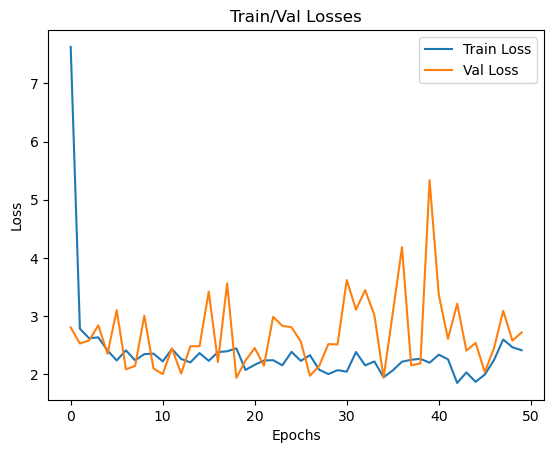

train_losses=[7.626472566559998, 2.7829914148788006, 2.6188973645020646, 2.6341809292285765, 2.4098259465039127, 2.2369863934684218, 2.411551957241973, 2.2387711862374466, 2.3469373315398454, 2.3547902330320483, 2.221819015971401, 2.4337054484071787, 2.263562999970732, 2.2034765140354984, 2.3640402705348724, 2.23158620045199, 2.380334851337455, 2.395088749670843, 2.445399050126996, 2.073983315138789, 2.163898419218454, 2.2364925965231066, 2.241784044873645, 2.1535294847181667, 2.385277742182302, 2.229861634865142, 2.3281435056736597, 2.07818940822144, 2.003247792609254, 2.0706458896921394, 2.044931264300095, 2.3817107311466286, 2.1525025768586765, 2.220203669796213, 1.948862762479057, 2.0663116054925306, 2.2157115054409404, 2.2490635970879715, 2.265924117718524, 2.198126562331852, 2.336397402119218, 2.256987150823861, 1.8512223866599344, 2.0318178539736227, 1.8696373070192616, 1.9948083594528556, 2.2447009686140986, 2.597607699402592, 2.4645279896886727, 2.4128904855042173]
[2.80367332

100%|██████████| 52/52 [00:00<00:00, 100.31it/s]

Epoch [1/50], Train Loss: 2.8184, Train Accuracy: 11.56%, Val Loss: 2.6099, Val Accuracy: 13.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.29it/s] 

Epoch [2/50], Train Loss: 2.4483, Train Accuracy: 21.51%, Val Loss: 2.2780, Val Accuracy: 30.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.73it/s]

Epoch [3/50], Train Loss: 2.2433, Train Accuracy: 26.85%, Val Loss: 2.0769, Val Accuracy: 37.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.11it/s]


Epoch [4/50], Train Loss: 2.0967, Train Accuracy: 33.50%, Val Loss: 2.0440, Val Accuracy: 38.78%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.75it/s]

Epoch [5/50], Train Loss: 1.9245, Train Accuracy: 38.84%, Val Loss: 2.0643, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.04it/s]

Epoch [6/50], Train Loss: 1.7664, Train Accuracy: 43.89%, Val Loss: 1.9040, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.85it/s] 

Epoch [7/50], Train Loss: 1.6595, Train Accuracy: 47.04%, Val Loss: 2.1168, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.41it/s]

Epoch [8/50], Train Loss: 1.5683, Train Accuracy: 49.09%, Val Loss: 2.0223, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.39it/s]

Epoch [9/50], Train Loss: 1.4031, Train Accuracy: 54.35%, Val Loss: 1.9818, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.43it/s] 

Epoch [10/50], Train Loss: 1.3960, Train Accuracy: 55.89%, Val Loss: 1.9819, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.27it/s]


Epoch [11/50], Train Loss: 1.3577, Train Accuracy: 57.43%, Val Loss: 2.0051, Val Accuracy: 41.71%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.89it/s]

Epoch [12/50], Train Loss: 1.2558, Train Accuracy: 59.33%, Val Loss: 2.1526, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.37it/s]


Epoch [13/50], Train Loss: 1.1254, Train Accuracy: 62.69%, Val Loss: 1.7063, Val Accuracy: 49.51%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.59it/s]

Epoch [14/50], Train Loss: 1.0830, Train Accuracy: 66.64%, Val Loss: 2.0059, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.19it/s]

Epoch [15/50], Train Loss: 1.0855, Train Accuracy: 66.50%, Val Loss: 1.9217, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.37it/s]

Epoch [16/50], Train Loss: 1.0658, Train Accuracy: 65.54%, Val Loss: 1.9224, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.29it/s]

Epoch [17/50], Train Loss: 0.8391, Train Accuracy: 72.79%, Val Loss: 2.0741, Val Accuracy: 46.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.19it/s]

Epoch [18/50], Train Loss: 0.7938, Train Accuracy: 74.91%, Val Loss: 2.5161, Val Accuracy: 36.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.72it/s]

Epoch [19/50], Train Loss: 0.7791, Train Accuracy: 74.91%, Val Loss: 1.7991, Val Accuracy: 49.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.70it/s]

Epoch [20/50], Train Loss: 0.7384, Train Accuracy: 76.59%, Val Loss: 2.3389, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.39it/s]

Epoch [21/50], Train Loss: 0.6594, Train Accuracy: 78.86%, Val Loss: 2.4498, Val Accuracy: 39.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.60it/s]

Epoch [22/50], Train Loss: 0.6593, Train Accuracy: 79.44%, Val Loss: 1.7741, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.13it/s]


Epoch [23/50], Train Loss: 0.5517, Train Accuracy: 82.88%, Val Loss: 1.7766, Val Accuracy: 51.22%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.17it/s]

Epoch [24/50], Train Loss: 0.4486, Train Accuracy: 85.95%, Val Loss: 1.8639, Val Accuracy: 50.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.33it/s]

Epoch [25/50], Train Loss: 0.5254, Train Accuracy: 85.08%, Val Loss: 1.9789, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.98it/s]

Epoch [26/50], Train Loss: 0.4627, Train Accuracy: 86.17%, Val Loss: 2.0095, Val Accuracy: 46.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.64it/s]

Epoch [27/50], Train Loss: 0.4466, Train Accuracy: 87.20%, Val Loss: 2.3104, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.59it/s]

Epoch [28/50], Train Loss: 0.5443, Train Accuracy: 82.81%, Val Loss: 2.0218, Val Accuracy: 46.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.54it/s]

Epoch [29/50], Train Loss: 0.4132, Train Accuracy: 89.10%, Val Loss: 2.4696, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.37it/s]

Epoch [30/50], Train Loss: 0.4398, Train Accuracy: 86.61%, Val Loss: 2.1687, Val Accuracy: 46.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.18it/s]

Epoch [31/50], Train Loss: 0.6319, Train Accuracy: 82.59%, Val Loss: 1.7679, Val Accuracy: 50.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.64it/s] 

Epoch [32/50], Train Loss: 0.5425, Train Accuracy: 87.05%, Val Loss: 3.1518, Val Accuracy: 29.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.26it/s]

Epoch [33/50], Train Loss: 1.0165, Train Accuracy: 67.74%, Val Loss: 2.7410, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.60it/s]

Epoch [34/50], Train Loss: 0.5542, Train Accuracy: 82.88%, Val Loss: 2.7297, Val Accuracy: 39.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.44it/s]

Epoch [35/50], Train Loss: 0.4313, Train Accuracy: 87.49%, Val Loss: 2.1443, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.79it/s] 

Epoch [36/50], Train Loss: 0.7756, Train Accuracy: 81.20%, Val Loss: 2.2993, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.47it/s]

Epoch [37/50], Train Loss: 0.8376, Train Accuracy: 74.18%, Val Loss: 2.1420, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.62it/s]

Epoch [38/50], Train Loss: 0.5938, Train Accuracy: 81.86%, Val Loss: 4.1738, Val Accuracy: 25.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.30it/s]

Epoch [39/50], Train Loss: 0.5675, Train Accuracy: 82.81%, Val Loss: 3.8839, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.94it/s]

Epoch [40/50], Train Loss: 0.8719, Train Accuracy: 74.32%, Val Loss: 2.1084, Val Accuracy: 40.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.67it/s]

Epoch [41/50], Train Loss: 0.5554, Train Accuracy: 82.88%, Val Loss: 2.0770, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.43it/s]

Epoch [42/50], Train Loss: 0.5210, Train Accuracy: 85.81%, Val Loss: 3.0822, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.70it/s]

Epoch [43/50], Train Loss: 0.6137, Train Accuracy: 82.22%, Val Loss: 2.2198, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.85it/s]

Epoch [44/50], Train Loss: 0.6413, Train Accuracy: 82.37%, Val Loss: 2.2099, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.18it/s]

Epoch [45/50], Train Loss: 0.6008, Train Accuracy: 83.10%, Val Loss: 2.0135, Val Accuracy: 46.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.16it/s]

Epoch [46/50], Train Loss: 0.3535, Train Accuracy: 88.95%, Val Loss: 1.9190, Val Accuracy: 47.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.08it/s]

Epoch [47/50], Train Loss: 0.2147, Train Accuracy: 94.51%, Val Loss: 1.9243, Val Accuracy: 50.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.70it/s]

Epoch [48/50], Train Loss: 0.2467, Train Accuracy: 93.56%, Val Loss: 2.6045, Val Accuracy: 40.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.04it/s]

Epoch [49/50], Train Loss: 0.3596, Train Accuracy: 89.83%, Val Loss: 2.1699, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.00it/s]

Epoch [50/50], Train Loss: 0.1318, Train Accuracy: 97.00%, Val Loss: 2.0254, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.50it/s]


Test Accuracy: 47.73%


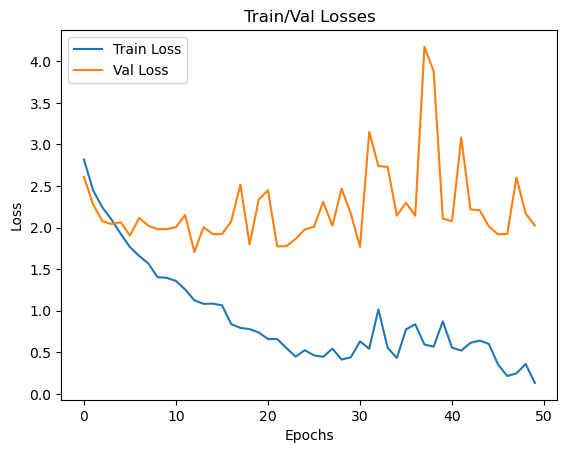

train_losses=[2.818436653293364, 2.448283682789719, 2.2433311444276955, 2.0966579007823567, 1.9244689923977991, 1.766412245599847, 1.6595159699345192, 1.5682981742752924, 1.4031338796280979, 1.3960347691474602, 1.3576562050838916, 1.2558083778236344, 1.1254204295967754, 1.0829749675086366, 1.0854869505815339, 1.065817732472866, 0.8391385299769062, 0.7937535492823138, 0.7790974744143542, 0.7384133201244979, 0.6594206535241061, 0.6593304267316534, 0.5516680891772634, 0.44858233367054784, 0.5253926668512193, 0.4627348318783163, 0.44657235936811795, 0.544259076360722, 0.4132436233741498, 0.4398429451935124, 0.6319293763423175, 0.5424698871119242, 1.0164669173502783, 0.5541757157736877, 0.43133869412088255, 0.7755812652169438, 0.8376077643176268, 0.5937508887540527, 0.5674923559465603, 0.871917996098075, 0.5553802838494555, 0.5209617393625061, 0.6136743229492541, 0.641328328904527, 0.6008348674431705, 0.35346735041174626, 0.21467049271739713, 0.24672098432215508, 0.3595747456107049, 0.13179

In [36]:
import torch
import matplotlib.pyplot as plt

results_50 = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])
num_epochs = 50
params = [(optim.SGD, 0.001, 0.001), (optim.SGD, 0.01, 0.0001), (optim.Adam, 0.001,0.0001), (optim.Adam, 0.001,0.01), (optim.SGD, 0.01,0.01)]

for param in params:
    model = MyClassificationNet(input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3,
                        hidden_size=1024,
                        output_size=20).to(device)

    print(f"Params lr={param[1]}, w={param[2]}, opt={param[0]}")
    train_losses, val_losses, results_50 = train(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], res=results_50)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
            images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Val Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{val_losses}")

In [37]:
results_50

,optimizer,learning_rate,weight_decay,val_accuracy
0,SGD,0.01,0.0010,0.539024
0,SGD,0.01,0.0001,0.558537
0,Adam,0.01,0.0001,0.382927
0,Adam,0.01,0.0100,0.414634
0,SGD,0.01,0.0100,0.512195


The best results achieved by SGD optimizer with: lr = 0.01 and weight_decay = 0.0001. Test accuracy of this model is equal to 57%
All the train/val losses can be found above.

# BatchNormalization

In addition, we can add BatchNormalization layers to get better results 

In [38]:
class MyClassificationBatchNormalizationNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyClassificationBatchNormalizationNet, self).__init__()
        self.fc1 = Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = ReLU()
        self.fc2 = Linear(hidden_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)

    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.bn1.forward(x)
        x = self.relu.forward(x)
        x = self.fc2.forward(x)
        x = self.bn2.forward(x)
        return x

In [39]:
res_with_batch_norm = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])

Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 104.38it/s]

Epoch [1/10], Train Loss: 2.4984, Train Accuracy: 24.36%, Val Loss: 2.2327, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.84it/s]

Epoch [2/10], Train Loss: 1.9742, Train Accuracy: 44.55%, Val Loss: 2.1004, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.59it/s]

Epoch [3/10], Train Loss: 1.7601, Train Accuracy: 53.99%, Val Loss: 3.8200, Val Accuracy: 9.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.50it/s]

Epoch [4/10], Train Loss: 1.6074, Train Accuracy: 62.77%, Val Loss: 2.0829, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 93.61it/s]

Epoch [5/10], Train Loss: 1.5369, Train Accuracy: 68.03%, Val Loss: 2.0384, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.25it/s]

Epoch [6/10], Train Loss: 1.4839, Train Accuracy: 71.25%, Val Loss: 2.0548, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.23it/s]

Epoch [7/10], Train Loss: 1.4356, Train Accuracy: 74.54%, Val Loss: 1.9425, Val Accuracy: 47.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.24it/s]

Epoch [8/10], Train Loss: 1.4080, Train Accuracy: 76.37%, Val Loss: 2.0617, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.49it/s]

Epoch [9/10], Train Loss: 1.3928, Train Accuracy: 76.81%, Val Loss: 2.0939, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.80it/s]

Epoch [10/10], Train Loss: 1.3214, Train Accuracy: 83.03%, Val Loss: 2.0696, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 68.05it/s]


Test Accuracy with learning rate 0.001: 46.02%


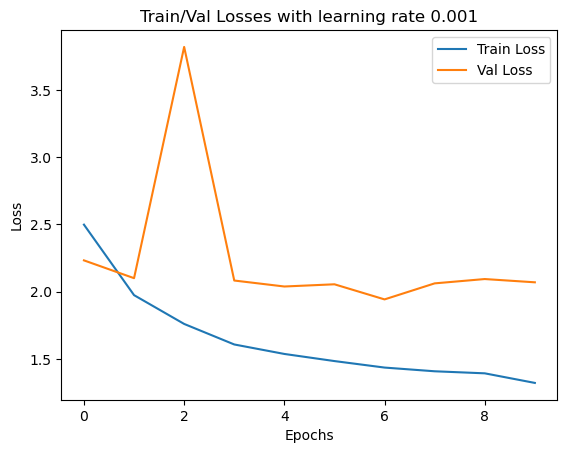

train_losses=[2.498403882422642, 1.9741815718991018, 1.760075529416402, 1.6074128318251224, 1.5368839258338973, 1.4839347559109068, 1.435609529590049, 1.4080120227490251, 1.3927754128885548, 1.321432267713268]
[2.2327475364391622, 2.100363777234004, 3.819996687082144, 2.082851004142028, 2.0384408694047194, 2.0548452184750485, 1.9425157835850348, 2.0617239704498878, 2.093872478375068, 2.0695938972326426]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 112.88it/s]

Epoch [1/10], Train Loss: 2.5086, Train Accuracy: 24.65%, Val Loss: 2.3219, Val Accuracy: 26.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.98it/s]

Epoch [2/10], Train Loss: 1.9575, Train Accuracy: 44.40%, Val Loss: 2.1018, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.69it/s]

Epoch [3/10], Train Loss: 1.7505, Train Accuracy: 53.99%, Val Loss: 2.0661, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.10it/s]

Epoch [4/10], Train Loss: 1.6473, Train Accuracy: 60.72%, Val Loss: 1.9748, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 93.48it/s] 

Epoch [5/10], Train Loss: 1.5377, Train Accuracy: 68.11%, Val Loss: 2.0031, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.03it/s]

Epoch [6/10], Train Loss: 1.4764, Train Accuracy: 72.71%, Val Loss: 2.0167, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.55it/s]

Epoch [7/10], Train Loss: 1.4492, Train Accuracy: 74.32%, Val Loss: 2.0059, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 116.46it/s]

Epoch [8/10], Train Loss: 1.3900, Train Accuracy: 78.86%, Val Loss: 1.9773, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.36it/s]

Epoch [9/10], Train Loss: 1.3489, Train Accuracy: 80.10%, Val Loss: 2.0533, Val Accuracy: 43.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.98it/s]

Epoch [10/10], Train Loss: 1.3160, Train Accuracy: 82.88%, Val Loss: 2.0128, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.27it/s]


Test Accuracy with learning rate 0.001: 42.05%


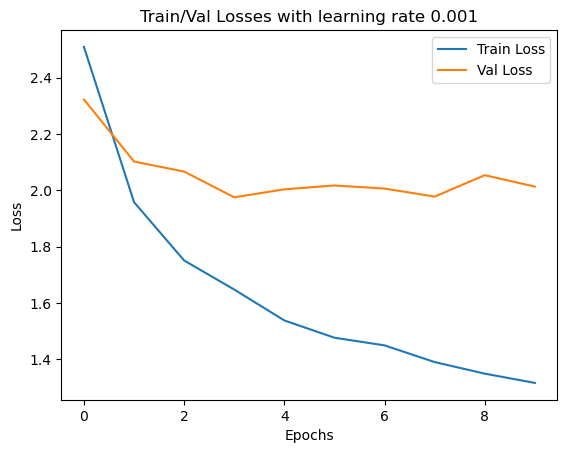

train_losses=[2.508561982746013, 1.9574783503660682, 1.7504734044883683, 1.6473475283349466, 1.5376902679253739, 1.476430568778724, 1.4492045982539306, 1.3899781362355104, 1.3488655062446817, 1.315957766527321]
[2.3219026693930993, 2.101795040644132, 2.0660822964631596, 1.9748110381456523, 2.003103781204957, 2.0166725562169003, 2.005868808581279, 1.977324875501486, 2.053336255825483, 2.0128259360790253]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 113.59it/s]

Epoch [1/10], Train Loss: 2.5387, Train Accuracy: 24.07%, Val Loss: 2.1982, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.88it/s]

Epoch [2/10], Train Loss: 2.0115, Train Accuracy: 44.48%, Val Loss: 2.0700, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.13it/s]

Epoch [3/10], Train Loss: 1.7606, Train Accuracy: 55.23%, Val Loss: 1.9929, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.24it/s]

Epoch [4/10], Train Loss: 1.6365, Train Accuracy: 62.47%, Val Loss: 1.9872, Val Accuracy: 40.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.16it/s]

Epoch [5/10], Train Loss: 1.5652, Train Accuracy: 66.35%, Val Loss: 1.9939, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.76it/s]

Epoch [6/10], Train Loss: 1.4773, Train Accuracy: 72.20%, Val Loss: 1.9548, Val Accuracy: 48.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.95it/s]

Epoch [7/10], Train Loss: 1.4495, Train Accuracy: 74.91%, Val Loss: 2.0613, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.25it/s]

Epoch [8/10], Train Loss: 1.3955, Train Accuracy: 76.96%, Val Loss: 1.9241, Val Accuracy: 47.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.36it/s]

Epoch [9/10], Train Loss: 1.3721, Train Accuracy: 79.37%, Val Loss: 2.0482, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.70it/s]

Epoch [10/10], Train Loss: 1.3595, Train Accuracy: 79.74%, Val Loss: 2.1413, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 69.25it/s]


Test Accuracy with learning rate 0.001: 34.66%


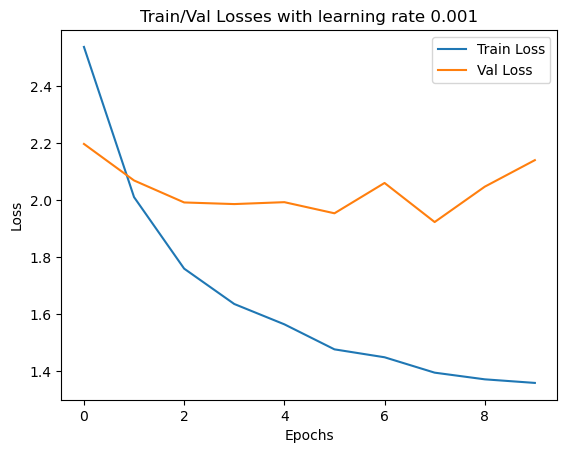

train_losses=[2.5386937961243747, 2.0115483051155048, 1.7605776124530368, 1.636519800152695, 1.565164157521655, 1.4773044593152944, 1.4495208416765892, 1.3955347440396135, 1.3721013515316256, 1.359495320515326]
[2.1982109661285696, 2.069982851927097, 1.992851592027224, 1.9871647793513079, 1.993850751565053, 1.9548112543729634, 2.0612608675773325, 1.924085578093162, 2.0481738562767324, 2.141344898022138]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 108.79it/s]

Epoch [1/10], Train Loss: 2.4844, Train Accuracy: 24.36%, Val Loss: 2.2610, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.88it/s]

Epoch [2/10], Train Loss: 2.0383, Train Accuracy: 38.99%, Val Loss: 2.1289, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 88.95it/s]

Epoch [3/10], Train Loss: 1.8140, Train Accuracy: 47.62%, Val Loss: 2.4623, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.11it/s]

Epoch [4/10], Train Loss: 1.6435, Train Accuracy: 55.96%, Val Loss: 1.9219, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 116.90it/s]

Epoch [5/10], Train Loss: 1.4786, Train Accuracy: 62.84%, Val Loss: 2.1097, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.31it/s]

Epoch [6/10], Train Loss: 1.4041, Train Accuracy: 66.13%, Val Loss: 2.5930, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.56it/s]

Epoch [7/10], Train Loss: 1.2622, Train Accuracy: 72.79%, Val Loss: 2.1939, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.85it/s]

Epoch [8/10], Train Loss: 1.2228, Train Accuracy: 72.42%, Val Loss: 2.2159, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.35it/s]

Epoch [9/10], Train Loss: 1.1272, Train Accuracy: 76.30%, Val Loss: 2.0189, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.17it/s]

Epoch [10/10], Train Loss: 1.0675, Train Accuracy: 79.81%, Val Loss: 2.1852, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 70.96it/s]


Test Accuracy with learning rate 0.01: 34.66%


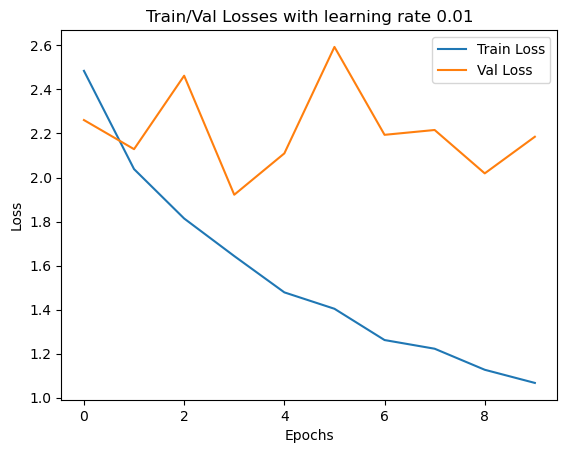

train_losses=[2.484372684132983, 2.038286348532515, 1.81403877093778, 1.6434744694079573, 1.4786247830641897, 1.4041413180312219, 1.2621598351768584, 1.2227822482934472, 1.1271916296746995, 1.0674976818045678]
[2.261004622165973, 2.128855744233498, 2.4623094338637133, 1.9218834546896129, 2.1096581587424645, 2.593036711215973, 2.193918840243266, 2.2158806117681356, 2.0189035489008975, 2.1851835537415285]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 111.19it/s]

Epoch [1/10], Train Loss: 2.5444, Train Accuracy: 22.60%, Val Loss: 2.2291, Val Accuracy: 37.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.97it/s]

Epoch [2/10], Train Loss: 2.1075, Train Accuracy: 38.48%, Val Loss: 2.0451, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 94.46it/s]

Epoch [3/10], Train Loss: 1.8879, Train Accuracy: 46.09%, Val Loss: 2.0803, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.99it/s]

Epoch [4/10], Train Loss: 1.7541, Train Accuracy: 51.65%, Val Loss: 1.9721, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.09it/s]

Epoch [5/10], Train Loss: 1.5638, Train Accuracy: 59.03%, Val Loss: 1.9968, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.26it/s]

Epoch [6/10], Train Loss: 1.4635, Train Accuracy: 64.89%, Val Loss: 2.0299, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.05it/s]

Epoch [7/10], Train Loss: 1.3598, Train Accuracy: 67.30%, Val Loss: 2.4782, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.91it/s]

Epoch [8/10], Train Loss: 1.2813, Train Accuracy: 71.25%, Val Loss: 1.9243, Val Accuracy: 40.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.78it/s]

Epoch [9/10], Train Loss: 1.2086, Train Accuracy: 73.45%, Val Loss: 1.8954, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.59it/s]

Epoch [10/10], Train Loss: 1.1337, Train Accuracy: 76.59%, Val Loss: 1.8744, Val Accuracy: 46.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 68.02it/s]


Test Accuracy with learning rate 0.01: 46.59%


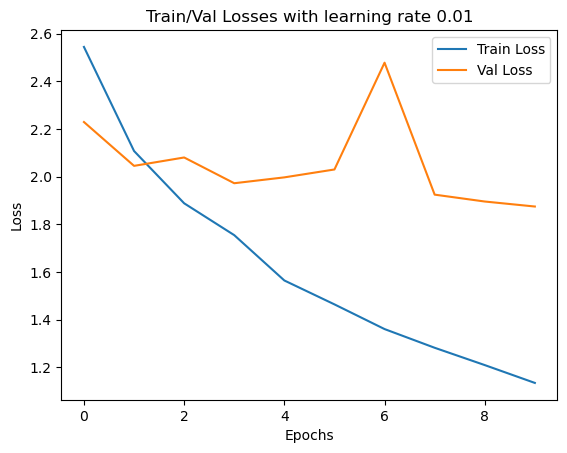

train_losses=[2.5444478953790943, 2.107456314633464, 1.8879354522939313, 1.7541417803680688, 1.5638130889301411, 1.463488292972944, 1.3598363580759505, 1.2813108863189206, 1.2086149579600285, 1.133726683973569]
[2.229127207627663, 2.0450637317620792, 2.0802542246305027, 1.972149738898644, 1.996768064223803, 2.029903074869743, 2.4782499877306132, 1.9242502405093267, 1.8953564258722158, 1.8743587480141566]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 109.80it/s]

Epoch [1/10], Train Loss: 2.4880, Train Accuracy: 22.82%, Val Loss: 2.0940, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.55it/s]

Epoch [2/10], Train Loss: 2.0326, Train Accuracy: 39.80%, Val Loss: 2.0667, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.99it/s]

Epoch [3/10], Train Loss: 1.8335, Train Accuracy: 48.79%, Val Loss: 2.0504, Val Accuracy: 43.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.48it/s]

Epoch [4/10], Train Loss: 1.6897, Train Accuracy: 54.35%, Val Loss: 2.1212, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 87.22it/s]

Epoch [5/10], Train Loss: 1.5693, Train Accuracy: 61.01%, Val Loss: 2.4582, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.18it/s]

Epoch [6/10], Train Loss: 1.4730, Train Accuracy: 64.37%, Val Loss: 2.2317, Val Accuracy: 37.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.81it/s]

Epoch [7/10], Train Loss: 1.3769, Train Accuracy: 68.47%, Val Loss: 2.1215, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.87it/s]

Epoch [8/10], Train Loss: 1.3025, Train Accuracy: 73.01%, Val Loss: 2.3764, Val Accuracy: 30.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.87it/s]

Epoch [9/10], Train Loss: 1.2364, Train Accuracy: 73.66%, Val Loss: 2.2398, Val Accuracy: 36.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 89.23it/s]

Epoch [10/10], Train Loss: 1.1843, Train Accuracy: 76.59%, Val Loss: 1.9079, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 59.86it/s]


Test Accuracy with learning rate 0.01: 39.20%


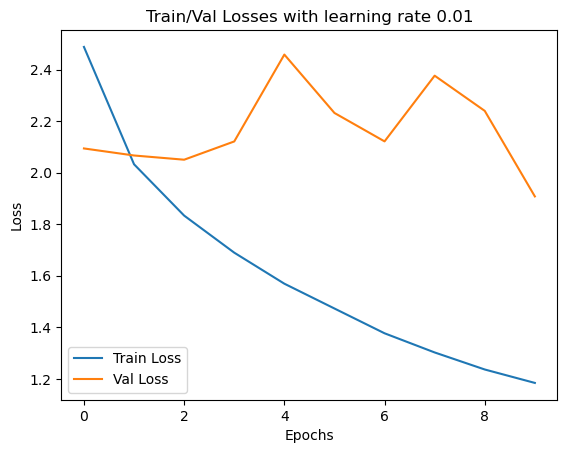

train_losses=[2.4879568696719163, 2.0326072075213606, 1.833538348214668, 1.689689350407026, 1.5693186946779665, 1.473042875354053, 1.3768924174950137, 1.3025458061207107, 1.236417151333993, 1.1843208524218776]
[2.0940450727939606, 2.0667246786447673, 2.050364611240534, 2.121213057866463, 2.458229871896597, 2.231721032124299, 2.1214672808463755, 2.37639733002736, 2.239793394620602, 1.907928705215454]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 113.56it/s]

Epoch [1/10], Train Loss: 2.6265, Train Accuracy: 17.85%, Val Loss: 2.3683, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.43it/s]

Epoch [2/10], Train Loss: 2.3744, Train Accuracy: 25.82%, Val Loss: 2.1998, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.40it/s]

Epoch [3/10], Train Loss: 2.1731, Train Accuracy: 34.02%, Val Loss: 2.2225, Val Accuracy: 32.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.19it/s]

Epoch [4/10], Train Loss: 2.0203, Train Accuracy: 38.84%, Val Loss: 2.2001, Val Accuracy: 32.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.73it/s]

Epoch [5/10], Train Loss: 1.9437, Train Accuracy: 42.57%, Val Loss: 3.6554, Val Accuracy: 11.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.74it/s]

Epoch [6/10], Train Loss: 1.8766, Train Accuracy: 44.92%, Val Loss: 2.1914, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.88it/s]

Epoch [7/10], Train Loss: 1.8326, Train Accuracy: 47.26%, Val Loss: 1.9915, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.71it/s]

Epoch [8/10], Train Loss: 1.7567, Train Accuracy: 49.96%, Val Loss: 2.8124, Val Accuracy: 28.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.72it/s]

Epoch [9/10], Train Loss: 1.6766, Train Accuracy: 53.18%, Val Loss: 2.5045, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.38it/s]

Epoch [10/10], Train Loss: 1.6440, Train Accuracy: 52.23%, Val Loss: 2.5301, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.97it/s]


Test Accuracy with learning rate 0.001: 26.14%


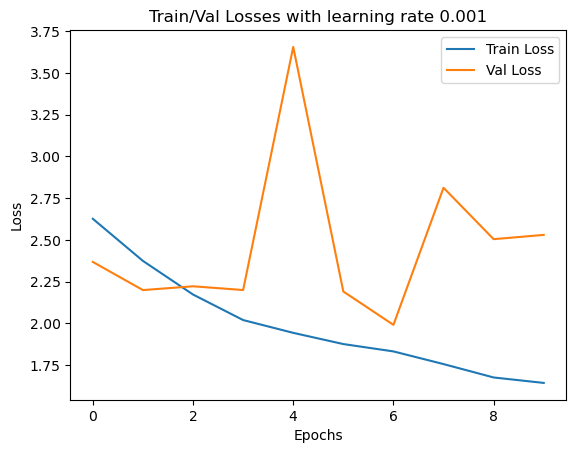

train_losses=[2.626463898441248, 2.3744234843560825, 2.1731233931424323, 2.020332123103895, 1.9437353464595057, 1.8766348508366368, 1.8326240227236386, 1.7567345252511097, 1.6766032851927462, 1.6439761278922098]
[2.3683035488312063, 2.1997813949218163, 2.2224669318932753, 2.2000851860413184, 3.6554195559941807, 2.1914098125237684, 1.9915446054476957, 2.8123858204254737, 2.504513061963595, 2.5301297834286323]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 109.49it/s]

Epoch [1/10], Train Loss: 2.6115, Train Accuracy: 18.51%, Val Loss: 2.3144, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.15it/s]

Epoch [2/10], Train Loss: 2.3853, Train Accuracy: 25.16%, Val Loss: 2.2933, Val Accuracy: 31.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.22it/s]

Epoch [3/10], Train Loss: 2.2732, Train Accuracy: 29.85%, Val Loss: 2.4865, Val Accuracy: 22.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.61it/s]

Epoch [4/10], Train Loss: 2.2862, Train Accuracy: 29.11%, Val Loss: 2.5371, Val Accuracy: 22.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.15it/s]

Epoch [5/10], Train Loss: 2.2455, Train Accuracy: 29.85%, Val Loss: 3.5331, Val Accuracy: 11.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.08it/s]

Epoch [6/10], Train Loss: 2.2602, Train Accuracy: 29.77%, Val Loss: 2.5651, Val Accuracy: 23.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.16it/s]

Epoch [7/10], Train Loss: 2.2438, Train Accuracy: 28.46%, Val Loss: 2.7018, Val Accuracy: 22.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.02it/s]

Epoch [8/10], Train Loss: 2.2324, Train Accuracy: 28.90%, Val Loss: 2.6602, Val Accuracy: 18.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.73it/s]

Epoch [9/10], Train Loss: 2.1708, Train Accuracy: 34.67%, Val Loss: 2.6163, Val Accuracy: 25.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.92it/s]

Epoch [10/10], Train Loss: 2.1650, Train Accuracy: 33.28%, Val Loss: 2.5189, Val Accuracy: 25.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 71.04it/s]


Test Accuracy with learning rate 0.001: 19.89%


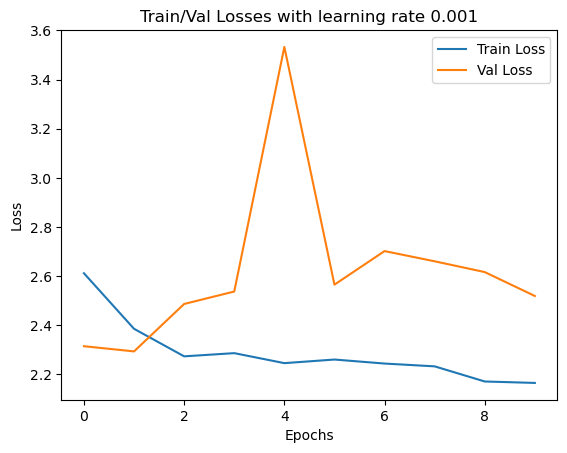

train_losses=[2.611501665840372, 2.3853234157227634, 2.2731851422995852, 2.2862014519540885, 2.245517713284632, 2.2602067865126316, 2.243824127124764, 2.2324304113611144, 2.1707800417615655, 2.1649703338132267]
[2.3144288613246036, 2.2932921877274146, 2.48645530297206, 2.537123102408189, 3.5330729943055372, 2.5651455108936014, 2.7017887372236986, 2.6601813412629642, 2.6162849916861606, 2.518913051256767]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 106.39it/s]

Epoch [1/10], Train Loss: 2.7399, Train Accuracy: 15.51%, Val Loss: 2.5465, Val Accuracy: 24.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.55it/s]

Epoch [2/10], Train Loss: 2.4977, Train Accuracy: 21.43%, Val Loss: 2.5955, Val Accuracy: 19.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.12it/s]

Epoch [3/10], Train Loss: 2.4801, Train Accuracy: 23.92%, Val Loss: 3.1149, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.49it/s]

Epoch [4/10], Train Loss: 2.5219, Train Accuracy: 22.38%, Val Loss: 3.2689, Val Accuracy: 11.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.98it/s]

Epoch [5/10], Train Loss: 2.5230, Train Accuracy: 22.09%, Val Loss: 3.4749, Val Accuracy: 10.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.09it/s]

Epoch [6/10], Train Loss: 2.5118, Train Accuracy: 22.17%, Val Loss: 2.8991, Val Accuracy: 17.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.53it/s]

Epoch [7/10], Train Loss: 2.5095, Train Accuracy: 22.38%, Val Loss: 3.0475, Val Accuracy: 10.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.74it/s]

Epoch [8/10], Train Loss: 2.5244, Train Accuracy: 23.34%, Val Loss: 3.2192, Val Accuracy: 16.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.26it/s]

Epoch [9/10], Train Loss: 2.4979, Train Accuracy: 21.65%, Val Loss: 2.9852, Val Accuracy: 10.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 117.25it/s]

Epoch [10/10], Train Loss: 2.4869, Train Accuracy: 23.63%, Val Loss: 2.8925, Val Accuracy: 18.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.33it/s]


Test Accuracy with learning rate 0.001: 15.34%


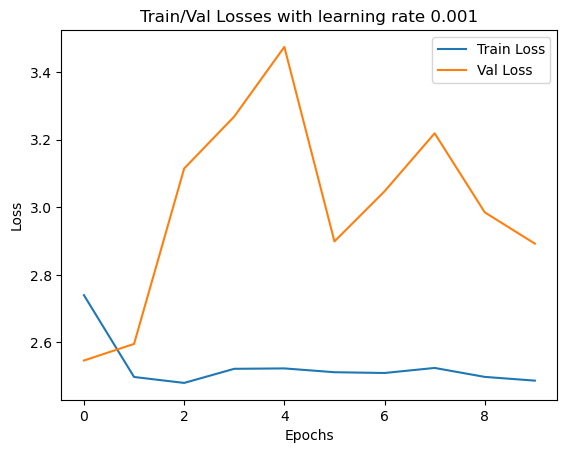

train_losses=[2.73988081558406, 2.4976887431061057, 2.480086546892311, 2.5218736595577664, 2.5230443108151532, 2.5117586481640912, 2.5094945549267775, 2.524448749614738, 2.4979380912948073, 2.486851301806712]
[2.546524327534896, 2.5955357345250936, 3.1149022716742296, 3.2688543567290673, 3.4749490802104654, 2.8991384437450995, 3.0474724219395566, 3.2192331827603855, 2.9851707495175877, 2.892463376888862]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 101.81it/s]

Epoch [1/10], Train Loss: 2.6764, Train Accuracy: 15.44%, Val Loss: 2.4866, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.20it/s]

Epoch [2/10], Train Loss: 2.4874, Train Accuracy: 22.31%, Val Loss: 2.3521, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.28it/s]

Epoch [3/10], Train Loss: 2.3983, Train Accuracy: 22.75%, Val Loss: 3.7312, Val Accuracy: 8.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.62it/s]

Epoch [4/10], Train Loss: 2.3334, Train Accuracy: 25.09%, Val Loss: 4.2694, Val Accuracy: 13.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.66it/s]

Epoch [5/10], Train Loss: 2.3304, Train Accuracy: 26.04%, Val Loss: 4.0239, Val Accuracy: 7.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.72it/s]

Epoch [6/10], Train Loss: 2.3717, Train Accuracy: 23.26%, Val Loss: 2.5160, Val Accuracy: 21.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.88it/s]

Epoch [7/10], Train Loss: 2.2932, Train Accuracy: 27.72%, Val Loss: 3.1570, Val Accuracy: 12.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.47it/s]

Epoch [8/10], Train Loss: 2.3131, Train Accuracy: 25.75%, Val Loss: 2.5586, Val Accuracy: 22.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.96it/s]

Epoch [9/10], Train Loss: 2.2732, Train Accuracy: 28.31%, Val Loss: 2.3592, Val Accuracy: 27.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.51it/s]

Epoch [10/10], Train Loss: 2.2545, Train Accuracy: 26.41%, Val Loss: 3.1629, Val Accuracy: 17.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.60it/s]


Test Accuracy with learning rate 0.01: 18.18%


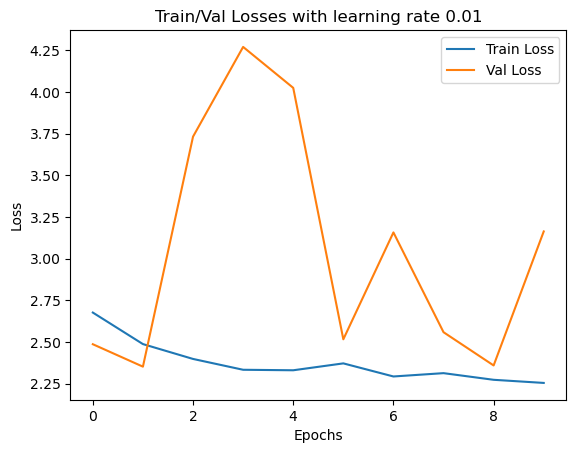

train_losses=[2.6764447228950368, 2.4874027151810494, 2.3983178326958106, 2.333368668082165, 2.330351904121756, 2.371694560636554, 2.2931719704678186, 2.3130907893877977, 2.273248531665021, 2.2545091401763826]
[2.486560745881154, 2.352058183688384, 3.731223294368157, 4.269384003602541, 4.02390553859564, 2.516049733528724, 3.157042024227289, 2.55860979281939, 2.359222485468938, 3.162868421811324]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 107.56it/s]

Epoch [1/10], Train Loss: 2.6969, Train Accuracy: 15.73%, Val Loss: 2.5586, Val Accuracy: 24.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.75it/s]

Epoch [2/10], Train Loss: 2.4935, Train Accuracy: 22.75%, Val Loss: 2.7909, Val Accuracy: 10.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.23it/s]

Epoch [3/10], Train Loss: 2.5372, Train Accuracy: 20.04%, Val Loss: 3.4839, Val Accuracy: 16.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.22it/s]

Epoch [4/10], Train Loss: 2.5160, Train Accuracy: 20.63%, Val Loss: 2.8337, Val Accuracy: 17.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.89it/s]

Epoch [5/10], Train Loss: 2.5330, Train Accuracy: 19.60%, Val Loss: 2.6926, Val Accuracy: 15.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.42it/s]

Epoch [6/10], Train Loss: 2.5037, Train Accuracy: 19.31%, Val Loss: 2.6677, Val Accuracy: 16.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.62it/s]

Epoch [7/10], Train Loss: 2.4652, Train Accuracy: 21.29%, Val Loss: 15.8505, Val Accuracy: 4.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.63it/s]

Epoch [8/10], Train Loss: 2.4560, Train Accuracy: 21.65%, Val Loss: 2.9778, Val Accuracy: 18.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.31it/s]

Epoch [9/10], Train Loss: 2.4756, Train Accuracy: 21.21%, Val Loss: 3.9246, Val Accuracy: 12.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.19it/s]

Epoch [10/10], Train Loss: 2.4599, Train Accuracy: 20.99%, Val Loss: 2.7679, Val Accuracy: 18.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 68.75it/s]


Test Accuracy with learning rate 0.01: 13.64%


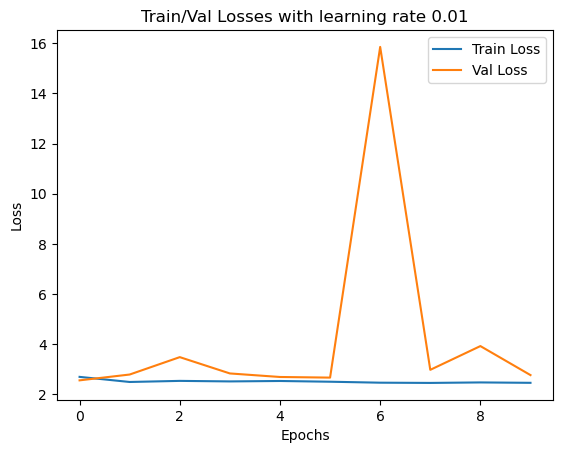

train_losses=[2.69693742858039, 2.493545030989842, 2.537223614447298, 2.515974654091729, 2.5330210338559067, 2.503651294094777, 2.4652086412697507, 2.4559519541891, 2.475647489229838, 2.459871529138576]
[2.558572388612307, 2.7908743298970737, 3.4839167778308573, 2.8337206473717322, 2.6926198395398946, 2.6677471491006703, 15.85052644289457, 2.977763343315858, 3.9245606385744534, 2.7678751876721015]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 109.32it/s]

Epoch [1/10], Train Loss: 2.7459, Train Accuracy: 14.41%, Val Loss: 2.8634, Val Accuracy: 13.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.01it/s]

Epoch [2/10], Train Loss: 2.6669, Train Accuracy: 17.70%, Val Loss: 3.6303, Val Accuracy: 9.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 116.33it/s]

Epoch [3/10], Train Loss: 2.7041, Train Accuracy: 13.53%, Val Loss: 2.9842, Val Accuracy: 11.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.87it/s]

Epoch [4/10], Train Loss: 2.7202, Train Accuracy: 12.87%, Val Loss: 4.8614, Val Accuracy: 3.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.89it/s]

Epoch [5/10], Train Loss: 2.7357, Train Accuracy: 14.34%, Val Loss: 3.1824, Val Accuracy: 7.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.97it/s]

Epoch [6/10], Train Loss: 2.7394, Train Accuracy: 13.68%, Val Loss: 3.5812, Val Accuracy: 3.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.27it/s]

Epoch [7/10], Train Loss: 2.7353, Train Accuracy: 14.41%, Val Loss: 3.2013, Val Accuracy: 10.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.30it/s]

Epoch [8/10], Train Loss: 2.7321, Train Accuracy: 14.63%, Val Loss: 2.8034, Val Accuracy: 13.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.44it/s]

Epoch [9/10], Train Loss: 2.7305, Train Accuracy: 13.61%, Val Loss: 3.0524, Val Accuracy: 4.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.54it/s]

Epoch [10/10], Train Loss: 2.7175, Train Accuracy: 14.78%, Val Loss: 3.2913, Val Accuracy: 13.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 66.11it/s]


Test Accuracy with learning rate 0.01: 11.36%


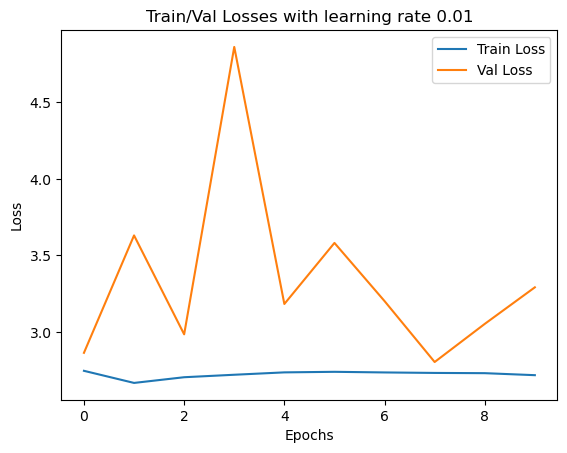

train_losses=[2.745928015625268, 2.6668526247928015, 2.7040578440616003, 2.7202274924830387, 2.7357412249024153, 2.7393912697396083, 2.735329152547825, 2.7321342027675337, 2.7305370743511714, 2.717450083347789]
[2.8634320956010084, 3.6302924431287327, 2.984236256434367, 4.861444014769334, 3.1824429035186768, 3.581238329410553, 3.201279718142289, 2.8034020845706644, 3.052418149434603, 3.291253763895768]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 109.28it/s]

Epoch [1/10], Train Loss: 2.6823, Train Accuracy: 18.65%, Val Loss: 2.3504, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.83it/s]

Epoch [2/10], Train Loss: 2.3171, Train Accuracy: 30.29%, Val Loss: 2.1278, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.52it/s]

Epoch [3/10], Train Loss: 2.1233, Train Accuracy: 36.43%, Val Loss: 2.1578, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.85it/s]

Epoch [4/10], Train Loss: 1.9585, Train Accuracy: 42.50%, Val Loss: 1.9125, Val Accuracy: 42.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.77it/s]

Epoch [5/10], Train Loss: 1.8552, Train Accuracy: 46.16%, Val Loss: 1.9626, Val Accuracy: 46.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.80it/s]

Epoch [6/10], Train Loss: 1.7539, Train Accuracy: 51.57%, Val Loss: 1.9164, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.81it/s]

Epoch [7/10], Train Loss: 1.6068, Train Accuracy: 56.25%, Val Loss: 2.0144, Val Accuracy: 40.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.60it/s]

Epoch [8/10], Train Loss: 1.5841, Train Accuracy: 57.06%, Val Loss: 2.1557, Val Accuracy: 37.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.46it/s]

Epoch [9/10], Train Loss: 1.5367, Train Accuracy: 57.13%, Val Loss: 2.1030, Val Accuracy: 37.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.36it/s]

Epoch [10/10], Train Loss: 1.4938, Train Accuracy: 59.62%, Val Loss: 2.0954, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.75it/s]


Test Accuracy with learning rate 0.001: 40.91%


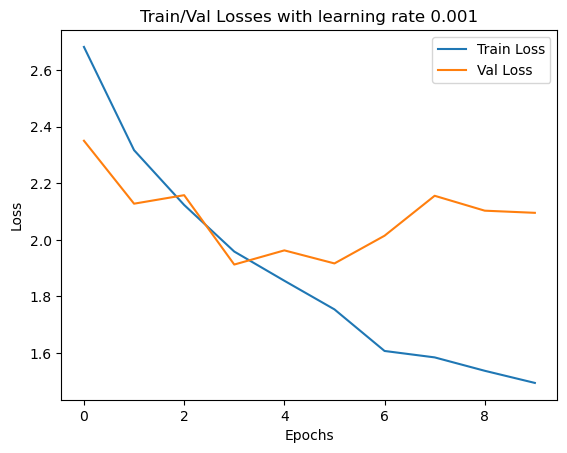

train_losses=[2.6822649512374612, 2.3171118504819814, 2.1232767774347674, 1.9584583274105138, 1.8551518687030726, 1.7538664933533696, 1.6068047877640752, 1.58407361535301, 1.5366764347455655, 1.493769183144932]
[2.3504063418278327, 2.1277510798894443, 2.1578269715492544, 1.9124792378682356, 1.9625981587630053, 1.916431922179002, 2.0144436359405518, 2.1557343166608076, 2.103023338776368, 2.0954282742280226]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 105.90it/s]

Epoch [1/10], Train Loss: 2.6084, Train Accuracy: 19.17%, Val Loss: 2.3544, Val Accuracy: 29.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.07it/s]

Epoch [2/10], Train Loss: 2.3236, Train Accuracy: 28.53%, Val Loss: 2.1370, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.76it/s]

Epoch [3/10], Train Loss: 2.1992, Train Accuracy: 33.80%, Val Loss: 2.1782, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.46it/s]

Epoch [4/10], Train Loss: 2.0725, Train Accuracy: 38.33%, Val Loss: 2.1429, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.05it/s]

Epoch [5/10], Train Loss: 2.0353, Train Accuracy: 37.82%, Val Loss: 2.7434, Val Accuracy: 18.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.32it/s]

Epoch [6/10], Train Loss: 1.9949, Train Accuracy: 39.72%, Val Loss: 2.4473, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 116.87it/s]

Epoch [7/10], Train Loss: 1.9479, Train Accuracy: 40.67%, Val Loss: 2.3189, Val Accuracy: 27.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.94it/s]

Epoch [8/10], Train Loss: 1.9622, Train Accuracy: 39.94%, Val Loss: 2.0853, Val Accuracy: 39.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.65it/s]

Epoch [9/10], Train Loss: 1.9564, Train Accuracy: 40.45%, Val Loss: 2.1146, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.38it/s]

Epoch [10/10], Train Loss: 1.8505, Train Accuracy: 45.72%, Val Loss: 2.1273, Val Accuracy: 29.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.77it/s]


Test Accuracy with learning rate 0.001: 28.41%


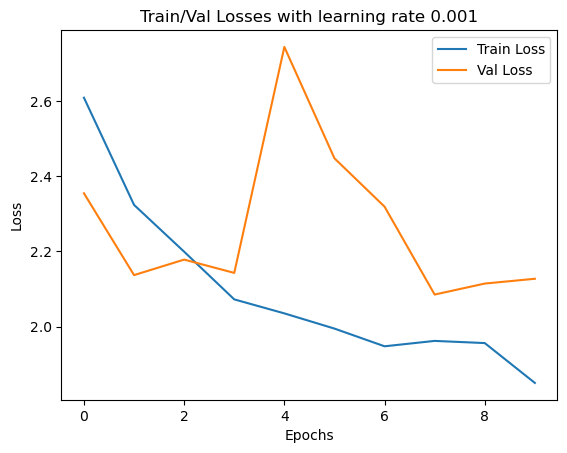

train_losses=[2.6084378183933725, 2.3235871506016155, 2.199205072302567, 2.072529737712347, 2.0353223824361613, 1.9949103133720265, 1.9478687236183567, 1.9622043991646572, 1.956433001317476, 1.8505447607988503]
[2.3544310491818647, 2.137019239939176, 2.1782470712294946, 2.1428852791969595, 2.7433591232850003, 2.4473401468533735, 2.3189310248081503, 2.085348170537215, 2.1145558769886312, 2.1272976513092337]
Training with learning rate: 0.001


100%|██████████| 52/52 [00:00<00:00, 102.03it/s]

Epoch [1/10], Train Loss: 2.6205, Train Accuracy: 20.70%, Val Loss: 2.4215, Val Accuracy: 23.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.59it/s]

Epoch [2/10], Train Loss: 2.4006, Train Accuracy: 25.02%, Val Loss: 2.5022, Val Accuracy: 21.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.81it/s]

Epoch [3/10], Train Loss: 2.3174, Train Accuracy: 27.58%, Val Loss: 2.9093, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.15it/s]

Epoch [4/10], Train Loss: 2.3445, Train Accuracy: 27.58%, Val Loss: 2.8288, Val Accuracy: 11.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.28it/s]

Epoch [5/10], Train Loss: 2.3510, Train Accuracy: 27.43%, Val Loss: 2.7235, Val Accuracy: 18.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.60it/s]

Epoch [6/10], Train Loss: 2.3412, Train Accuracy: 29.41%, Val Loss: 2.7586, Val Accuracy: 14.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.93it/s]

Epoch [7/10], Train Loss: 2.3670, Train Accuracy: 27.43%, Val Loss: 2.6602, Val Accuracy: 21.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.45it/s]

Epoch [8/10], Train Loss: 2.3338, Train Accuracy: 28.90%, Val Loss: 2.5896, Val Accuracy: 24.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.44it/s]

Epoch [9/10], Train Loss: 2.3218, Train Accuracy: 28.16%, Val Loss: 2.7217, Val Accuracy: 19.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.95it/s]

Epoch [10/10], Train Loss: 2.3272, Train Accuracy: 28.24%, Val Loss: 2.7115, Val Accuracy: 21.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.09it/s]


Test Accuracy with learning rate 0.001: 20.45%


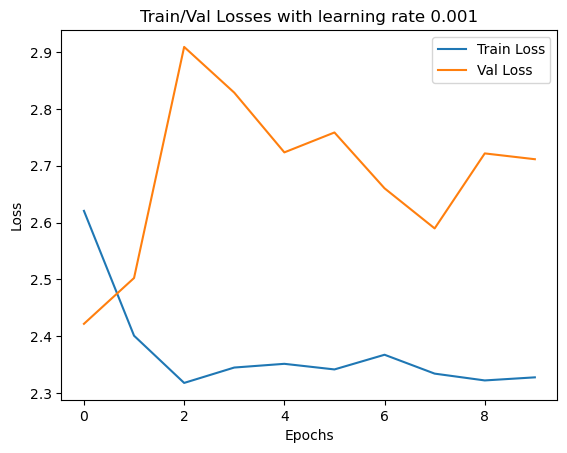

train_losses=[2.6204856912992156, 2.4005725585926347, 2.3173945075587223, 2.344487742373818, 2.351044739896094, 2.341159557041369, 2.3670287208947522, 2.333774715139155, 2.3217790663590905, 2.3272136631067735]
[2.421513917354437, 2.50223499078017, 2.9093264157955465, 2.8287852933773627, 2.723540276288986, 2.7586004676727147, 2.6602425368932576, 2.5895856733505545, 2.721724510192871, 2.711489599484664]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 108.67it/s]

Epoch [1/10], Train Loss: 2.6770, Train Accuracy: 17.56%, Val Loss: 2.4474, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.98it/s]

Epoch [2/10], Train Loss: 2.4584, Train Accuracy: 23.56%, Val Loss: 2.3206, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.37it/s]

Epoch [3/10], Train Loss: 2.3126, Train Accuracy: 25.46%, Val Loss: 2.1890, Val Accuracy: 30.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.60it/s]

Epoch [4/10], Train Loss: 2.2080, Train Accuracy: 29.77%, Val Loss: 2.4588, Val Accuracy: 23.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.02it/s]

Epoch [5/10], Train Loss: 2.1792, Train Accuracy: 30.14%, Val Loss: 2.1780, Val Accuracy: 30.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.10it/s]

Epoch [6/10], Train Loss: 2.0970, Train Accuracy: 32.48%, Val Loss: 2.6553, Val Accuracy: 24.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.84it/s]

Epoch [7/10], Train Loss: 2.0876, Train Accuracy: 33.80%, Val Loss: 2.3620, Val Accuracy: 26.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.31it/s]

Epoch [8/10], Train Loss: 2.0251, Train Accuracy: 34.97%, Val Loss: 1.9901, Val Accuracy: 39.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.91it/s]

Epoch [9/10], Train Loss: 1.9968, Train Accuracy: 35.26%, Val Loss: 2.1327, Val Accuracy: 30.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.45it/s]

Epoch [10/10], Train Loss: 1.9429, Train Accuracy: 37.02%, Val Loss: 2.5798, Val Accuracy: 24.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 61.04it/s]


Test Accuracy with learning rate 0.01: 17.05%


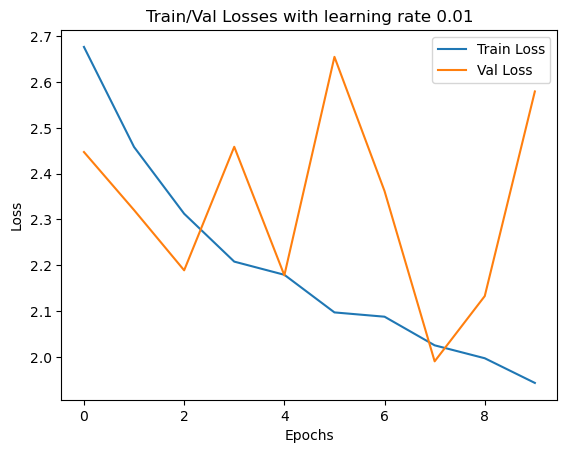

train_losses=[2.6770305605659708, 2.4584186202601384, 2.312608510430096, 2.207950442157991, 2.1791762050829435, 2.096974982155694, 2.087590629594368, 2.025060438273246, 1.9968244799396448, 1.942916598933482]
[2.4474141872846165, 2.3205969539972453, 2.1889617420159855, 2.4588302282186656, 2.1779982974896064, 2.655333466254748, 2.3620303800472846, 1.9900701596186712, 2.1326690981021295, 2.579752048620811]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 107.69it/s]

Epoch [1/10], Train Loss: 2.7142, Train Accuracy: 16.83%, Val Loss: 2.4946, Val Accuracy: 20.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.30it/s]

Epoch [2/10], Train Loss: 2.4331, Train Accuracy: 23.85%, Val Loss: 2.8761, Val Accuracy: 11.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.12it/s]

Epoch [3/10], Train Loss: 2.3852, Train Accuracy: 24.65%, Val Loss: 3.9120, Val Accuracy: 10.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.27it/s]

Epoch [4/10], Train Loss: 2.3840, Train Accuracy: 26.77%, Val Loss: 2.9850, Val Accuracy: 18.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.53it/s]

Epoch [5/10], Train Loss: 2.3636, Train Accuracy: 25.02%, Val Loss: 2.7556, Val Accuracy: 14.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.10it/s]

Epoch [6/10], Train Loss: 2.3241, Train Accuracy: 25.60%, Val Loss: 2.8687, Val Accuracy: 18.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.83it/s]

Epoch [7/10], Train Loss: 2.3463, Train Accuracy: 25.16%, Val Loss: 3.5315, Val Accuracy: 15.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.84it/s]

Epoch [8/10], Train Loss: 2.3442, Train Accuracy: 23.70%, Val Loss: 3.3584, Val Accuracy: 19.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.66it/s]

Epoch [9/10], Train Loss: 2.3330, Train Accuracy: 25.60%, Val Loss: 3.2860, Val Accuracy: 13.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.58it/s]

Epoch [10/10], Train Loss: 2.2982, Train Accuracy: 27.21%, Val Loss: 2.8301, Val Accuracy: 16.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 61.05it/s]


Test Accuracy with learning rate 0.01: 11.93%


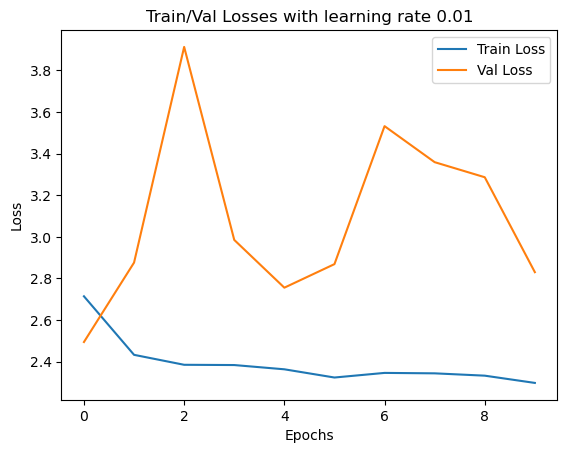

train_losses=[2.7142087688222962, 2.4330584751932243, 2.385236488448249, 2.384008913012276, 2.363567935095893, 2.3241098589367337, 2.3462598874554996, 2.3441629228536147, 2.333012658950181, 2.2981525952355906]
[2.4945997985509725, 2.87605059834627, 3.911987433066735, 2.98501655459404, 2.7556363412967095, 2.86873267017878, 3.5314802733751445, 3.3584360663707438, 3.2860487424410305, 2.830068916082382]
Training with learning rate: 0.01


100%|██████████| 52/52 [00:00<00:00, 104.58it/s]

Epoch [1/10], Train Loss: 2.7648, Train Accuracy: 15.44%, Val Loss: 2.8598, Val Accuracy: 12.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.21it/s]

Epoch [2/10], Train Loss: 2.6089, Train Accuracy: 19.39%, Val Loss: 3.0886, Val Accuracy: 12.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.30it/s]

Epoch [3/10], Train Loss: 2.5819, Train Accuracy: 20.85%, Val Loss: 3.1512, Val Accuracy: 10.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.90it/s]

Epoch [4/10], Train Loss: 2.5824, Train Accuracy: 18.65%, Val Loss: 2.8122, Val Accuracy: 15.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.00it/s]

Epoch [5/10], Train Loss: 2.5971, Train Accuracy: 18.80%, Val Loss: 3.0114, Val Accuracy: 11.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.09it/s]

Epoch [6/10], Train Loss: 2.5581, Train Accuracy: 19.31%, Val Loss: 3.0181, Val Accuracy: 14.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.41it/s]

Epoch [7/10], Train Loss: 2.5872, Train Accuracy: 18.58%, Val Loss: 2.7326, Val Accuracy: 20.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.89it/s]

Epoch [8/10], Train Loss: 2.5951, Train Accuracy: 17.70%, Val Loss: 2.7827, Val Accuracy: 17.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.84it/s]

Epoch [9/10], Train Loss: 2.5725, Train Accuracy: 17.85%, Val Loss: 2.9148, Val Accuracy: 10.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.13it/s]

Epoch [10/10], Train Loss: 2.5796, Train Accuracy: 18.58%, Val Loss: 2.5675, Val Accuracy: 18.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.48it/s]


Test Accuracy with learning rate 0.01: 18.18%


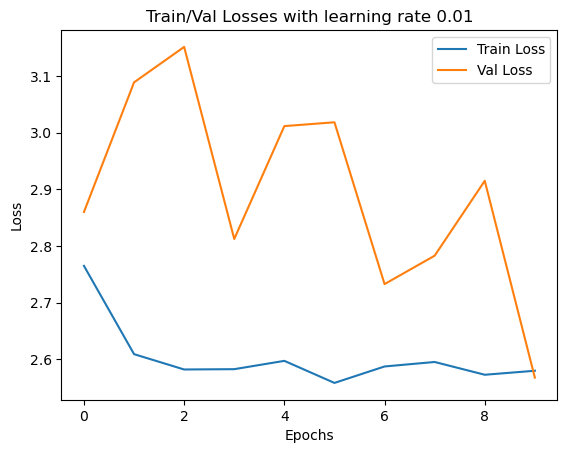

train_losses=[2.764750247810319, 2.608917934852734, 2.581850404627839, 2.5824155570470797, 2.597071275376437, 2.558138496694509, 2.5871661057946276, 2.5951050192291976, 2.5725480931544165, 2.579616355617144]
[2.859817142669971, 3.08860038794004, 3.1511559669788065, 2.8121967086425195, 3.011402428150177, 3.0181459417709937, 2.732568988433251, 2.7826960316071143, 2.91482059772198, 2.567502347322611]


In [40]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

# Обучение модели
num_epochs = 10
weight_decay_list = [0.0001, 0.001, 0.01]
learning_rates = [0.001, 0.01]
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]

for opt in optimizers:
    for lr in learning_rates:
        for w in weight_decay_list:
            # Определение модели
            model = MyClassificationBatchNormalizationNet(input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3, hidden_size=1024, output_size=20).to(device)

            print(f"Training with learning rate: {lr}")
            train_losses, val_losses, res_with_batch_norm = train(model, opt, train_data_loader, val_data_loader, num_epochs, lr, weight_decay=w, res=res_with_batch_norm)

            # Оценка качества модели на тестовой выборке
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
                    images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            accuracy = correct / total
            print(f"Test Accuracy with learning rate {lr}: {100 * accuracy:.2f}%")

            # 6. Анализ графиков train/val loss
            plt.plot(range(num_epochs), train_losses, label='Train Loss')
            plt.plot(range(num_epochs), val_losses, label='Val Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title(f'Train/Val Losses with learning rate {lr}')
            plt.legend()
            plt.show()

            print(f"{train_losses=}\n{val_losses}")

In [41]:
res_with_batch_norm

,optimizer,learning_rate,weight_decay,val_accuracy
0,SGD,0.001,0.0001,0.473171
0,SGD,0.001,0.0010,0.443902
0,SGD,0.001,0.0100,0.480488
0,SGD,0.010,0.0001,0.439024
0,SGD,0.010,0.0010,0.460976
0,SGD,0.010,0.0100,0.446341
0,RMSprop,0.001,0.0001,0.424390
0,RMSprop,0.001,0.0010,0.331707
0,RMSprop,0.001,0.0100,0.246341
0,RMSprop,0.010,0.0001,0.290244


## Retraining best on 50 epoch

As I see, Butterfly Classification Net with BatchNormalization can achieve bigger results if we give it more time.

Params lr=0.001, w=0.01, opt=<class 'torch.optim.sgd.SGD'>


100%|██████████| 52/52 [00:00<00:00, 111.37it/s]

Epoch [1/50], Train Loss: 2.4947, Train Accuracy: 23.12%, Val Loss: 2.1881, Val Accuracy: 36.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.32it/s]

Epoch [2/50], Train Loss: 1.9810, Train Accuracy: 44.04%, Val Loss: 2.2354, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.03it/s]

Epoch [3/50], Train Loss: 1.7880, Train Accuracy: 53.99%, Val Loss: 2.1482, Val Accuracy: 36.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.63it/s]

Epoch [4/50], Train Loss: 1.6417, Train Accuracy: 61.52%, Val Loss: 2.1804, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.62it/s]

Epoch [5/50], Train Loss: 1.5743, Train Accuracy: 67.52%, Val Loss: 2.0128, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.53it/s]

Epoch [6/50], Train Loss: 1.5084, Train Accuracy: 71.10%, Val Loss: 2.1295, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.44it/s]

Epoch [7/50], Train Loss: 1.4325, Train Accuracy: 75.79%, Val Loss: 1.9828, Val Accuracy: 47.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.13it/s]

Epoch [8/50], Train Loss: 1.4121, Train Accuracy: 76.52%, Val Loss: 2.0607, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.66it/s]

Epoch [9/50], Train Loss: 1.3697, Train Accuracy: 78.64%, Val Loss: 2.0840, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.30it/s]

Epoch [10/50], Train Loss: 1.3520, Train Accuracy: 79.88%, Val Loss: 2.0365, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.14it/s]

Epoch [11/50], Train Loss: 1.3283, Train Accuracy: 81.42%, Val Loss: 2.0426, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.60it/s]

Epoch [12/50], Train Loss: 1.3233, Train Accuracy: 81.57%, Val Loss: 1.9478, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.09it/s]

Epoch [13/50], Train Loss: 1.2697, Train Accuracy: 84.49%, Val Loss: 2.0599, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.06it/s]

Epoch [14/50], Train Loss: 1.2400, Train Accuracy: 86.17%, Val Loss: 2.0820, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.68it/s]

Epoch [15/50], Train Loss: 1.2275, Train Accuracy: 86.91%, Val Loss: 2.0038, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.25it/s]

Epoch [16/50], Train Loss: 1.2162, Train Accuracy: 87.64%, Val Loss: 2.0222, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.69it/s]

Epoch [17/50], Train Loss: 1.2228, Train Accuracy: 87.20%, Val Loss: 2.0231, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.00it/s]

Epoch [18/50], Train Loss: 1.1824, Train Accuracy: 89.32%, Val Loss: 2.0826, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.88it/s]

Epoch [19/50], Train Loss: 1.1787, Train Accuracy: 89.25%, Val Loss: 2.0661, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.01it/s]

Epoch [20/50], Train Loss: 1.1597, Train Accuracy: 88.30%, Val Loss: 2.0503, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.10it/s]

Epoch [21/50], Train Loss: 1.1464, Train Accuracy: 89.32%, Val Loss: 2.0373, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.93it/s]

Epoch [22/50], Train Loss: 1.1016, Train Accuracy: 91.37%, Val Loss: 2.1042, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 119.87it/s]

Epoch [23/50], Train Loss: 1.1126, Train Accuracy: 89.32%, Val Loss: 2.0388, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.58it/s]

Epoch [24/50], Train Loss: 1.1023, Train Accuracy: 90.56%, Val Loss: 1.9943, Val Accuracy: 46.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.09it/s]

Epoch [25/50], Train Loss: 1.0954, Train Accuracy: 89.98%, Val Loss: 2.0566, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.83it/s]

Epoch [26/50], Train Loss: 1.0597, Train Accuracy: 92.10%, Val Loss: 1.9919, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.10it/s]

Epoch [27/50], Train Loss: 1.0569, Train Accuracy: 91.29%, Val Loss: 1.9976, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 116.28it/s]

Epoch [28/50], Train Loss: 1.0601, Train Accuracy: 90.86%, Val Loss: 2.0460, Val Accuracy: 42.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.95it/s]

Epoch [29/50], Train Loss: 1.0199, Train Accuracy: 91.81%, Val Loss: 2.2313, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.76it/s]

Epoch [30/50], Train Loss: 1.0173, Train Accuracy: 92.32%, Val Loss: 2.0603, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.90it/s]

Epoch [31/50], Train Loss: 1.0257, Train Accuracy: 92.98%, Val Loss: 2.0384, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.18it/s]

Epoch [32/50], Train Loss: 1.0140, Train Accuracy: 91.22%, Val Loss: 2.0811, Val Accuracy: 40.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.03it/s]

Epoch [33/50], Train Loss: 0.9797, Train Accuracy: 93.42%, Val Loss: 2.0865, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.11it/s]

Epoch [34/50], Train Loss: 0.9900, Train Accuracy: 92.17%, Val Loss: 2.0400, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 115.60it/s]

Epoch [35/50], Train Loss: 0.9842, Train Accuracy: 91.66%, Val Loss: 1.9627, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.20it/s]

Epoch [36/50], Train Loss: 0.9674, Train Accuracy: 93.34%, Val Loss: 2.0785, Val Accuracy: 39.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.57it/s]

Epoch [37/50], Train Loss: 0.9428, Train Accuracy: 93.64%, Val Loss: 2.0068, Val Accuracy: 46.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.02it/s]

Epoch [38/50], Train Loss: 0.9425, Train Accuracy: 93.64%, Val Loss: 1.9693, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.32it/s]

Epoch [39/50], Train Loss: 0.9695, Train Accuracy: 92.47%, Val Loss: 2.0596, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.43it/s]

Epoch [40/50], Train Loss: 0.9265, Train Accuracy: 93.93%, Val Loss: 2.1086, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.97it/s]


Epoch [41/50], Train Loss: 0.9138, Train Accuracy: 93.34%, Val Loss: 2.0067, Val Accuracy: 44.88%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.50it/s]

Epoch [42/50], Train Loss: 0.8814, Train Accuracy: 95.03%, Val Loss: 2.0705, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.73it/s]

Epoch [43/50], Train Loss: 0.9207, Train Accuracy: 93.12%, Val Loss: 2.0030, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.22it/s]

Epoch [44/50], Train Loss: 0.8835, Train Accuracy: 94.51%, Val Loss: 1.9957, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.99it/s]

Epoch [45/50], Train Loss: 0.8901, Train Accuracy: 93.56%, Val Loss: 1.9988, Val Accuracy: 47.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.30it/s]

Epoch [46/50], Train Loss: 0.8746, Train Accuracy: 94.22%, Val Loss: 2.0453, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.83it/s]

Epoch [47/50], Train Loss: 0.8874, Train Accuracy: 93.71%, Val Loss: 2.0677, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.51it/s]

Epoch [48/50], Train Loss: 0.8631, Train Accuracy: 94.07%, Val Loss: 2.0534, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.33it/s]

Epoch [49/50], Train Loss: 0.8727, Train Accuracy: 94.73%, Val Loss: 1.9966, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.57it/s]

Epoch [50/50], Train Loss: 0.8672, Train Accuracy: 94.44%, Val Loss: 2.0413, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 67.80it/s]


Test Accuracy: 46.02%


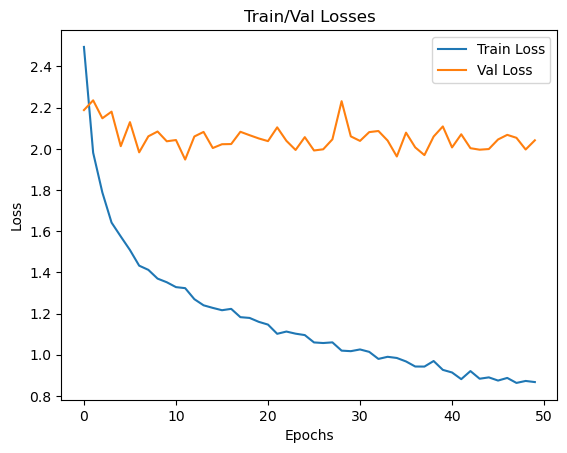

train_losses=[2.494741437727945, 1.9809821195769728, 1.787978774622867, 1.6417200586252045, 1.574302339414407, 1.5084230000512642, 1.4325388690881562, 1.4121129331532976, 1.3696554285740992, 1.3520058079769737, 1.3283137096996196, 1.3232936765018262, 1.2697136450929252, 1.2400251424800584, 1.2274550237850836, 1.2161517809008995, 1.222777177367294, 1.1824429244325871, 1.1787143680784438, 1.1596871597027918, 1.1463628728487338, 1.1016203311451696, 1.1125860402458592, 1.1022629967907018, 1.0954055392254165, 1.0597290271206905, 1.0568648559308191, 1.06006406866319, 1.0199008489909924, 1.0173178147851376, 1.0256701610241716, 1.0139670128013656, 0.9796845379628634, 0.9899742470847236, 0.9842411907095658, 0.9673692172730876, 0.9428065014861481, 0.9424953296867727, 0.9694681202459057, 0.9265073098634419, 0.9138237513296785, 0.8813808375631856, 0.9206505006516886, 0.8834891221676654, 0.8900588133878875, 0.8745563929541069, 0.8873640574209871, 0.8631164462942826, 0.8727231886651781, 0.8672280510

100%|██████████| 52/52 [00:00<00:00, 109.74it/s]

Epoch [1/50], Train Loss: 2.4796, Train Accuracy: 24.80%, Val Loss: 2.2335, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 114.60it/s]

Epoch [2/50], Train Loss: 1.9565, Train Accuracy: 45.06%, Val Loss: 2.1433, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.65it/s]

Epoch [3/50], Train Loss: 1.7412, Train Accuracy: 56.18%, Val Loss: 2.2019, Val Accuracy: 37.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.00it/s]

Epoch [4/50], Train Loss: 1.6475, Train Accuracy: 62.03%, Val Loss: 2.0255, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.81it/s]

Epoch [5/50], Train Loss: 1.5460, Train Accuracy: 67.23%, Val Loss: 2.0847, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.94it/s]

Epoch [6/50], Train Loss: 1.4572, Train Accuracy: 74.25%, Val Loss: 2.0176, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 78.52it/s] 

Epoch [7/50], Train Loss: 1.4436, Train Accuracy: 75.42%, Val Loss: 2.0207, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.75it/s]

Epoch [8/50], Train Loss: 1.3935, Train Accuracy: 77.69%, Val Loss: 1.9713, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.32it/s]

Epoch [9/50], Train Loss: 1.3728, Train Accuracy: 78.93%, Val Loss: 2.0496, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.97it/s]

Epoch [10/50], Train Loss: 1.3088, Train Accuracy: 82.66%, Val Loss: 2.0739, Val Accuracy: 42.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.25it/s]

Epoch [11/50], Train Loss: 1.3155, Train Accuracy: 82.37%, Val Loss: 2.1520, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.17it/s]

Epoch [12/50], Train Loss: 1.2831, Train Accuracy: 84.56%, Val Loss: 1.9364, Val Accuracy: 47.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.86it/s]

Epoch [13/50], Train Loss: 1.2497, Train Accuracy: 85.74%, Val Loss: 1.9505, Val Accuracy: 47.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.84it/s]

Epoch [14/50], Train Loss: 1.2183, Train Accuracy: 86.91%, Val Loss: 1.9452, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.76it/s]

Epoch [15/50], Train Loss: 1.2097, Train Accuracy: 86.03%, Val Loss: 2.1738, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.48it/s]

Epoch [16/50], Train Loss: 1.1673, Train Accuracy: 88.51%, Val Loss: 2.0870, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.77it/s]

Epoch [17/50], Train Loss: 1.1821, Train Accuracy: 88.22%, Val Loss: 2.0937, Val Accuracy: 39.27%



Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/alex/anaconda3/lib/python3.11/shutil.py", line 738, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/alex/anaconda3/lib/python3.11/shutil.py", line 736, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-k2o14ka3'


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.20it/s]

Epoch [18/50], Train Loss: 1.1478, Train Accuracy: 89.25%, Val Loss: 2.2161, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.48it/s]

Epoch [19/50], Train Loss: 1.1358, Train Accuracy: 88.30%, Val Loss: 2.0329, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.85it/s]

Epoch [20/50], Train Loss: 1.1082, Train Accuracy: 89.47%, Val Loss: 2.0771, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.75it/s]

Epoch [21/50], Train Loss: 1.0975, Train Accuracy: 90.42%, Val Loss: 2.0731, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.47it/s]

Epoch [22/50], Train Loss: 1.0788, Train Accuracy: 91.88%, Val Loss: 2.0228, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.46it/s]

Epoch [23/50], Train Loss: 1.0761, Train Accuracy: 90.34%, Val Loss: 2.1023, Val Accuracy: 40.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.88it/s]

Epoch [24/50], Train Loss: 1.0461, Train Accuracy: 90.64%, Val Loss: 2.4244, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.55it/s]

Epoch [25/50], Train Loss: 1.0350, Train Accuracy: 91.66%, Val Loss: 2.0430, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.38it/s]

Epoch [26/50], Train Loss: 1.0281, Train Accuracy: 91.00%, Val Loss: 2.0789, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.63it/s]

Epoch [27/50], Train Loss: 0.9805, Train Accuracy: 93.93%, Val Loss: 2.0321, Val Accuracy: 41.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.48it/s]

Epoch [28/50], Train Loss: 1.0034, Train Accuracy: 92.90%, Val Loss: 2.1078, Val Accuracy: 46.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.35it/s]

Epoch [29/50], Train Loss: 0.9677, Train Accuracy: 93.49%, Val Loss: 2.0210, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.36it/s]

Epoch [30/50], Train Loss: 0.9634, Train Accuracy: 92.10%, Val Loss: 2.0291, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 111.04it/s]

Epoch [31/50], Train Loss: 0.9380, Train Accuracy: 93.34%, Val Loss: 2.0342, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.72it/s]

Epoch [32/50], Train Loss: 0.9537, Train Accuracy: 93.20%, Val Loss: 2.0737, Val Accuracy: 40.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.07it/s]

Epoch [33/50], Train Loss: 0.9557, Train Accuracy: 92.98%, Val Loss: 2.0748, Val Accuracy: 44.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.32it/s]

Epoch [34/50], Train Loss: 0.9210, Train Accuracy: 92.76%, Val Loss: 2.0260, Val Accuracy: 46.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.60it/s]

Epoch [35/50], Train Loss: 0.9092, Train Accuracy: 93.05%, Val Loss: 2.0438, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.10it/s]

Epoch [36/50], Train Loss: 0.8971, Train Accuracy: 94.07%, Val Loss: 1.9646, Val Accuracy: 48.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.09it/s]

Epoch [37/50], Train Loss: 0.8862, Train Accuracy: 94.51%, Val Loss: 2.0742, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.38it/s]

Epoch [38/50], Train Loss: 0.8903, Train Accuracy: 94.07%, Val Loss: 2.0643, Val Accuracy: 43.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.30it/s]

Epoch [39/50], Train Loss: 0.8658, Train Accuracy: 94.81%, Val Loss: 2.0127, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.23it/s]

Epoch [40/50], Train Loss: 0.8475, Train Accuracy: 94.95%, Val Loss: 2.1033, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.58it/s]

Epoch [41/50], Train Loss: 0.8638, Train Accuracy: 93.56%, Val Loss: 2.1517, Val Accuracy: 37.56%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.95it/s]

Epoch [42/50], Train Loss: 0.8764, Train Accuracy: 94.07%, Val Loss: 2.1018, Val Accuracy: 43.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.45it/s]

Epoch [43/50], Train Loss: 0.8371, Train Accuracy: 95.03%, Val Loss: 2.0043, Val Accuracy: 46.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.39it/s]

Epoch [44/50], Train Loss: 0.8274, Train Accuracy: 94.59%, Val Loss: 2.1451, Val Accuracy: 40.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.29it/s]

Epoch [45/50], Train Loss: 0.8290, Train Accuracy: 94.81%, Val Loss: 2.0109, Val Accuracy: 45.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.34it/s]

Epoch [46/50], Train Loss: 0.8154, Train Accuracy: 94.81%, Val Loss: 2.0666, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.90it/s]

Epoch [47/50], Train Loss: 0.8113, Train Accuracy: 94.59%, Val Loss: 2.0629, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.41it/s]

Epoch [48/50], Train Loss: 0.8000, Train Accuracy: 95.54%, Val Loss: 2.0301, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.93it/s]

Epoch [49/50], Train Loss: 0.7742, Train Accuracy: 95.76%, Val Loss: 2.0370, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.27it/s]

Epoch [50/50], Train Loss: 0.7562, Train Accuracy: 96.42%, Val Loss: 2.0793, Val Accuracy: 40.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 65.99it/s]


Test Accuracy: 44.32%


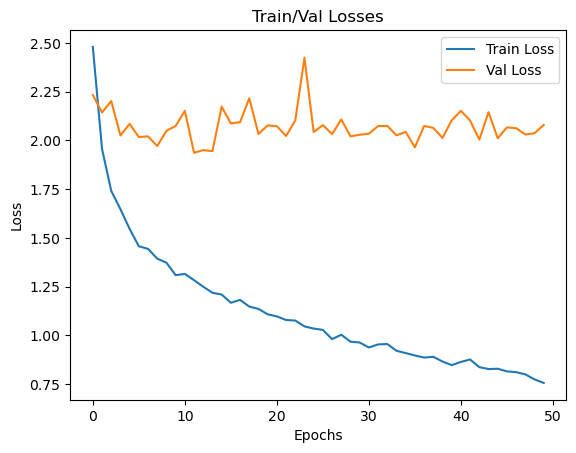

train_losses=[2.4796038831186573, 1.9564527963337146, 1.7412268048838566, 1.6474735987813849, 1.5459598135529904, 1.457249202923468, 1.4436395656295686, 1.3935372132306907, 1.3728477118308084, 1.3088285128275554, 1.3154700987520274, 1.2830791201507836, 1.2497170044664752, 1.2183234890302022, 1.2096858502131456, 1.1673163248781573, 1.1820674740780166, 1.1477770683361075, 1.1358225837088467, 1.1081626376910516, 1.097475892967648, 1.0787857795319362, 1.0761112427850912, 1.0460507538583543, 1.0349655465075844, 1.028086783593161, 0.9805247456009625, 1.0034494881044353, 0.9676873732728568, 0.9633886883830467, 0.937985883121602, 0.9536751825907077, 0.9556816757073876, 0.9209619286464669, 0.9092240113961069, 0.8970734490985759, 0.8862406733440377, 0.8903459554527238, 0.8658488026836462, 0.8474617593469675, 0.8637990655257688, 0.8764013916428326, 0.8371091607021309, 0.8274342104008323, 0.8290060166029902, 0.8154045491539247, 0.8112885857883253, 0.8000459353826199, 0.7742077910412125, 0.75618757

100%|██████████| 52/52 [00:00<00:00, 105.11it/s]

Epoch [1/50], Train Loss: 2.6513, Train Accuracy: 17.34%, Val Loss: 2.3236, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.30it/s]

Epoch [2/50], Train Loss: 2.2940, Train Accuracy: 30.94%, Val Loss: 2.1951, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.70it/s]

Epoch [3/50], Train Loss: 2.1161, Train Accuracy: 36.14%, Val Loss: 2.1253, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.31it/s]

Epoch [4/50], Train Loss: 1.9630, Train Accuracy: 40.97%, Val Loss: 1.9587, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 112.46it/s]

Epoch [5/50], Train Loss: 1.8407, Train Accuracy: 46.74%, Val Loss: 1.9928, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.64it/s]

Epoch [6/50], Train Loss: 1.7374, Train Accuracy: 52.45%, Val Loss: 1.9148, Val Accuracy: 42.44%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.76it/s]

Epoch [7/50], Train Loss: 1.6509, Train Accuracy: 54.94%, Val Loss: 2.0973, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.99it/s]

Epoch [8/50], Train Loss: 1.6004, Train Accuracy: 54.65%, Val Loss: 2.5725, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.84it/s]

Epoch [9/50], Train Loss: 1.5012, Train Accuracy: 59.03%, Val Loss: 2.2348, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.06it/s] 

Epoch [10/50], Train Loss: 1.4560, Train Accuracy: 59.91%, Val Loss: 2.3620, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.11it/s]

Epoch [11/50], Train Loss: 1.4306, Train Accuracy: 63.42%, Val Loss: 1.9640, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.92it/s]

Epoch [12/50], Train Loss: 1.4216, Train Accuracy: 62.25%, Val Loss: 2.8094, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.66it/s]

Epoch [13/50], Train Loss: 1.3497, Train Accuracy: 64.52%, Val Loss: 2.0750, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.97it/s]

Epoch [14/50], Train Loss: 1.2907, Train Accuracy: 67.67%, Val Loss: 2.2590, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.71it/s]

Epoch [15/50], Train Loss: 1.3065, Train Accuracy: 65.98%, Val Loss: 2.1891, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.23it/s]

Epoch [16/50], Train Loss: 1.3130, Train Accuracy: 64.59%, Val Loss: 2.3425, Val Accuracy: 33.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.26it/s]

Epoch [17/50], Train Loss: 1.2322, Train Accuracy: 67.23%, Val Loss: 2.5427, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.27it/s]

Epoch [18/50], Train Loss: 1.2602, Train Accuracy: 65.54%, Val Loss: 2.1979, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.54it/s]

Epoch [19/50], Train Loss: 1.2396, Train Accuracy: 65.98%, Val Loss: 2.3303, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.24it/s]

Epoch [20/50], Train Loss: 1.2602, Train Accuracy: 63.79%, Val Loss: 2.5508, Val Accuracy: 35.61%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.83it/s]

Epoch [21/50], Train Loss: 1.2288, Train Accuracy: 64.74%, Val Loss: 2.4586, Val Accuracy: 37.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.51it/s]

Epoch [22/50], Train Loss: 1.1896, Train Accuracy: 67.08%, Val Loss: 2.5593, Val Accuracy: 29.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.10it/s]

Epoch [23/50], Train Loss: 1.1505, Train Accuracy: 68.40%, Val Loss: 2.4477, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.65it/s]

Epoch [24/50], Train Loss: 1.1391, Train Accuracy: 66.93%, Val Loss: 2.4482, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.00it/s]

Epoch [25/50], Train Loss: 1.1537, Train Accuracy: 68.32%, Val Loss: 2.3520, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.18it/s]

Epoch [26/50], Train Loss: 1.1663, Train Accuracy: 66.50%, Val Loss: 2.5908, Val Accuracy: 37.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.78it/s]

Epoch [27/50], Train Loss: 1.0971, Train Accuracy: 70.01%, Val Loss: 2.2718, Val Accuracy: 36.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.81it/s]

Epoch [28/50], Train Loss: 1.1033, Train Accuracy: 69.57%, Val Loss: 2.3026, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.92it/s]

Epoch [29/50], Train Loss: 1.1251, Train Accuracy: 67.67%, Val Loss: 2.6281, Val Accuracy: 32.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.10it/s]

Epoch [30/50], Train Loss: 1.1247, Train Accuracy: 67.74%, Val Loss: 2.3002, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.97it/s]

Epoch [31/50], Train Loss: 1.0872, Train Accuracy: 68.25%, Val Loss: 2.6672, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.20it/s]

Epoch [32/50], Train Loss: 1.1111, Train Accuracy: 68.69%, Val Loss: 2.4966, Val Accuracy: 32.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.66it/s]

Epoch [33/50], Train Loss: 1.0805, Train Accuracy: 68.98%, Val Loss: 2.5488, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.62it/s]

Epoch [34/50], Train Loss: 1.0754, Train Accuracy: 67.30%, Val Loss: 2.5679, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.28it/s]

Epoch [35/50], Train Loss: 0.9833, Train Accuracy: 72.20%, Val Loss: 2.3090, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.15it/s]

Epoch [36/50], Train Loss: 0.9887, Train Accuracy: 73.01%, Val Loss: 2.8561, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.60it/s]

Epoch [37/50], Train Loss: 1.0373, Train Accuracy: 69.42%, Val Loss: 2.7463, Val Accuracy: 36.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.91it/s]

Epoch [38/50], Train Loss: 1.0147, Train Accuracy: 70.59%, Val Loss: 2.3372, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.46it/s]

Epoch [39/50], Train Loss: 0.9527, Train Accuracy: 73.23%, Val Loss: 2.5171, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.17it/s]

Epoch [40/50], Train Loss: 0.8818, Train Accuracy: 76.01%, Val Loss: 2.7075, Val Accuracy: 31.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.63it/s]

Epoch [41/50], Train Loss: 0.9062, Train Accuracy: 75.64%, Val Loss: 2.4694, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.34it/s]

Epoch [42/50], Train Loss: 0.8954, Train Accuracy: 75.79%, Val Loss: 2.8708, Val Accuracy: 29.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.62it/s]

Epoch [43/50], Train Loss: 0.8676, Train Accuracy: 75.93%, Val Loss: 2.1195, Val Accuracy: 39.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.45it/s]

Epoch [44/50], Train Loss: 0.9100, Train Accuracy: 75.13%, Val Loss: 2.6976, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.92it/s]

Epoch [45/50], Train Loss: 0.8763, Train Accuracy: 76.15%, Val Loss: 2.2510, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.59it/s]

Epoch [46/50], Train Loss: 0.8583, Train Accuracy: 75.42%, Val Loss: 2.8465, Val Accuracy: 28.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.18it/s]

Epoch [47/50], Train Loss: 0.8613, Train Accuracy: 76.30%, Val Loss: 2.2769, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.63it/s]

Epoch [48/50], Train Loss: 0.8014, Train Accuracy: 79.30%, Val Loss: 2.2535, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.04it/s]

Epoch [49/50], Train Loss: 0.7964, Train Accuracy: 78.20%, Val Loss: 2.6703, Val Accuracy: 29.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.65it/s]

Epoch [50/50], Train Loss: 0.7809, Train Accuracy: 79.44%, Val Loss: 2.2933, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 58.60it/s]


Test Accuracy: 34.66%


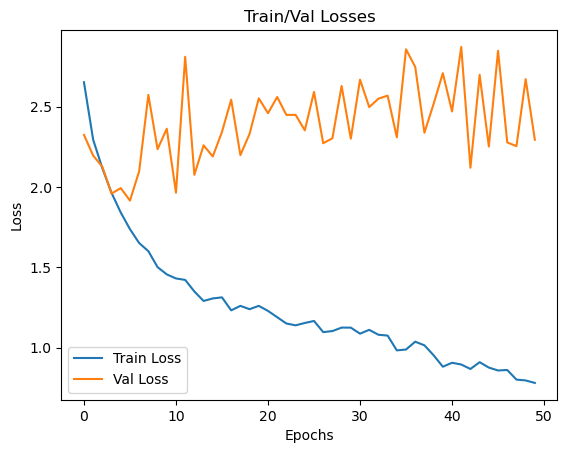

train_losses=[2.651318755066186, 2.293966785508987, 2.1161002450519137, 1.9629600103835614, 1.8406657064170169, 1.7373736629709167, 1.6509019694133111, 1.6003722210376583, 1.5011759923215497, 1.4560258144523666, 1.4306429007597137, 1.4216438974553383, 1.34966240291707, 1.2906942597606725, 1.306466321499027, 1.3130305001610203, 1.2322104325768544, 1.260159182966801, 1.2395970239276775, 1.2602335395868758, 1.228801509441688, 1.1896152771704378, 1.1505160098187408, 1.1391281035908483, 1.1537003771603456, 1.1663399847627383, 1.0970598863579377, 1.1033037050425658, 1.1250843485893562, 1.1247212297735159, 1.0872002052284822, 1.1111094582150554, 1.0804619451015316, 1.0754247914280808, 0.9833422529767131, 0.9887017522290437, 1.0373497316014697, 1.0147197274436728, 0.9527285203599093, 0.8817550668939512, 0.9062188100396541, 0.8954161823841563, 0.8676123307113759, 0.9099646914772123, 0.8762772234036909, 0.8582653370168474, 0.86133539659238, 0.8014481137370506, 0.7963657956025754, 0.7809022433227

100%|██████████| 52/52 [00:00<00:00, 104.08it/s]

Epoch [1/50], Train Loss: 2.4904, Train Accuracy: 22.68%, Val Loss: 2.1600, Val Accuracy: 34.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.15it/s]

Epoch [2/50], Train Loss: 2.0496, Train Accuracy: 40.97%, Val Loss: 2.0013, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.54it/s]

Epoch [3/50], Train Loss: 1.8309, Train Accuracy: 49.89%, Val Loss: 2.0353, Val Accuracy: 40.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.59it/s]

Epoch [4/50], Train Loss: 1.6904, Train Accuracy: 53.77%, Val Loss: 1.9374, Val Accuracy: 43.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.59it/s]

Epoch [5/50], Train Loss: 1.5628, Train Accuracy: 59.99%, Val Loss: 2.0246, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.37it/s]

Epoch [6/50], Train Loss: 1.4674, Train Accuracy: 63.28%, Val Loss: 2.2374, Val Accuracy: 31.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.51it/s]

Epoch [7/50], Train Loss: 1.3204, Train Accuracy: 70.96%, Val Loss: 2.1158, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.88it/s]

Epoch [8/50], Train Loss: 1.2351, Train Accuracy: 73.08%, Val Loss: 2.0203, Val Accuracy: 41.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.22it/s]

Epoch [9/50], Train Loss: 1.1723, Train Accuracy: 74.91%, Val Loss: 1.9019, Val Accuracy: 43.66%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.43it/s]

Epoch [10/50], Train Loss: 1.1347, Train Accuracy: 75.35%, Val Loss: 1.9079, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.71it/s]

Epoch [11/50], Train Loss: 1.0445, Train Accuracy: 79.22%, Val Loss: 2.0078, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.77it/s] 

Epoch [12/50], Train Loss: 0.9668, Train Accuracy: 81.71%, Val Loss: 2.9613, Val Accuracy: 26.10%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 93.78it/s]

Epoch [13/50], Train Loss: 0.9089, Train Accuracy: 82.81%, Val Loss: 2.1052, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.90it/s] 

Epoch [14/50], Train Loss: 0.8644, Train Accuracy: 84.93%, Val Loss: 2.0564, Val Accuracy: 38.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.19it/s]

Epoch [15/50], Train Loss: 0.8560, Train Accuracy: 84.05%, Val Loss: 1.8852, Val Accuracy: 47.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.29it/s]

Epoch [16/50], Train Loss: 0.7800, Train Accuracy: 86.54%, Val Loss: 1.9357, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.03it/s]

Epoch [17/50], Train Loss: 0.7429, Train Accuracy: 87.56%, Val Loss: 2.0243, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.39it/s]

Epoch [18/50], Train Loss: 0.6936, Train Accuracy: 89.32%, Val Loss: 1.9564, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.87it/s]

Epoch [19/50], Train Loss: 0.6736, Train Accuracy: 89.61%, Val Loss: 2.4507, Val Accuracy: 35.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.45it/s]

Epoch [20/50], Train Loss: 0.6861, Train Accuracy: 89.54%, Val Loss: 1.9609, Val Accuracy: 43.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.98it/s] 

Epoch [21/50], Train Loss: 0.5837, Train Accuracy: 90.86%, Val Loss: 2.2135, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.43it/s]

Epoch [22/50], Train Loss: 0.5929, Train Accuracy: 90.93%, Val Loss: 2.1050, Val Accuracy: 42.20%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.21it/s]

Epoch [23/50], Train Loss: 0.5591, Train Accuracy: 91.66%, Val Loss: 1.9363, Val Accuracy: 42.68%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.36it/s] 

Epoch [24/50], Train Loss: 0.5621, Train Accuracy: 91.44%, Val Loss: 2.3776, Val Accuracy: 33.41%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.38it/s]

Epoch [25/50], Train Loss: 0.4979, Train Accuracy: 93.64%, Val Loss: 2.1067, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.04it/s]

Epoch [26/50], Train Loss: 0.5519, Train Accuracy: 92.54%, Val Loss: 2.1402, Val Accuracy: 39.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.38it/s]

Epoch [27/50], Train Loss: 0.5082, Train Accuracy: 92.76%, Val Loss: 1.8857, Val Accuracy: 48.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 100.23it/s]

Epoch [28/50], Train Loss: 0.4702, Train Accuracy: 93.64%, Val Loss: 1.9152, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.06it/s]

Epoch [29/50], Train Loss: 0.4322, Train Accuracy: 94.66%, Val Loss: 1.9958, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.59it/s]

Epoch [30/50], Train Loss: 0.4476, Train Accuracy: 94.15%, Val Loss: 2.2552, Val Accuracy: 40.49%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 110.43it/s]

Epoch [31/50], Train Loss: 0.4595, Train Accuracy: 93.42%, Val Loss: 2.1313, Val Accuracy: 40.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.61it/s] 

Epoch [32/50], Train Loss: 0.4181, Train Accuracy: 94.51%, Val Loss: 1.9628, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.61it/s]

Epoch [33/50], Train Loss: 0.4136, Train Accuracy: 95.10%, Val Loss: 1.9754, Val Accuracy: 41.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.22it/s]

Epoch [34/50], Train Loss: 0.3852, Train Accuracy: 95.90%, Val Loss: 4.7168, Val Accuracy: 24.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.22it/s] 

Epoch [35/50], Train Loss: 0.4225, Train Accuracy: 94.15%, Val Loss: 2.1835, Val Accuracy: 40.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.98it/s]

Epoch [36/50], Train Loss: 0.3697, Train Accuracy: 96.05%, Val Loss: 1.9934, Val Accuracy: 44.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.69it/s]

Epoch [37/50], Train Loss: 0.3532, Train Accuracy: 96.63%, Val Loss: 2.0956, Val Accuracy: 44.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 96.97it/s] 

Epoch [38/50], Train Loss: 0.3698, Train Accuracy: 95.32%, Val Loss: 2.1734, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.71it/s]

Epoch [39/50], Train Loss: 0.3478, Train Accuracy: 96.71%, Val Loss: 1.9192, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.11it/s]

Epoch [40/50], Train Loss: 0.3560, Train Accuracy: 95.54%, Val Loss: 1.9916, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.81it/s]

Epoch [41/50], Train Loss: 0.3140, Train Accuracy: 96.93%, Val Loss: 1.9128, Val Accuracy: 46.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.47it/s]

Epoch [42/50], Train Loss: 0.3424, Train Accuracy: 96.27%, Val Loss: 2.1267, Val Accuracy: 45.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.56it/s]

Epoch [43/50], Train Loss: 0.3204, Train Accuracy: 96.71%, Val Loss: 1.9693, Val Accuracy: 47.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.84it/s]

Epoch [44/50], Train Loss: 0.3195, Train Accuracy: 96.85%, Val Loss: 2.3613, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 113.08it/s]

Epoch [45/50], Train Loss: 0.3127, Train Accuracy: 96.93%, Val Loss: 2.1223, Val Accuracy: 41.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 97.41it/s] 

Epoch [46/50], Train Loss: 0.2949, Train Accuracy: 96.20%, Val Loss: 1.9209, Val Accuracy: 48.05%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.94it/s]

Epoch [47/50], Train Loss: 0.2835, Train Accuracy: 97.51%, Val Loss: 2.4110, Val Accuracy: 38.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.19it/s]

Epoch [48/50], Train Loss: 0.3036, Train Accuracy: 96.71%, Val Loss: 1.9873, Val Accuracy: 44.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.71it/s] 

Epoch [49/50], Train Loss: 0.2922, Train Accuracy: 97.07%, Val Loss: 1.9323, Val Accuracy: 45.85%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.30it/s]

Epoch [50/50], Train Loss: 0.2908, Train Accuracy: 96.93%, Val Loss: 2.5228, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.63it/s]


Test Accuracy: 32.39%


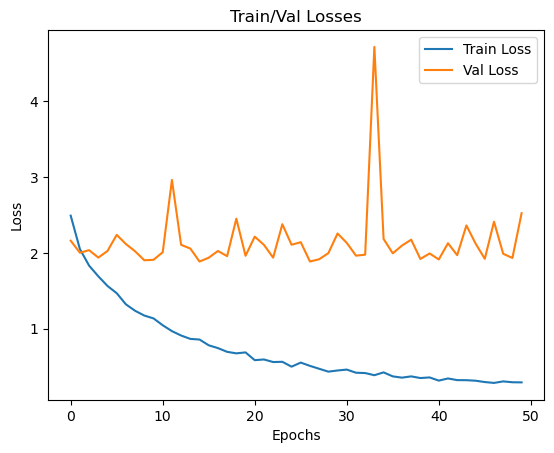

train_losses=[2.490420901287369, 2.049636076765451, 1.8309447277359099, 1.6903528574614497, 1.5627900396871288, 1.4674032114402593, 1.3203675548235576, 1.2351306359670315, 1.172303032805348, 1.1347086642220703, 1.0445167655833283, 0.9667861547037871, 0.9088946411832731, 0.864406227542643, 0.8559550254317055, 0.779997831373884, 0.7428525126816934, 0.6936490621134551, 0.6735950209941083, 0.6861318729774296, 0.5836827111871619, 0.592872834170771, 0.5590583906013366, 0.5621025597142895, 0.4979271317086025, 0.5519048418217932, 0.5082301371104536, 0.4702144262560627, 0.43223376676701664, 0.44761388439532607, 0.4594995310606315, 0.41808202435747227, 0.4136253876818551, 0.385236582560846, 0.42251324566484194, 0.3697084491277299, 0.3531518592471965, 0.3698145276621768, 0.3477963627866137, 0.3560222621288216, 0.31396682416660743, 0.3423866908452664, 0.3204104289935346, 0.31949477403136023, 0.31273051381808276, 0.29492329346419077, 0.28346320803751024, 0.3035725449914472, 0.29216865600462544, 0.2

100%|██████████| 52/52 [00:00<00:00, 106.86it/s]

Epoch [1/50], Train Loss: 2.6072, Train Accuracy: 19.46%, Val Loss: 2.2320, Val Accuracy: 34.63%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.73it/s]

Epoch [2/50], Train Loss: 2.3013, Train Accuracy: 28.82%, Val Loss: 2.1625, Val Accuracy: 38.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.60it/s]

Epoch [3/50], Train Loss: 2.1433, Train Accuracy: 34.24%, Val Loss: 2.2155, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.17it/s]

Epoch [4/50], Train Loss: 2.0453, Train Accuracy: 40.01%, Val Loss: 2.2667, Val Accuracy: 34.15%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.70it/s]

Epoch [5/50], Train Loss: 1.9293, Train Accuracy: 42.21%, Val Loss: 2.0261, Val Accuracy: 45.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.80it/s]


Epoch [6/50], Train Loss: 1.8442, Train Accuracy: 46.16%, Val Loss: 2.1243, Val Accuracy: 39.27%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.19it/s]

Epoch [7/50], Train Loss: 1.8162, Train Accuracy: 47.18%, Val Loss: 2.2349, Val Accuracy: 30.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.29it/s]

Epoch [8/50], Train Loss: 1.7363, Train Accuracy: 49.31%, Val Loss: 2.4520, Val Accuracy: 31.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.97it/s]

Epoch [9/50], Train Loss: 1.7102, Train Accuracy: 52.30%, Val Loss: 2.2988, Val Accuracy: 33.17%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.90it/s]

Epoch [10/50], Train Loss: 1.6500, Train Accuracy: 52.82%, Val Loss: 1.9959, Val Accuracy: 39.76%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.61it/s]

Epoch [11/50], Train Loss: 1.6136, Train Accuracy: 53.40%, Val Loss: 2.2917, Val Accuracy: 34.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.83it/s]

Epoch [12/50], Train Loss: 1.5904, Train Accuracy: 53.40%, Val Loss: 2.8788, Val Accuracy: 20.98%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.86it/s]

Epoch [13/50], Train Loss: 1.5018, Train Accuracy: 58.16%, Val Loss: 2.5438, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.24it/s]

Epoch [14/50], Train Loss: 1.4655, Train Accuracy: 57.64%, Val Loss: 2.5002, Val Accuracy: 29.02%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.48it/s]

Epoch [15/50], Train Loss: 1.4341, Train Accuracy: 60.28%, Val Loss: 2.3456, Val Accuracy: 32.93%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 99.17it/s] 

Epoch [16/50], Train Loss: 1.3619, Train Accuracy: 60.64%, Val Loss: 2.3952, Val Accuracy: 34.88%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.74it/s]

Epoch [17/50], Train Loss: 1.3456, Train Accuracy: 63.57%, Val Loss: 2.4175, Val Accuracy: 39.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.72it/s]

Epoch [18/50], Train Loss: 1.3074, Train Accuracy: 64.59%, Val Loss: 2.2221, Val Accuracy: 38.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.40it/s]

Epoch [19/50], Train Loss: 1.2639, Train Accuracy: 64.23%, Val Loss: 2.4048, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.74it/s]

Epoch [20/50], Train Loss: 1.2334, Train Accuracy: 66.50%, Val Loss: 3.5795, Val Accuracy: 18.29%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.59it/s]

Epoch [21/50], Train Loss: 1.2387, Train Accuracy: 65.98%, Val Loss: 2.3301, Val Accuracy: 32.93%



Traceback (most recent call last):
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/lib/python3.11/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/home/alex/anaconda3/lib/python3.11/shutil.py", line 738, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/alex/anaconda3/lib/python3.11/shutil.py", line 736, in rmtree
    os.rmdir(path, dir_fd=dir_fd)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-1owmf0t1'


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.12it/s]

Epoch [22/50], Train Loss: 1.1472, Train Accuracy: 69.71%, Val Loss: 2.8997, Val Accuracy: 28.54%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.12it/s]

Epoch [23/50], Train Loss: 1.1156, Train Accuracy: 72.06%, Val Loss: 3.1324, Val Accuracy: 26.83%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 98.69it/s] 

Epoch [24/50], Train Loss: 1.1549, Train Accuracy: 69.20%, Val Loss: 2.5875, Val Accuracy: 30.00%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.14it/s]

Epoch [25/50], Train Loss: 1.0597, Train Accuracy: 72.64%, Val Loss: 2.5069, Val Accuracy: 30.73%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.67it/s]

Epoch [26/50], Train Loss: 1.0632, Train Accuracy: 73.08%, Val Loss: 5.0733, Val Accuracy: 17.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.61it/s]

Epoch [27/50], Train Loss: 1.0126, Train Accuracy: 72.93%, Val Loss: 2.9848, Val Accuracy: 27.32%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.55it/s]

Epoch [28/50], Train Loss: 1.0031, Train Accuracy: 74.76%, Val Loss: 2.9321, Val Accuracy: 27.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.46it/s]


Epoch [29/50], Train Loss: 0.9986, Train Accuracy: 73.88%, Val Loss: 3.0570, Val Accuracy: 27.56%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.45it/s]

Epoch [30/50], Train Loss: 0.9488, Train Accuracy: 76.66%, Val Loss: 2.5854, Val Accuracy: 27.80%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.14it/s]

Epoch [31/50], Train Loss: 0.9470, Train Accuracy: 74.54%, Val Loss: 4.0789, Val Accuracy: 21.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.45it/s]

Epoch [32/50], Train Loss: 0.9151, Train Accuracy: 78.13%, Val Loss: 2.1314, Val Accuracy: 40.24%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.96it/s]

Epoch [33/50], Train Loss: 0.9003, Train Accuracy: 76.52%, Val Loss: 2.5040, Val Accuracy: 34.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 104.61it/s]

Epoch [34/50], Train Loss: 0.8619, Train Accuracy: 79.59%, Val Loss: 2.4616, Val Accuracy: 35.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.15it/s]

Epoch [35/50], Train Loss: 0.8432, Train Accuracy: 79.37%, Val Loss: 2.7346, Val Accuracy: 31.46%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.70it/s]

Epoch [36/50], Train Loss: 0.8555, Train Accuracy: 79.08%, Val Loss: 2.7885, Val Accuracy: 29.27%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.59it/s] 


Epoch [37/50], Train Loss: 0.7584, Train Accuracy: 83.17%, Val Loss: 2.6773, Val Accuracy: 33.66%
Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 106.00it/s]

Epoch [38/50], Train Loss: 0.8049, Train Accuracy: 79.59%, Val Loss: 3.5571, Val Accuracy: 26.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 105.68it/s]

Epoch [39/50], Train Loss: 0.7567, Train Accuracy: 82.74%, Val Loss: 3.0894, Val Accuracy: 24.39%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 101.79it/s]

Epoch [40/50], Train Loss: 0.7931, Train Accuracy: 79.15%, Val Loss: 2.6554, Val Accuracy: 33.90%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.19it/s]

Epoch [41/50], Train Loss: 0.7458, Train Accuracy: 81.35%, Val Loss: 3.0540, Val Accuracy: 31.71%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.57it/s]

Epoch [42/50], Train Loss: 0.7439, Train Accuracy: 82.37%, Val Loss: 2.3853, Val Accuracy: 37.07%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 107.53it/s]

Epoch [43/50], Train Loss: 0.6831, Train Accuracy: 84.27%, Val Loss: 3.5901, Val Accuracy: 26.34%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.04it/s]

Epoch [44/50], Train Loss: 0.7219, Train Accuracy: 83.32%, Val Loss: 4.1085, Val Accuracy: 21.95%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 103.54it/s]

Epoch [45/50], Train Loss: 0.6762, Train Accuracy: 83.61%, Val Loss: 2.2597, Val Accuracy: 35.37%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 102.81it/s]

Epoch [46/50], Train Loss: 0.6749, Train Accuracy: 84.05%, Val Loss: 3.5542, Val Accuracy: 25.12%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 108.81it/s]

Epoch [47/50], Train Loss: 0.6505, Train Accuracy: 84.20%, Val Loss: 3.1050, Val Accuracy: 28.78%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 109.41it/s]

Epoch [48/50], Train Loss: 0.6189, Train Accuracy: 85.30%, Val Loss: 2.4228, Val Accuracy: 39.51%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 86.20it/s]

Epoch [49/50], Train Loss: 0.6410, Train Accuracy: 85.74%, Val Loss: 2.3097, Val Accuracy: 41.22%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 52/52 [00:00<00:00, 95.76it/s] 

Epoch [50/50], Train Loss: 0.6380, Train Accuracy: 84.35%, Val Loss: 3.2803, Val Accuracy: 26.59%


Checking gradient for parameter: fc1.weight
Checking gradient for parameter: fc1.bias
Checking gradient for parameter: bn1.weight
Checking gradient for parameter: bn1.bias
Checking gradient for parameter: fc2.weight
Checking gradient for parameter: fc2.bias
Checking gradient for parameter: bn2.weight
Checking gradient for parameter: bn2.bias
Gradients check passed!


100%|██████████| 22/22 [00:00<00:00, 63.81it/s]


Test Accuracy: 23.86%


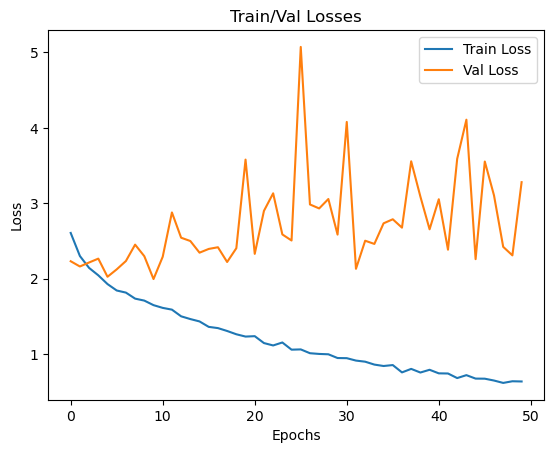

train_losses=[2.6071550448735556, 2.3012771843469633, 2.1432730621761746, 2.0452971270209863, 1.9292913703193442, 1.8442052407571448, 1.8161544576722977, 1.7363224050454926, 1.7101785467382062, 1.6499943740186636, 1.6135923764859026, 1.5904398069047092, 1.5018312533696492, 1.4654555993470533, 1.4340654639472739, 1.3618729400355913, 1.3456349484404626, 1.307445888630828, 1.2638839064982899, 1.2333681565976282, 1.2386652004649068, 1.1472405435746176, 1.1156174181497585, 1.1549081101752163, 1.0597464926758704, 1.0631751993246246, 1.0126387639003886, 1.0031205954258902, 0.9985840350215198, 0.9488250719524963, 0.9469953480868312, 0.9150513745190805, 0.9003305266126554, 0.8618630566443616, 0.8431562293342679, 0.8555309514553227, 0.7584439177959286, 0.8048937589104412, 0.756726586679269, 0.7931186267507007, 0.7457756868928497, 0.7438768544043713, 0.6831345650536275, 0.7219447612065321, 0.6762426671577476, 0.674943687535866, 0.6504920513657798, 0.6188592841924979, 0.6409553445396368, 0.6380166

In [42]:
import torch
import matplotlib.pyplot as plt

results_50_wbn = pd.DataFrame(columns=['optimizer', 'learning_rate', 'weight_decay', 'val_accuracy'])
num_epochs = 50
params = [(optim.SGD, 0.001, 0.01), (optim.SGD, 0.001,0.0001), (optim.Adam, 0.001,0.0001), (optim.SGD, 0.01, 0.001), (optim.RMSprop, 0.001, 0.0001)]

for param in params:    
    model = MyClassificationBatchNormalizationNet(input_size=IMAGE_HEIGHT*IMAGE_WIDTH*3,
                        hidden_size=1024,
                        output_size=20).to(device)

    print(f"Params lr={param[1]}, w={param[2]}, opt={param[0]}")
    train_losses, val_losses, results_50_wbn = train(model, param[0], train_data_loader, val_data_loader, num_epochs, param[1], weight_decay=param[2], res=results_50_wbn)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(test_data_loader)):
            images = images.view(-1, IMAGE_HEIGHT*IMAGE_WIDTH*3).to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Test Accuracy: {100 * accuracy:.2f}%")

    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train/Val Losses')
    plt.legend()
    plt.show()

    print(f"{train_losses=}\n{val_losses}")

In [43]:
results_50_wbn

,optimizer,learning_rate,weight_decay,val_accuracy
0,SGD,0.01,0.0100,0.478049
0,SGD,0.01,0.0001,0.485366
0,Adam,0.01,0.0001,0.441463
0,SGD,0.01,0.0010,0.482927
0,RMSprop,0.01,0.0001,0.451220


The best results achieved by SGD optimizer with: lr = 0.01 and weight_decay = 0.0001. Test accuracy of this model is equal to 46%. That is even worse than without BatchNormalization.
All the train/val losses can be found above.

# Conclusion

Thus, on the butterfly dataset with 20 classes was iterated a lot of optimizers, lr, weight_decay and 1024 hidden layers(256, 512, 2048 also was tried but give worse results). As a result achieve test accuracy of 58% without using BatchNormalization.

From the training graphs, we can see that Neural Network architecture too simple for such number of classes and images. To change it we need to add several more fully connected layers and even convolutional layers for better classification ability.